In this script we manipulated different datascience techniques (like imputation, feature selection and SMOTE) and ML techniques (Logistic regression, random forrest, gradient boosting).
We made different techniques combination to obtained differents results and compared it. 
All techniques are used on the discretes dataset.

# LIBRARIES

In [22]:
%run library_TS.py
%run library_discrete.py

Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.23.5
pandas version: 1.5.3
matplotlib: 3.7.1
TSfresh: 0.20.0
Sklearn version: 1.1.3
Xgboost version: 1.5.0
Lightgbm version: 2.2.3
Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.23.5
pandas version: 1.5.3
matplotlib: 3.7.1
seaborn: 3.7.1
Sklearn version: 1.1.3
LightGBM: 2.2.3
XGBoost: 1.5.0
TensorFlow: 2.12.0
SHAP: 0.41.0
missingno: 0.5.2
imblearn: 0.10.1
joblib: 1.1.1
tableone: 0.7.12


# LOAD THE FILES

In [23]:
# Datas importation
data = pd.read_excel("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/BDD/For_descriptif.xlsx")

# Target
target_df = pd.read_excel("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/BDD/Target.xls", dtype=str, index_col=None, usecols=["ID", "Weaning_success"])

# Drop useless columns of the discrete dataset 
list_useless = ['ID','Sex','LOS','Deceased status','Admission type','Reason for intubation','Weaning test type','Weaning success','Reason for weaning failure','Reason for extubation failure',
                'Extubation failure','Post-extubation NIV','Total No. of days of invasive MV','SpO2','FiO2','PEEP','RR','Minute Volume','Tidal Volume','Arterial SBP',
                'Arterial DBP','MAP','CR','Cumulative Urine output','Hourly Urine Output','Glycemia','Temperature','CPIS','RASS']
X = data.drop(list_useless, axis=1)


# Select the target 
y = target_df["Weaning_success"]

# Descriptives statistics
print("Nombre d'echec de sevrage : ")
print(target_df.Weaning_success.value_counts())


Nombre d'echec de sevrage : 
1    138
0     75
Name: Weaning_success, dtype: int64


# DATASET PREPARATION

In [24]:
############# Imputation by KNN method
scaler = MinMaxScaler() # First Standardization
X_scalar = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_scalar.head()

# The KNN method for the imputation, in this case we use 2 neighbors
imputer = KNNImputer(n_neighbors=2)
X_knn_impute = pd.DataFrame(imputer.fit_transform(X_scalar),columns = X_scalar.columns)

X_knn_impute.isna().sum()

Age                 0
Age > 65y           0
Male                0
MIROG               0
SAPSII              0
                   ..
PCT                 0
Fibrinogen          0
Leukocytes          0
Lymphocytes         0
Arterial lactate    0
Length: 87, dtype: int64

In [25]:
############ Feature selection : 

# Calculate the relevance table https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html
# Using Benjamini Hochberg feature
time_start = time.perf_counter()
relevance_table = calculate_relevance_table(X_knn_impute, y, ml_task='classification')
#relevance_table = relevance_table[relevance_table.relevant] only if we have enought data
relevance_table.sort_values("p_value", inplace=True) # Sort by ascending P-value

time_elapsed = (time.perf_counter()-time_start)
print("extraction done in %.2f seconds" %(time_elapsed))

list_feature = relevance_table["feature"][relevance_table.p_value<0.05] # Take only the feature with p-value<0.05

X_filter = X_knn_impute.loc[:,list_feature]

print(f'Number of relevant feature', len(list_feature))

extraction done in 9.12 seconds
Number of relevant feature 18


In [26]:
relevance_table.to_csv("Relevance table for discrete variable.csv",index=False)

In [27]:
############ Oversampling SMOTE :
############ If we use the unfilter dataset
# First we need to transform the categorical variable in object
#List of the categorical variable 
cat_col_index = ['Age > 65y','Male','Respiratory Admission','COVID19 Admission','Neurologic admission','Cardiac Arrest admission','Chirurgical admission',
                'Multivisceral Failure admission','Shock admission','Immunodepression','Obesity','Neurodegenerative disease','Chronic hepatic disease',
                'Chronic kidney disease','COPD','Obstructive sleep apnea','Tobacco','Arterial Hypertension','Diabetes mellitus','Ischemic cardiopathy',
                'Dilated cardiomyopathy','Hypertrophic cardiomyopathy','Obstructive cardiomyopathy','Atrial fibrillation','Valvulopathy','Respiratory Intubation',
                'Neurologic Intubation','Chirurgical Intubation','Cardiac arrest intubation','ZEEP','PEEP4','TT','Anterior auto extubation','Pré-intubation NIV',
                'NO','NOREPINEPHRINE (hospitalisation)','NOREPINEPHRINE (weaning test)','Other amine (weaning test)','Antihypertensive (weaning test)',
                'Extra-renal epuration','VAP','MIDAZOLAM (test)','Other BZD (test)','PROPOFOL (test)','OPIOID (test)','NEUROLEPTIC (test)'
                ]

# Modification of the object type
X_knn_impute[cat_col_index] = X_knn_impute[cat_col_index].astype(object)

# Divide the full dataset in train and test
X_train_nofilter, X_test_nofilter, y_train_nofilter, y_test_nofilter= train_test_split(X_knn_impute, y, test_size=0.2, random_state=42, stratify = y)


print("Before SMOTE :\n",y_train_nofilter.value_counts())

# Script for the SMOTE NC
sm = SMOTENC(categorical_features=[X_knn_impute.dtypes==object], k_neighbors=3, sampling_strategy=1, random_state=None) #Assign the object column(categorical variable) to the SMOTE NC 
# Sampling strategy = taux d'observation minoritaire à attendre
# K_neighbors = le nombre de plus proches voisins

# Resample the train by the oversampling
X_train_nf_smote, y_train_nf_smote= sm.fit_resample(X_train_nofilter, y_train_nofilter)

# Retransform the object variable in float for the ML models
X_train_nf_smote[cat_col_index]=X_train_nf_smote[cat_col_index].astype(float)
X_test_nofilter[cat_col_index]=X_test_nofilter[cat_col_index].astype(float)

# summarize the new class distribution

print("\nAfter SMOTE :\n",y_train_nf_smote.value_counts())


Before SMOTE :
 1    110
0     60
Name: Weaning_success, dtype: int64

After SMOTE :
 1    110
0    110
Name: Weaning_success, dtype: int64


In [28]:
############ Oversampling SMOTE :
############ If we use the filter dataset
# First we need to transform the categorical variable in object
#List of the categorical variable 
cat_col_index = ['Age > 65y','Male','Respiratory Admission','COVID19 Admission','Neurologic admission','Cardiac Arrest admission','Chirurgical admission',
                'Multivisceral Failure admission','Shock admission','Immunodepression','Obesity','Neurodegenerative disease','Chronic hepatic disease',
                'Chronic kidney disease','COPD','Obstructive sleep apnea','Tobacco','Arterial Hypertension','Diabetes mellitus','Ischemic cardiopathy',
                'Dilated cardiomyopathy','Hypertrophic cardiomyopathy','Obstructive cardiomyopathy','Atrial fibrillation','Valvulopathy','Respiratory Intubation',
                'Neurologic Intubation','Chirurgical Intubation','Cardiac arrest intubation','ZEEP','PEEP4','TT','Anterior auto extubation','Pré-intubation NIV',
                'NO','NOREPINEPHRINE (hospitalisation)','NOREPINEPHRINE (weaning test)','Other amine (weaning test)','Antihypertensive (weaning test)',
                'Extra-renal epuration','VAP','MIDAZOLAM (test)','Other BZD (test)','PROPOFOL (test)','OPIOID (test)','NEUROLEPTIC (test)'
                ]
# Take the column in common between the list of categorical variable and the filtered column
common_column = np.intersect1d(cat_col_index, list_feature)



# Divide the full dataset in train and test
X_train_filter, X_test_filter, y_train_filter, y_test_filter= train_test_split(X_filter, y, test_size=0.2, random_state=42, stratify = y)



print("Before SMOTE :", y_train_filter.value_counts())
# Modification of the object type
X_filter[common_column] = X_filter[common_column].astype(object)
# Script for the SMOTE NC
sm = SMOTENC(categorical_features=[X_filter.dtypes==object], k_neighbors=3, sampling_strategy=1, random_state=None) #Assign the object column(categorical variable) to the SMOTE NC 
# Sampling strategy = taux d'observation minoritaire à attendre
# K_neighbors = le nombre de plus proches voisins
# Resample the train by the oversampling
X_train_filter_smote, y_train_filter_smote= sm.fit_resample(X_train_filter, y_train_filter)
# summarize the new class distribution
print("\nAfter SMOTE :\n", y_train_filter_smote.value_counts())

# Retransform the object variable in float
X_train_filter_smote[common_column]=X_train_filter_smote[common_column].astype(float)
X_test_filter[common_column]=X_test_filter[common_column].astype(float)

Before SMOTE : 1    110
0     60
Name: Weaning_success, dtype: int64

After SMOTE :
 1    110
0    110
Name: Weaning_success, dtype: int64


In [29]:
# If we don't use filtering and SMOTE
# Divide the basic dataset in train and test
X_train_basic, X_test_basic, y_train_basic, y_test_basic= train_test_split(X_knn_impute, y, test_size=0.2, random_state=42, stratify = y)
print(f'Class representation in training set :',Counter(y_train_basic))
print(f'Class representation in testing set :', Counter(y_test_basic))

X_train_basic[cat_col_index]=X_train_basic[cat_col_index].astype(float)
X_test_basic[cat_col_index]=X_test_basic[cat_col_index].astype(float)


Class representation in training set : Counter({'1': 110, '0': 60})
Class representation in testing set : Counter({'1': 28, '0': 15})


# FUNCTION DEFINITION FOR SAVE THE RESULTS

In [30]:
def print_auc(clf,X_train,y_train,X_test,y_test,model_name) :
    """Function for print the AUC and AUC PR and save it """
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, thr = metrics.roc_curve(y_test,  y_pred_proba, pos_label='1')
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=model_name+" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds_log = precision_recall_curve(y_test, y_pred_proba, pos_label='1')
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = metrics.auc(recall, precision)
 
    
    plt.plot(recall, precision,label=model_name+" auc_prc="+str(auc_precision_recall))
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc=4)
    plt.show()
    train_score = accuracy_score(y_train, clf.predict(X_train)) * 100
    test_score = accuracy_score(y_test, clf.predict(X_test)) * 100
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    print_score(clf, X_train, y_train, X_test, y_test, train=False)
    precision_sc=precision_score(y_test, clf.predict(X_test), average=None)
    recall_sc=recall_score(y_test, clf.predict(X_test), average=None)
    
    f1=metrics.f1_score(y_test, clf.predict(X_test), pos_label='1')
    metriques = {"fpr": fpr,"recall_sc":recall_sc,"precision_sc":precision_sc,"recall":recall,"precision":precision,"model":clf,"tpr": tpr,"test_score":test_score,"train_score":train_score,"f1":f1,"auc_pr":auc_precision_recall,"auc":auc}
    return metriques




def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    """Function to print and save the results in dataframe format"""
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n====================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n====================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# MODEL DEFINITION FOR BASIC DATASET

## 1. LOGISTIC REGRESSION (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 12.79 seconds


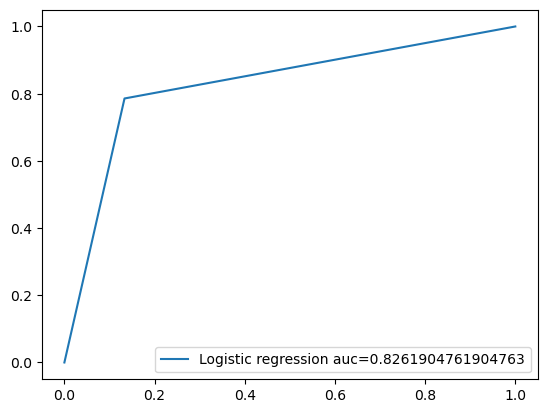

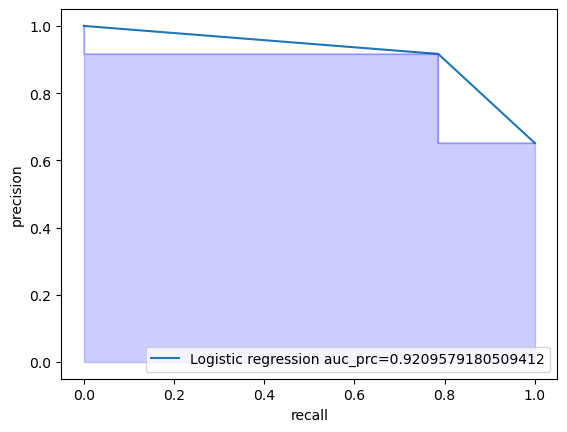

Train Result:
Accuracy Score: 64.71%
________________________________________________________________
CLASSIFICATION REPORT:
              0           1  accuracy   macro avg  weighted avg
precision   0.0    0.647059  0.647059    0.323529      0.418685
recall      0.0    1.000000  0.647059    0.500000      0.647059
f1-score    0.0    0.785714  0.647059    0.392857      0.508403
support    60.0  110.000000  0.647059  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[  0  60]
 [  0 110]]

Test Result:
Accuracy Score: 65.12%
________________________________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.651163  0.651163   0.325581      0.424013
recall      0.0   1.000000  0.651163   0.500000      0.651163
f1-score    0.0   0.788732  0.651163   0.394366      0.513593
support    15.0  28.000000  0.651163  43.000000     43.000000
____________

In [31]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_basic, y_train_basic)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,logistic_Reg.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, logistic_Reg.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_basic)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_basic,logistic_Reg.predict(X_test_basic))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 94.64 seconds


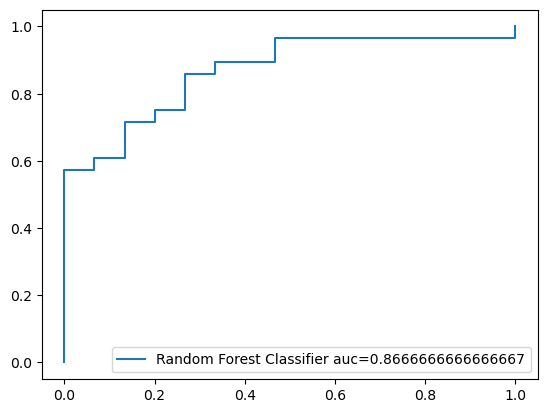

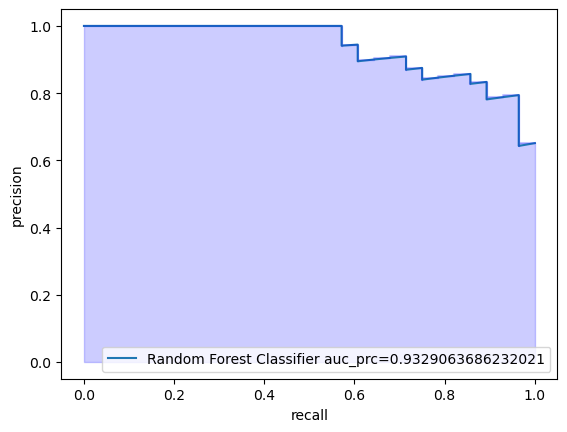

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.875000   0.771429  0.790698   0.823214      0.807558
recall      0.466667   0.964286  0.790698   0.715476      0.790698
f1-score    0.608696   0.857143  0.790698   0.732919      0.770475
support    15.000000  28.000000  0.790698  43.000000     43.000000
________________

In [32]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL################################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE #############################################
score = roc_auc_score(y_test_basic,RFC.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, RFC.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_basic)

clf_rdf=print_auc(RFC,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_basic,RFC.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3.XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 62.98 seconds


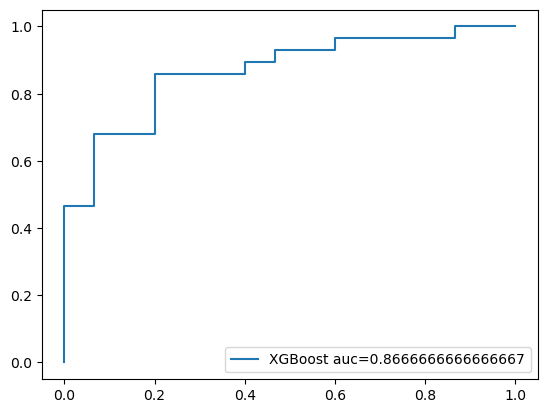

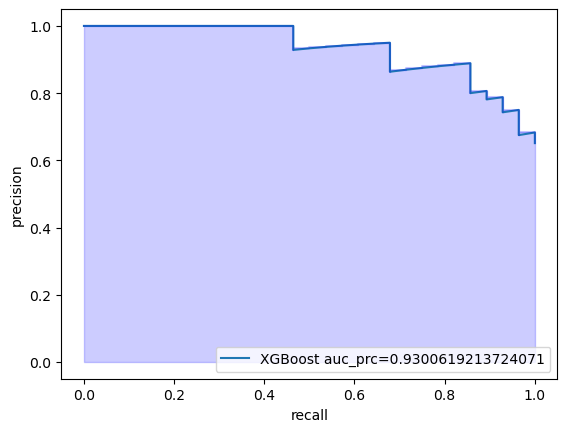

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.733333   0.857143  0.813953   0.795238      0.813953
recall      0.733333   0.857143  0.813953   0.795238      0.813953
f1-score    0.733333   0.857143  0.813953   0.795238      0.813953
support    15.000000  28.000000  0.813953  43.000000     43.000000
________________

In [33]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,XGB.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, XGB.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_basic)

clf_xgb=print_auc(XGB,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_basic,XGB.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 40, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 149.74 seconds


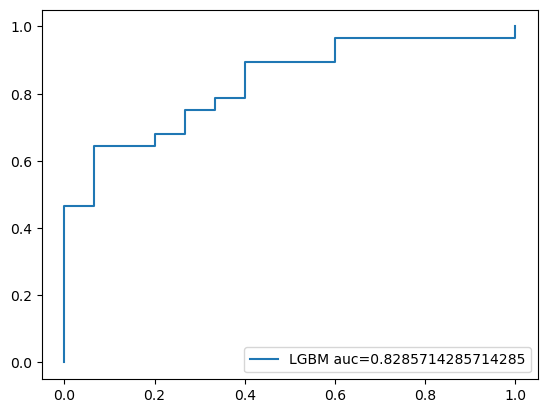

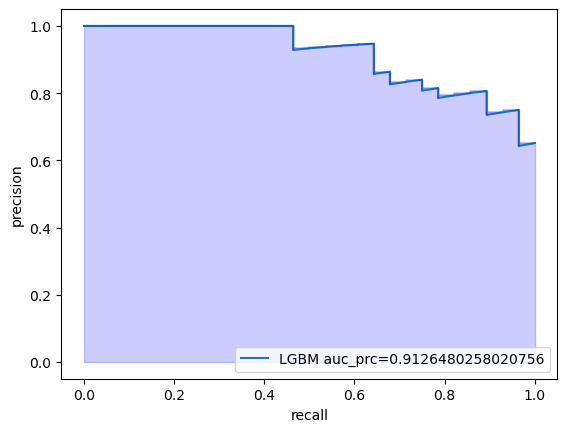

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.750000   0.806452  0.790698   0.778226      0.786759
recall      0.600000   0.892857  0.790698   0.746429      0.790698
f1-score    0.666667   0.847458  0.790698   0.757062      0.784391
support    15.000000  28.000000  0.790698  43.000000     43.000000
________________

In [34]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,LGB.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, LGB.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_basic)

clf_lgb=print_auc(LGB,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_basic,LGB.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.67 seconds


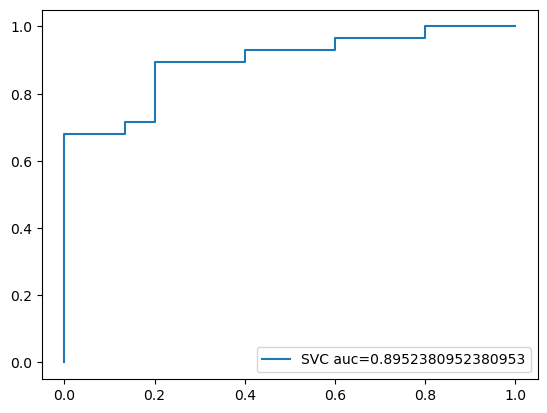

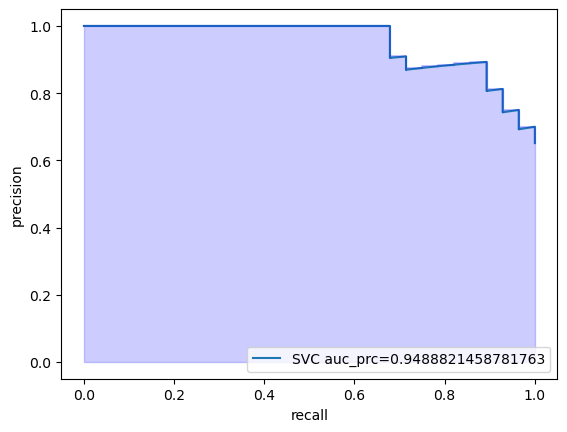

Train Result:
Accuracy Score: 90.59%
________________________________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.978261    0.879032  0.905882    0.928647      0.914054
recall      0.750000    0.990909  0.905882    0.870455      0.905882
f1-score    0.849057    0.931624  0.905882    0.890340      0.902483
support    60.000000  110.000000  0.905882  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[ 45  15]
 [  1 109]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.862069  0.837209   0.823892      0.835434
recall      0.733333   0.892857  0.837209   0.813095      0.837209
f1-score    0.758621   0.877193  0.837209   0.817907      0.835831
support    15.000000  28.0000

In [35]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,svc.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, svc.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_basic)

clf_svc=print_auc(svc,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_basic,svc.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.01}
learning done in 0.16 seconds


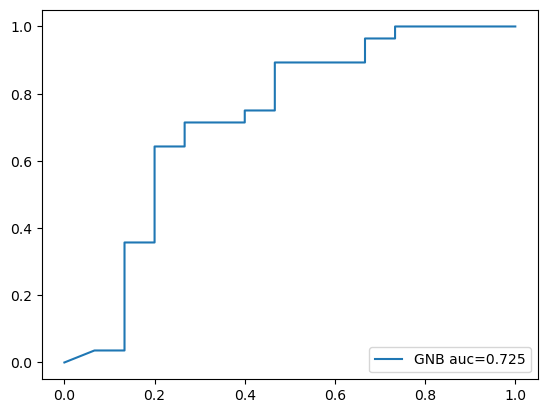

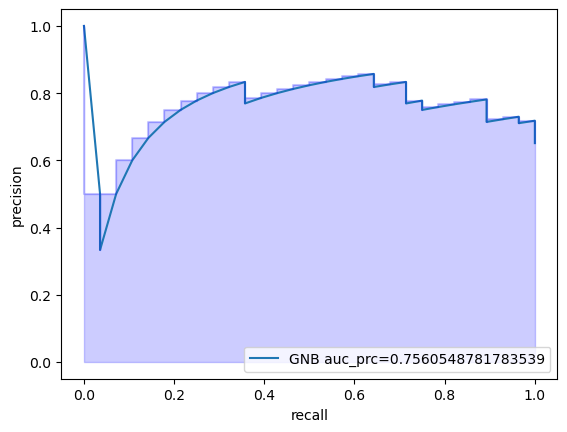

Train Result:
Accuracy Score: 74.71%
________________________________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.604938    0.876404  0.747059    0.740671      0.780593
recall      0.816667    0.709091  0.747059    0.762879      0.747059
f1-score    0.695035    0.783920  0.747059    0.739478      0.752549
support    60.000000  110.000000  0.747059  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[49 11]
 [32 78]]

Test Result:
Accuracy Score: 67.44%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.529412   0.769231  0.674419   0.649321      0.685573
recall      0.600000   0.714286  0.674419   0.657143      0.674419
f1-score    0.562500   0.740741  0.674419   0.651620      0.678564
support    15.000000  28.000000  

In [36]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,GNB.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, GNB.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_basic)

clf_gnb=print_auc(GNB,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_basic,GNB.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 28, 'p': 2, 'weights': 'distance'}
learning done in 16.27 seconds


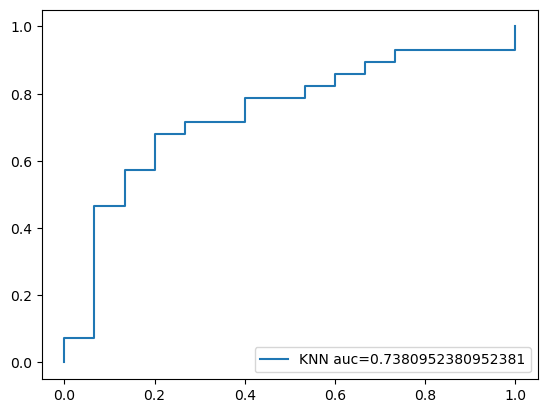

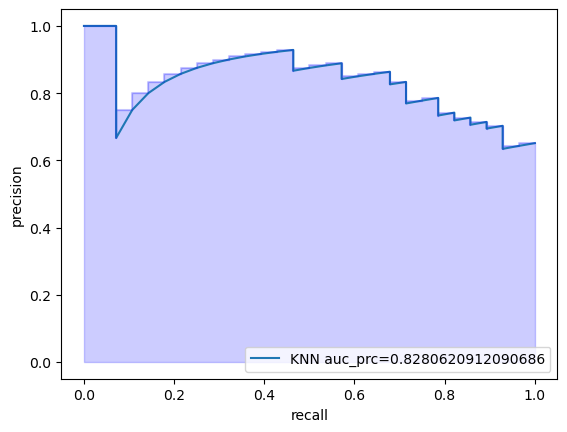

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 62.79%
________________________________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.642857  0.627907   0.321429      0.418605
recall      0.0   0.964286  0.627907   0.482143      0.627907
f1-score    0.0   0.771429  0.627907   0.385714      0.502326
support    15.0  28.000000  0.627907  43.000000     43.000000
_________________________________________

In [37]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_basic,y_train_basic)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_basic, y_train_basic) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_basic,KNN.predict_proba(X_test_basic)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_basic, KNN.predict_proba(X_test_basic)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_basic)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_basic)

clf_knn=print_auc(KNN,X_train_basic,y_train_basic,X_test_basic,y_test_basic,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_basic,KNN.predict(X_test_basic))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## Save results

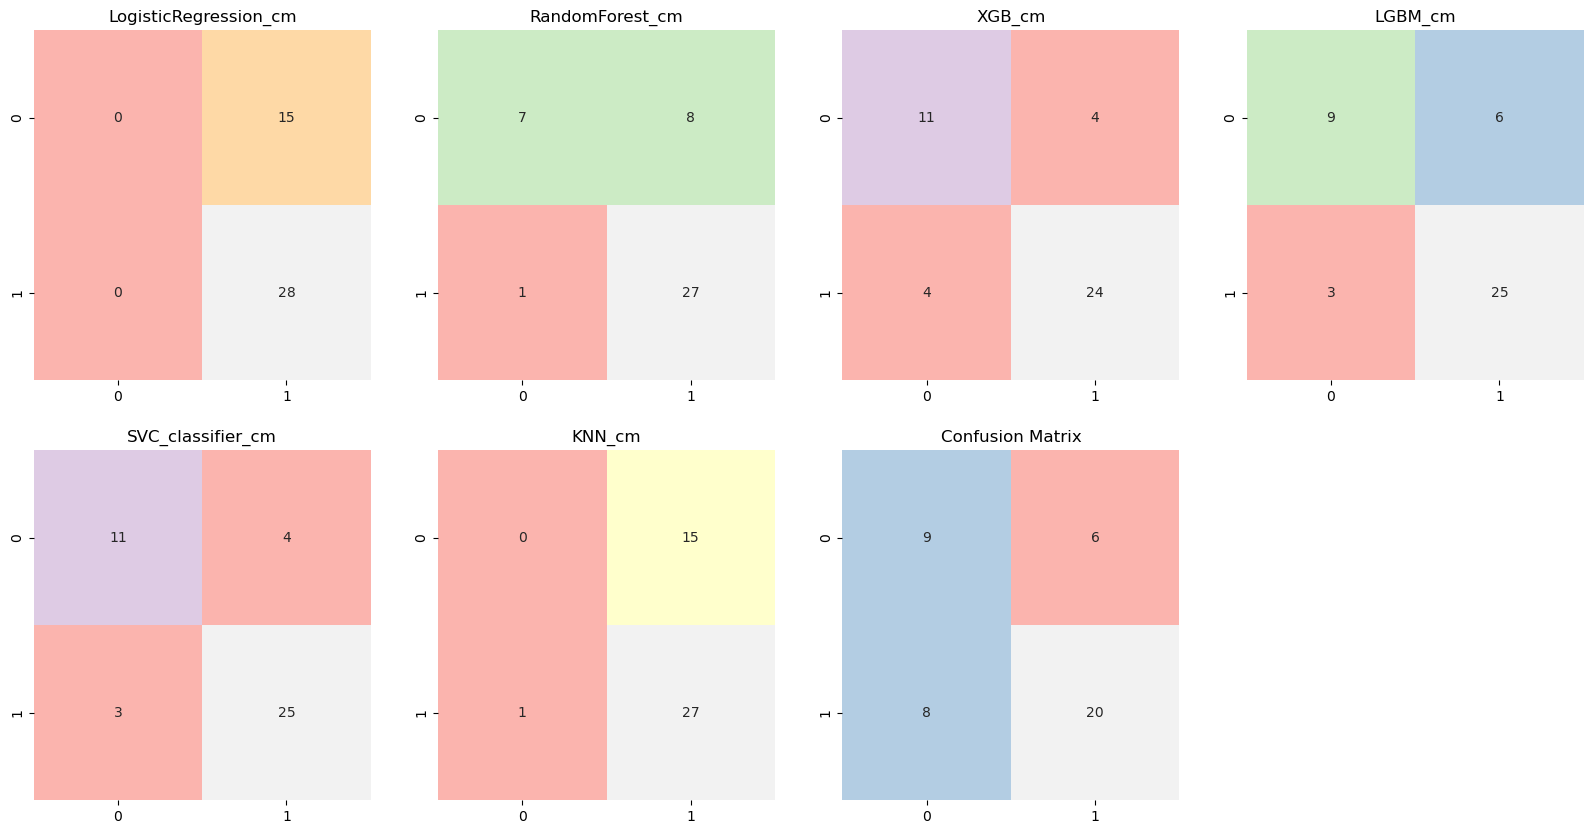

<Figure size 640x480 with 0 Axes>

In [38]:
# Confusion matrix 

plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.title("LogisticRegression_cm")
sns.heatmap(logistic_Reg_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,2)
plt.title("RandomForest_cm")
sns.heatmap(rdf_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,3)
plt.title("XGB_cm")
sns.heatmap(xgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,4)
plt.title("LGBM_cm")
sns.heatmap(lgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,5)
plt.title("SVC_classifier_cm")
sns.heatmap(svc_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,6)
plt.title("KNN_cm")
sns.heatmap(knn_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,7)
plt.title("GNM_cm")
sns.heatmap(gnb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)

plt.title("Confusion Matrix")
plt.show()

plt.savefig('Confusion matrix for basic dataset (with no filtering)', dpi = 900)

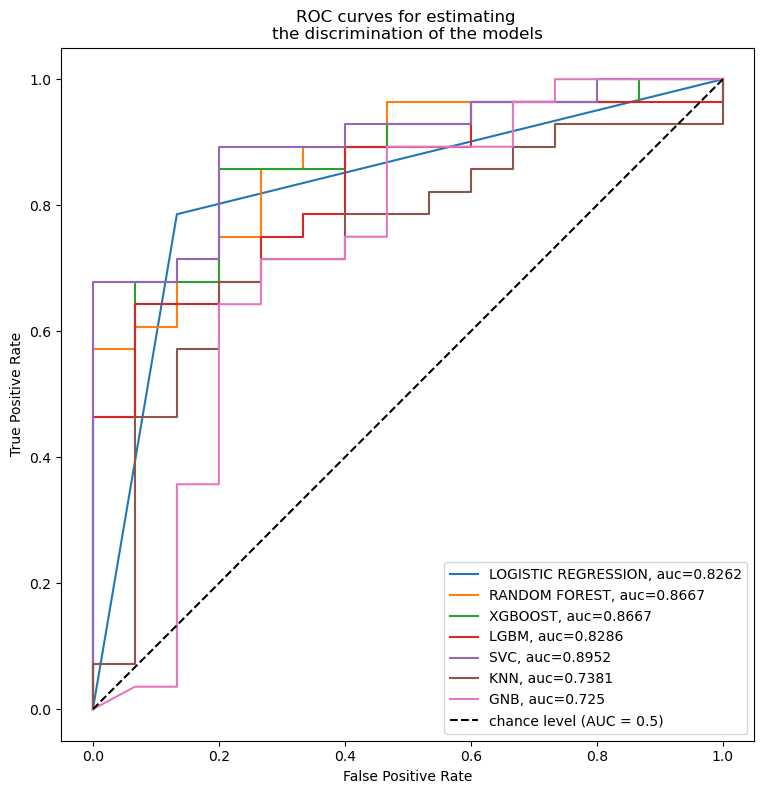

In [39]:
# plot AUC
plt.rcParams["figure.figsize"] = [16,9]

# plot the different model
plt.plot(logistic_Reg_clf["fpr"],logistic_Reg_clf["tpr"],label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc"],4)))
plt.plot(clf_rdf["fpr"],clf_rdf["tpr"],label="RANDOM FOREST, auc="+str(round(clf_rdf["auc"],4)))
plt.plot(clf_xgb["fpr"],clf_xgb["tpr"],label="XGBOOST, auc="+str(round(clf_xgb["auc"],4)))
plt.plot(clf_lgb["fpr"],clf_lgb["tpr"],label="LGBM, auc="+str(round(clf_lgb["auc"],4)))
plt.plot(clf_svc["fpr"],clf_svc["tpr"],label="SVC, auc="+str(round(clf_svc["auc"],4)))
plt.plot(clf_knn["fpr"],clf_knn["tpr"],label="KNN, auc="+str(round(clf_knn["auc"],4)))
plt.plot(clf_gnb["fpr"],clf_gnb["tpr"],label="GNB, auc="+str(round(clf_gnb["auc"],4)))

# Plot the median curve
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for estimating \nthe discrimination of the models")
plt.legend()
plt.style.use('fast')

plt.legend(loc=4)
plt.savefig('ROC curves for basic dataset (with imputation).png', dpi = 900)
plt.show()

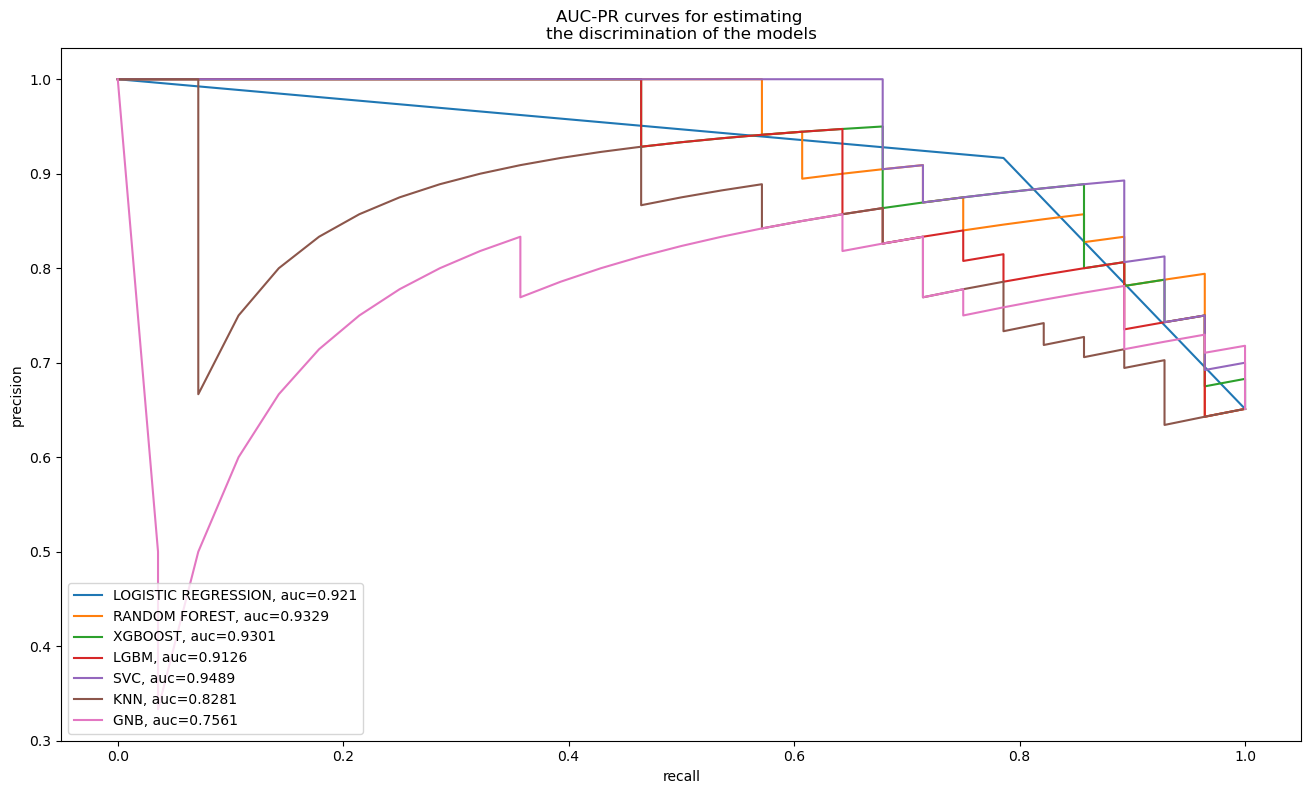

In [40]:
# Plot AUC_PR
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(logistic_Reg_clf["recall"],logistic_Reg_clf["precision"], label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc_pr"],4)))
plt.plot(clf_rdf["recall"],clf_rdf["precision"], label="RANDOM FOREST, auc="+str(round(clf_rdf["auc_pr"],4)))
plt.plot(clf_xgb["recall"],clf_xgb["precision"],label="XGBOOST, auc="+str(round(clf_xgb["auc_pr"],4)))
plt.plot(clf_lgb["recall"],clf_lgb["precision"],label="LGBM, auc="+str(round(clf_lgb["auc_pr"],4)))
plt.plot(clf_svc["recall"],clf_svc["precision"],label="SVC, auc="+str(round(clf_svc["auc_pr"],4)))
plt.plot(clf_knn["recall"],clf_knn["precision"],label="KNN, auc="+str(round(clf_knn["auc_pr"],4)))
plt.plot(clf_gnb["recall"],clf_gnb["precision"],label="GNB, auc="+str(round(clf_gnb["auc_pr"],4)))

plt.style.use('fast')
plt.title("AUC-PR curves for estimating \nthe discrimination of the models")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=3)
plt.savefig('AUC PR for basic dataset (with imputation).png', dpi = 900)
plt.show()

In [41]:
results_df.to_csv('results for basic dataset (with imputation).csv', index=True)

# MODELS FOR FILTER DATASET

## 1. LOGISTIC REGRESSION (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 6.45 seconds


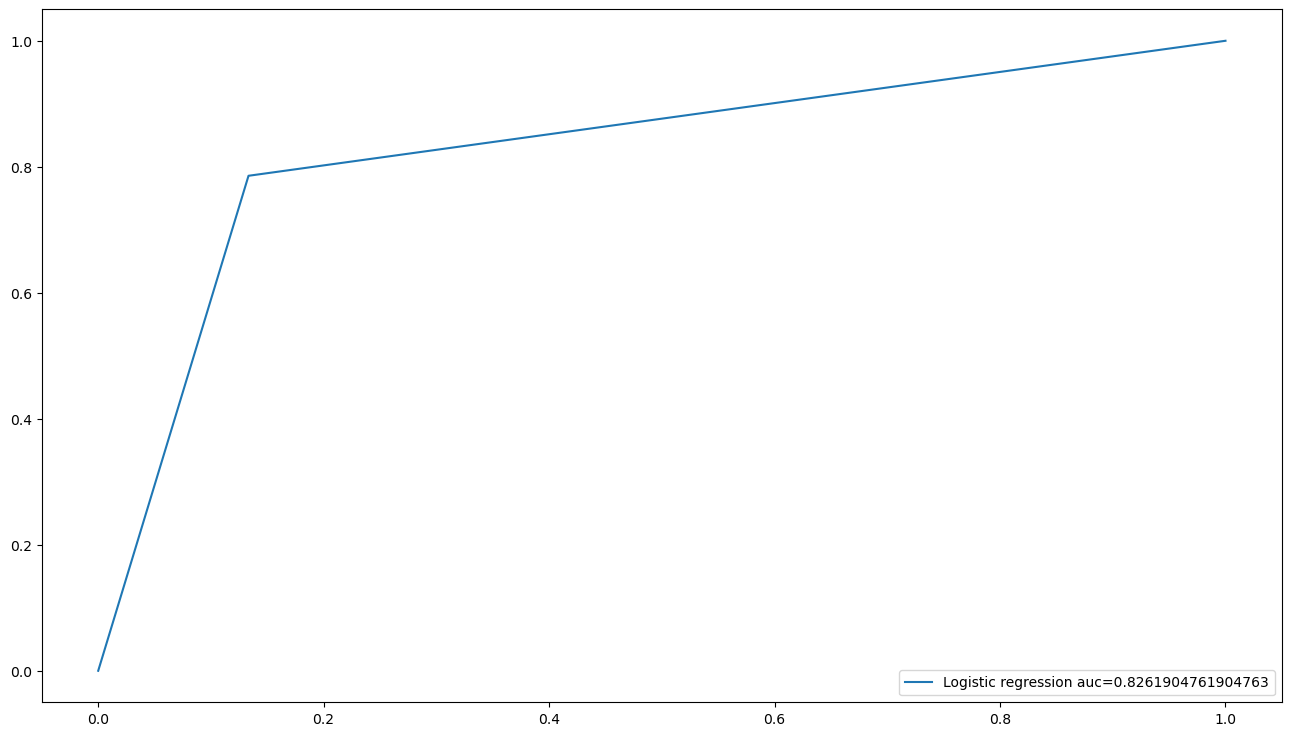

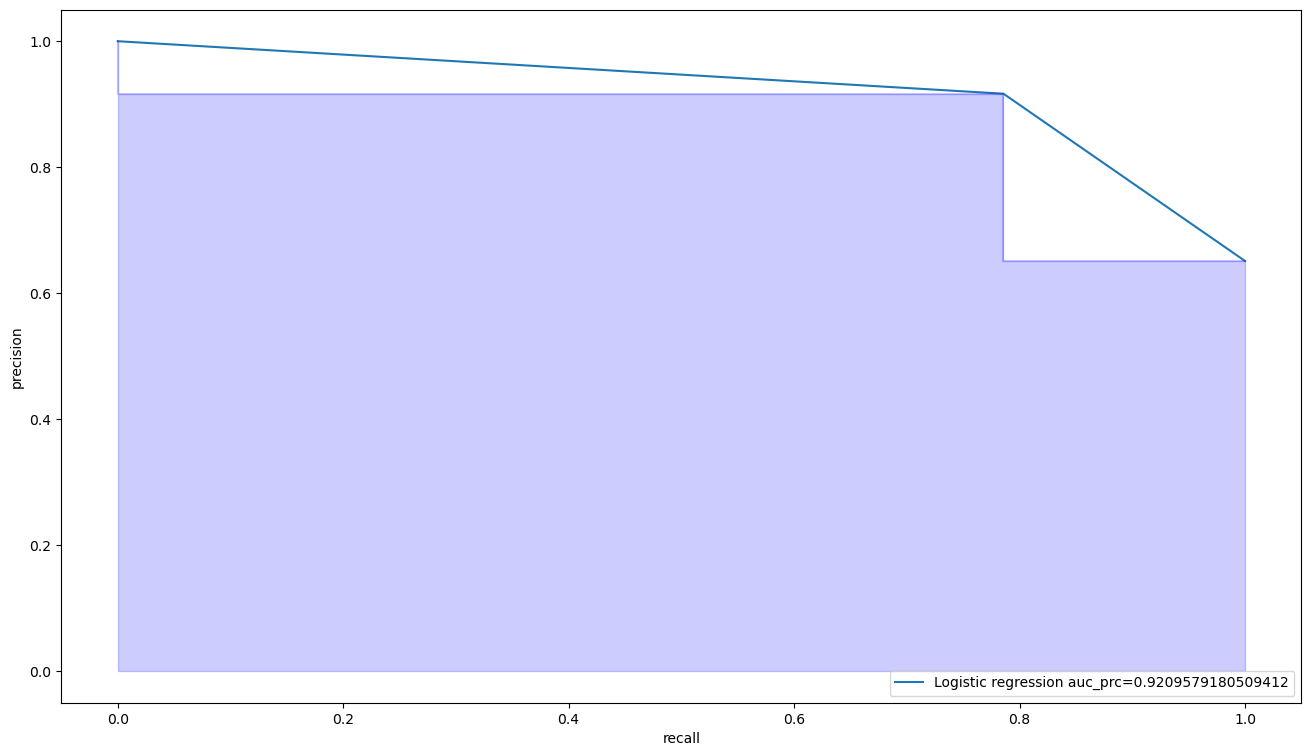

Train Result:
Accuracy Score: 64.71%
________________________________________________________________
CLASSIFICATION REPORT:
              0           1  accuracy   macro avg  weighted avg
precision   0.0    0.647059  0.647059    0.323529      0.418685
recall      0.0    1.000000  0.647059    0.500000      0.647059
f1-score    0.0    0.785714  0.647059    0.392857      0.508403
support    60.0  110.000000  0.647059  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[  0  60]
 [  0 110]]

Test Result:
Accuracy Score: 65.12%
________________________________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.651163  0.651163   0.325581      0.424013
recall      0.0   1.000000  0.651163   0.500000      0.651163
f1-score    0.0   0.788732  0.651163   0.394366      0.513593
support    15.0  28.000000  0.651163  43.000000     43.000000
____________

In [42]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_filter, y_train_filter)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,logistic_Reg.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, logistic_Reg.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_filter)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_filter,logistic_Reg.predict(X_test_filter))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 97.38 seconds


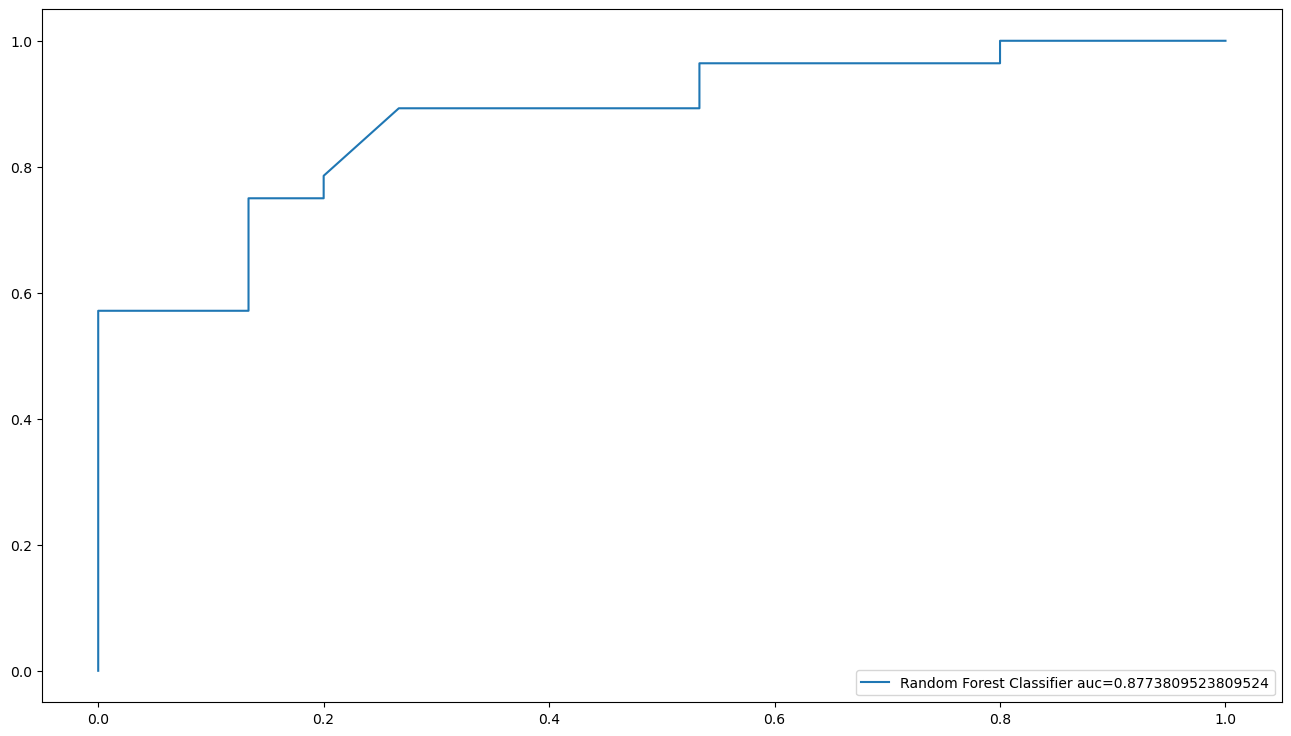

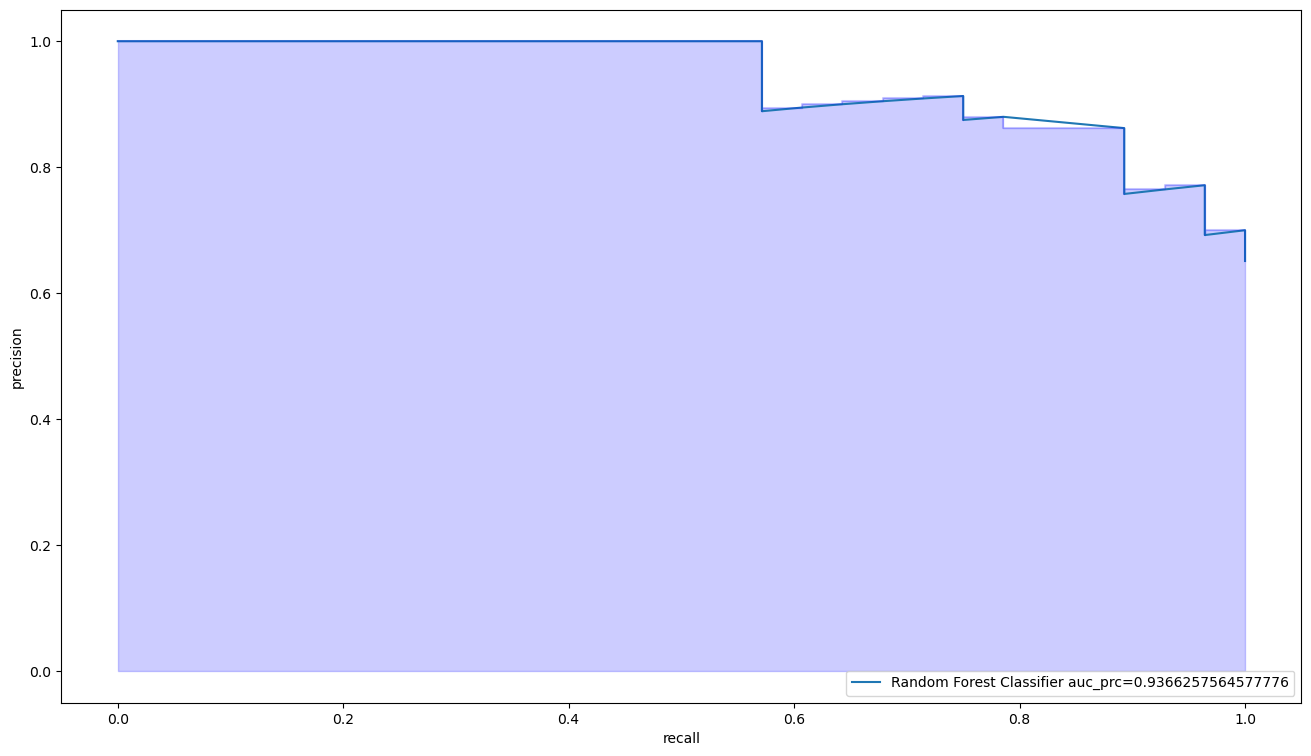

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 76.74%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.727273   0.781250  0.767442   0.754261      0.762421
recall      0.533333   0.892857  0.767442   0.713095      0.767442
f1-score    0.615385   0.833333  0.767442   0.724359      0.757305
support    15.000000  28.000000  0.767442  43.000000     43.000000
________________

In [43]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,RFC.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, RFC.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_filter)

clf_rdf=print_auc(RFC,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_filter,RFC.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 10, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 42.98 seconds


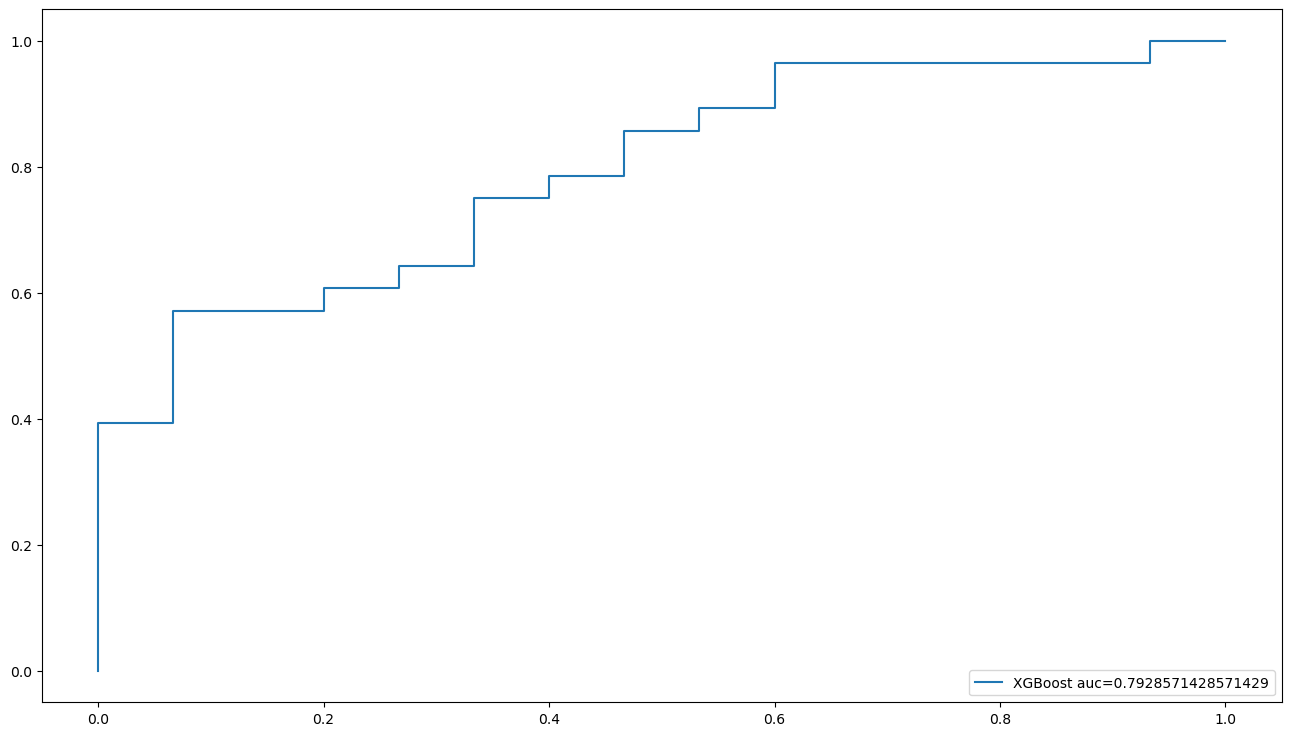

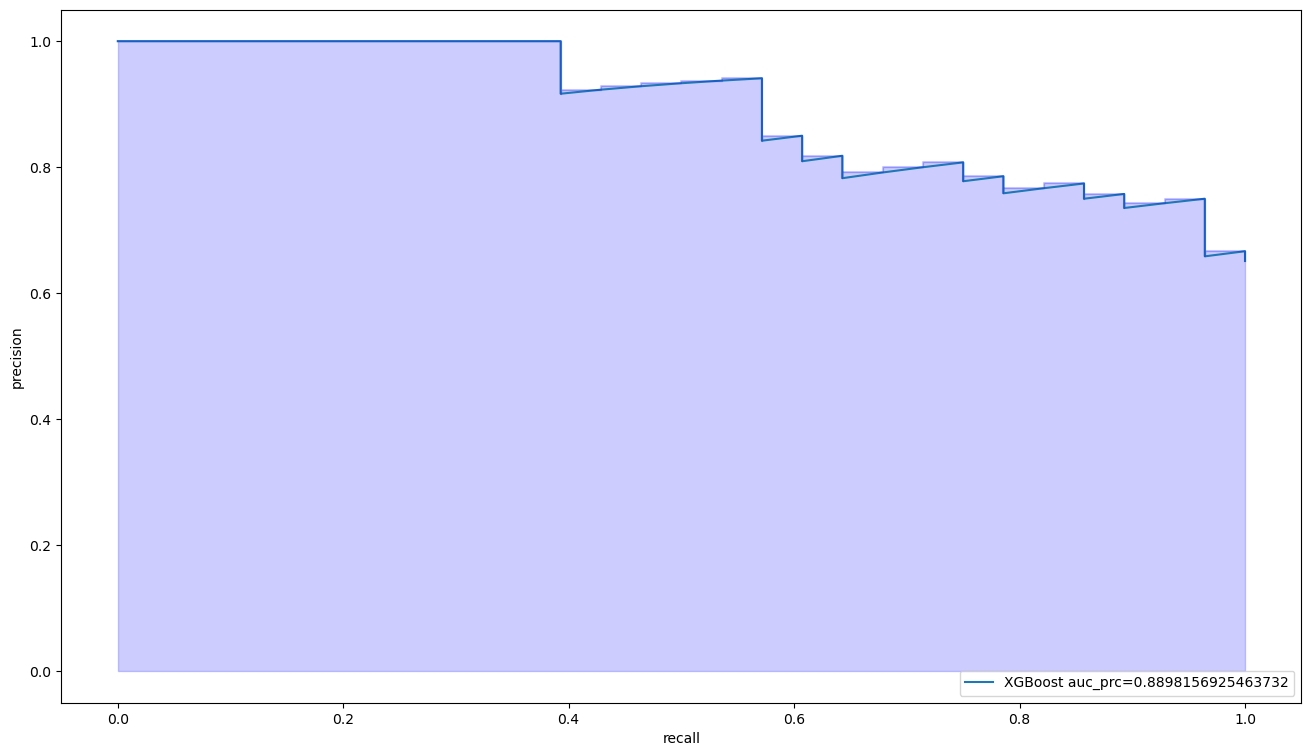

Train Result:
Accuracy Score: 96.47%
________________________________________________________________
CLASSIFICATION REPORT:
               0           1  accuracy   macro avg  weighted avg
precision   0.95    0.972727  0.964706    0.961364      0.964706
recall      0.95    0.972727  0.964706    0.961364      0.964706
f1-score    0.95    0.972727  0.964706    0.961364      0.964706
support    60.00  110.000000  0.964706  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[ 57   3]
 [  3 107]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.700000   0.757576  0.744186   0.728788      0.737491
recall      0.466667   0.892857  0.744186   0.679762      0.744186
f1-score    0.560000   0.819672  0.744186   0.689836      0.729089
support    15.000000  28.000000  0.744186  43.000

In [44]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,XGB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, XGB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_filter)

clf_xgb=print_auc(XGB,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_filter,XGB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 130.61 seconds


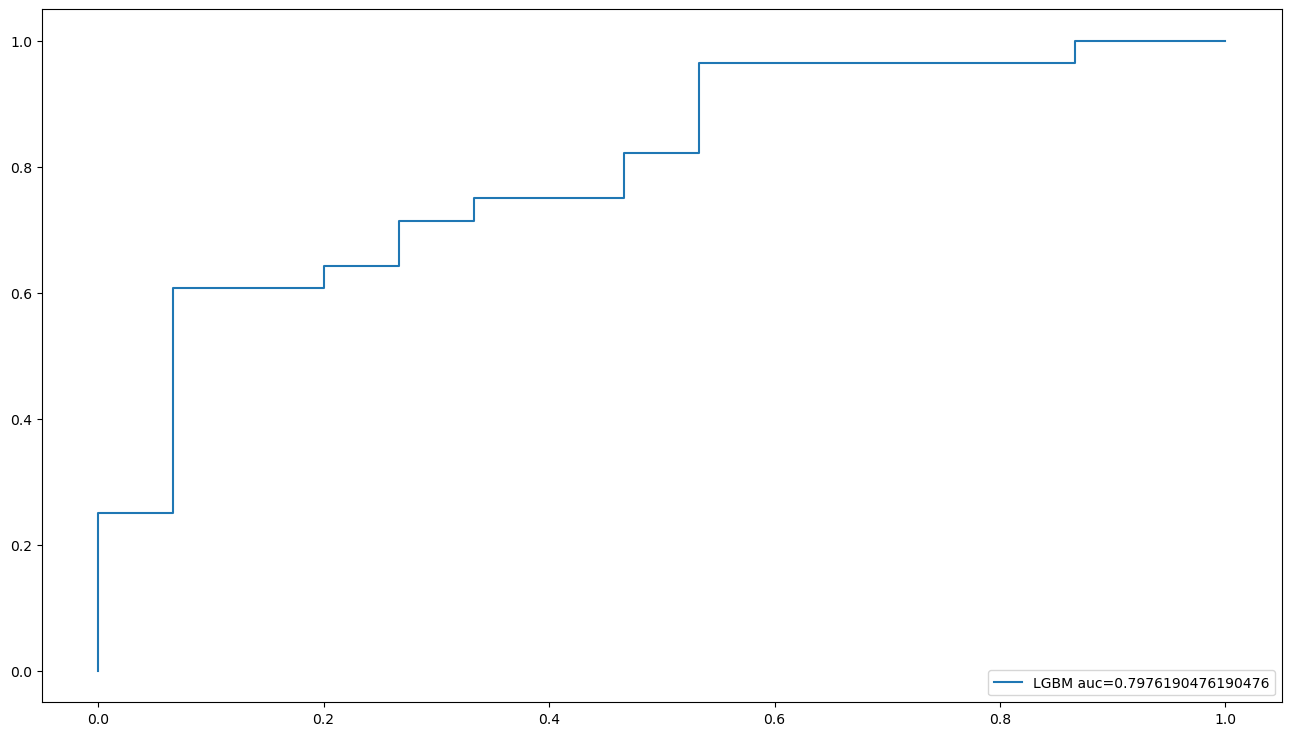

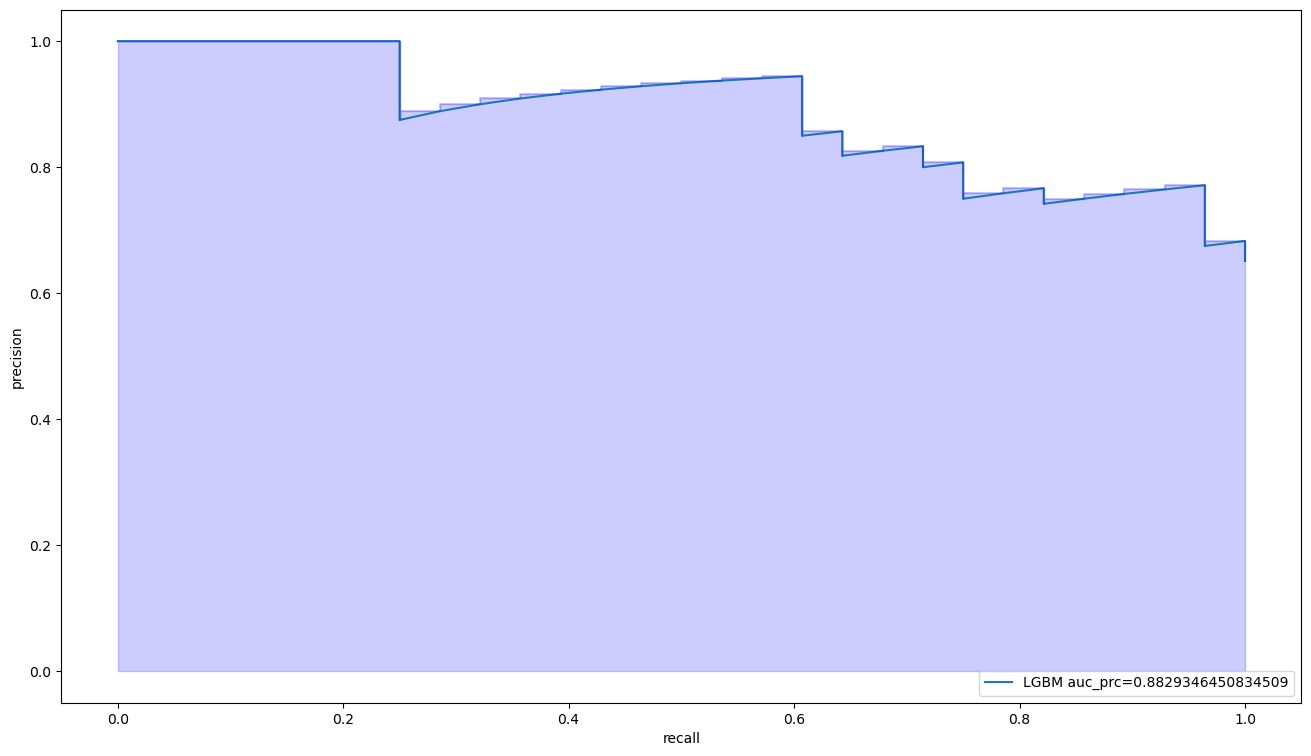

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 72.09%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.636364   0.750000   0.72093   0.693182      0.710359
recall      0.466667   0.857143   0.72093   0.661905      0.720930
f1-score    0.538462   0.800000   0.72093   0.669231      0.708766
support    15.000000  28.000000   0.72093  43.000000     43.000000
________________

In [45]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,LGB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, LGB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_filter)

clf_lgb=print_auc(LGB,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_filter,LGB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. SVC (svc)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.51 seconds


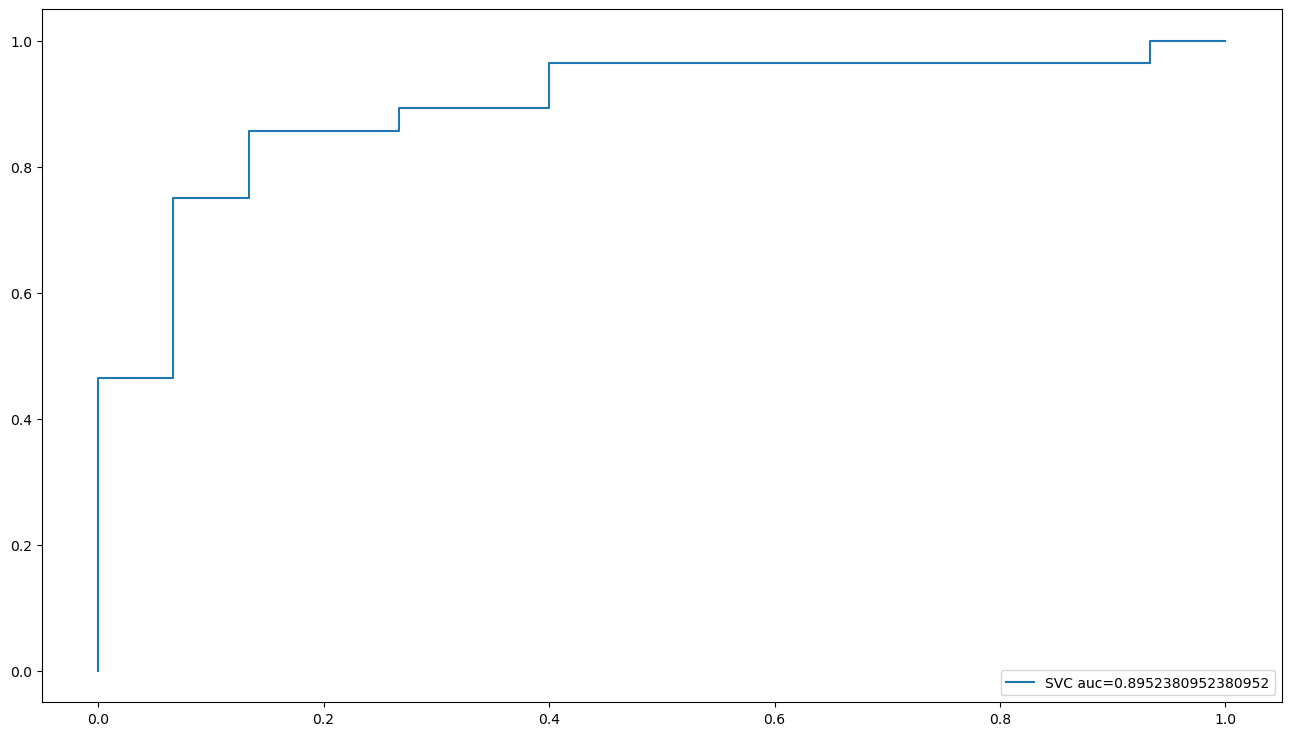

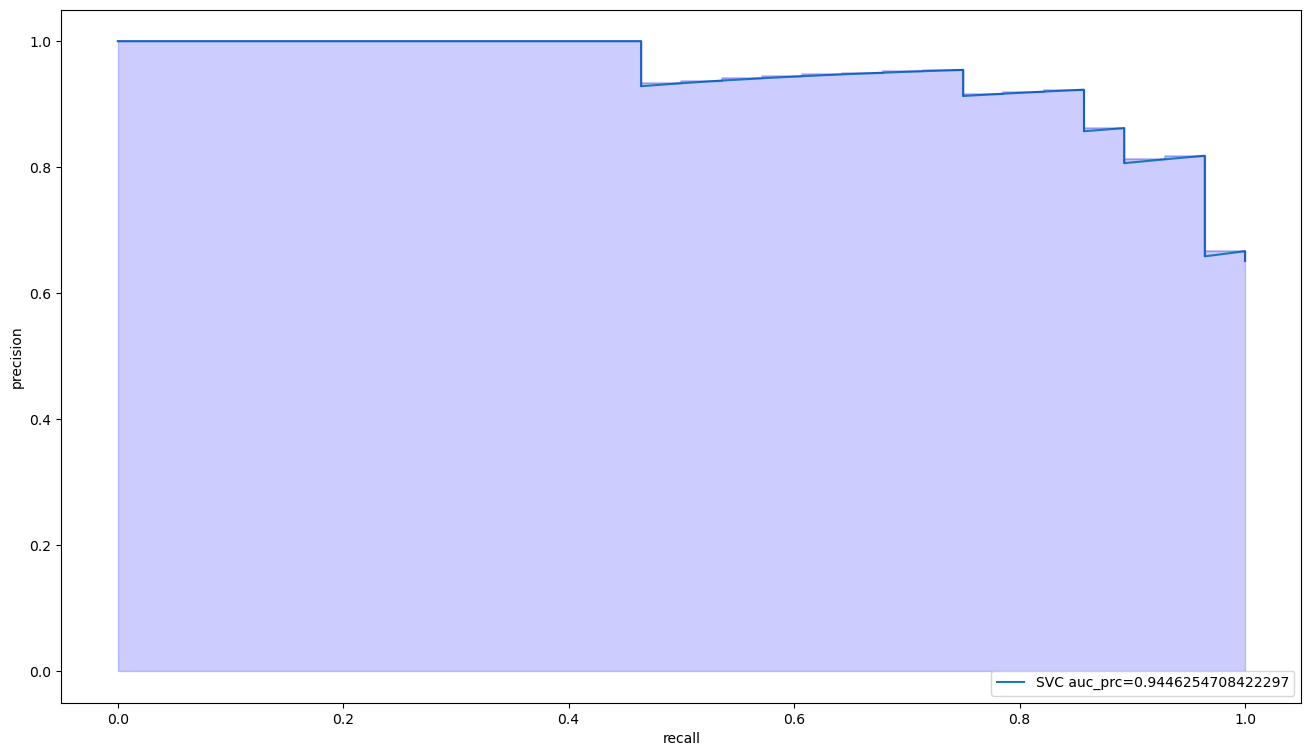

Train Result:
Accuracy Score: 84.12%
________________________________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.789474    0.867257  0.841176    0.828365      0.839804
recall      0.750000    0.890909  0.841176    0.820455      0.841176
f1-score    0.769231    0.878924  0.841176    0.824077      0.840209
support    60.000000  110.000000  0.841176  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[45 15]
 [12 98]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.750000   0.888889  0.837209   0.819444      0.840439
recall      0.800000   0.857143  0.837209   0.828571      0.837209
f1-score    0.774194   0.872727  0.837209   0.823460      0.838355
support    15.000000  28.000000  

In [46]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,svc.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, svc.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_filter)

clf_svc=print_auc(svc,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_filter,svc.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.01}
learning done in 0.11 seconds


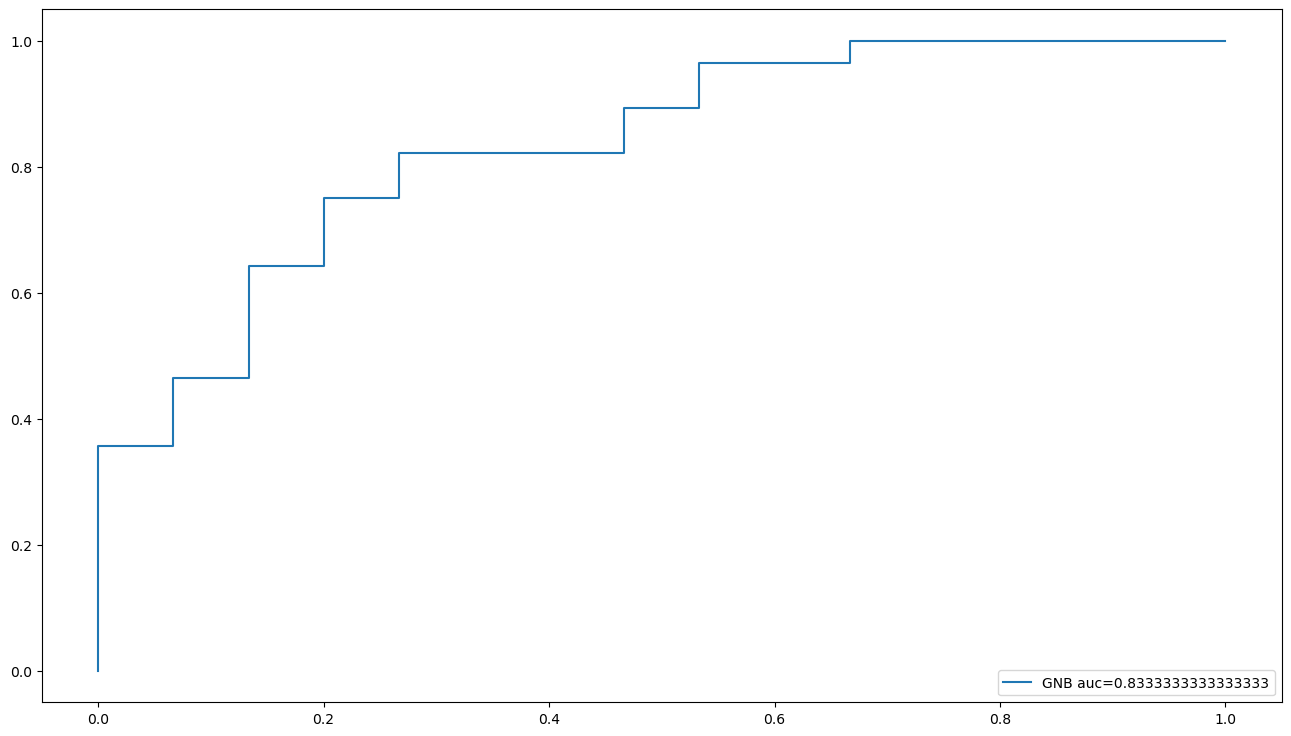

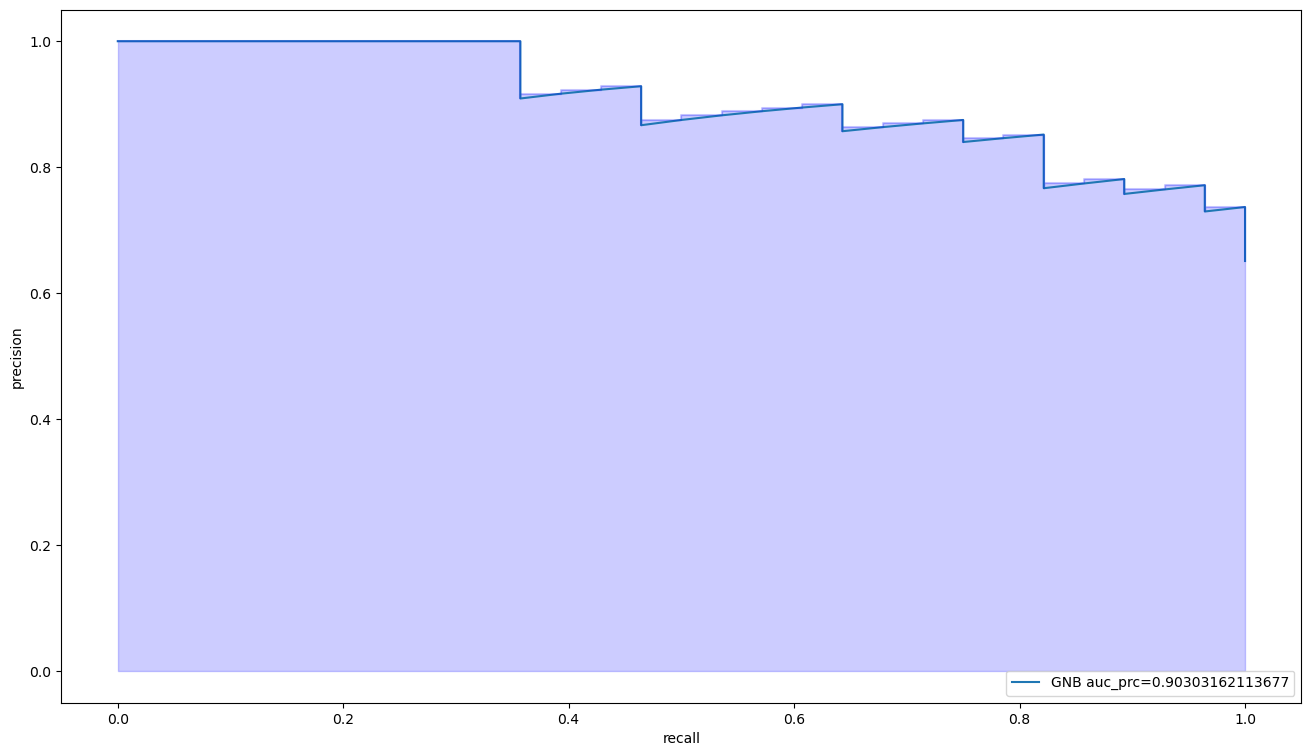

Train Result:
Accuracy Score: 78.24%
________________________________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.767442    0.787402  0.782353    0.777422      0.780357
recall      0.550000    0.909091  0.782353    0.729545      0.782353
f1-score    0.640777    0.843882  0.782353    0.742329      0.772198
support    60.000000  110.000000  0.782353  170.000000    170.000000
________________________________________________________________
Confusion Matrix: 
 [[ 33  27]
 [ 10 100]]

Test Result:
Accuracy Score: 76.74%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.666667   0.821429  0.767442   0.744048      0.767442
recall      0.666667   0.821429  0.767442   0.744048      0.767442
f1-score    0.666667   0.821429  0.767442   0.744048      0.767442
support    15.000000  28.0000

In [47]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,GNB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, GNB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_filter)

clf_gnb=print_auc(GNB,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_filter,GNB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 25, 'p': 2, 'weights': 'distance'}
learning done in 16.22 seconds


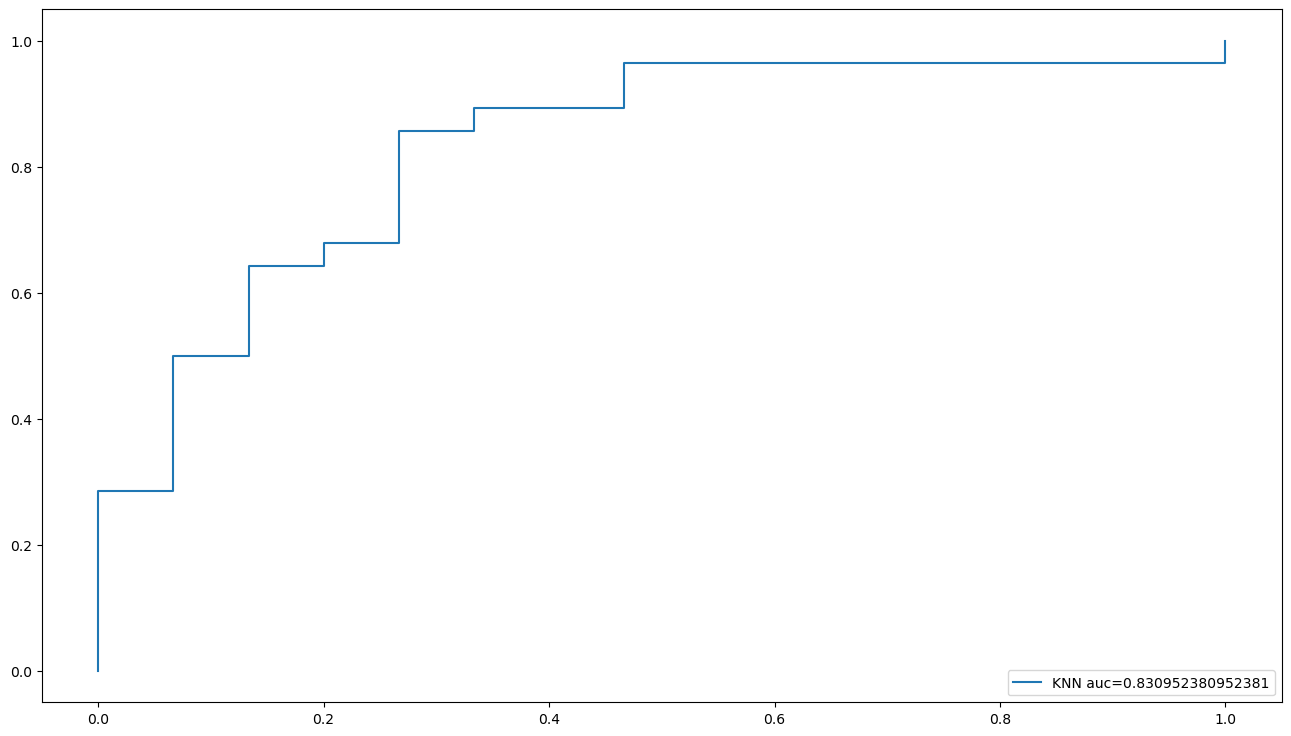

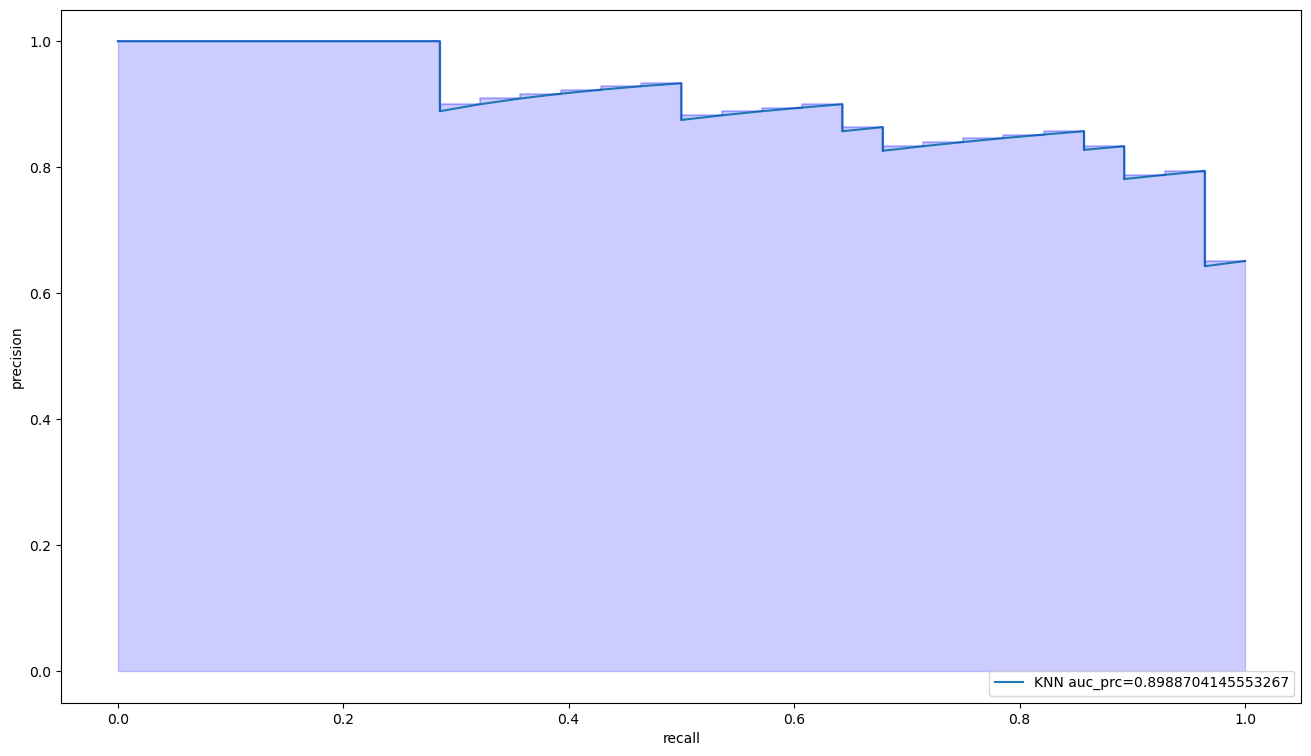

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    60.0  110.0       1.0      170.0         170.0
________________________________________________________________
Confusion Matrix: 
 [[ 60   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.714286   0.827586  0.790698   0.770936      0.788063
recall      0.666667   0.857143  0.790698   0.761905      0.790698
f1-score    0.689655   0.842105  0.790698   0.765880      0.788925
support    15.000000  28.000000  0.790698  43.000000     43.000000
________________

In [48]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter,y_train_filter)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_filter, y_train_filter) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,KNN.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, KNN.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_filter)

clf_knn=print_auc(KNN,X_train_filter,y_train_filter,X_test_filter,y_test_filter,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_filter,KNN.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## Save results

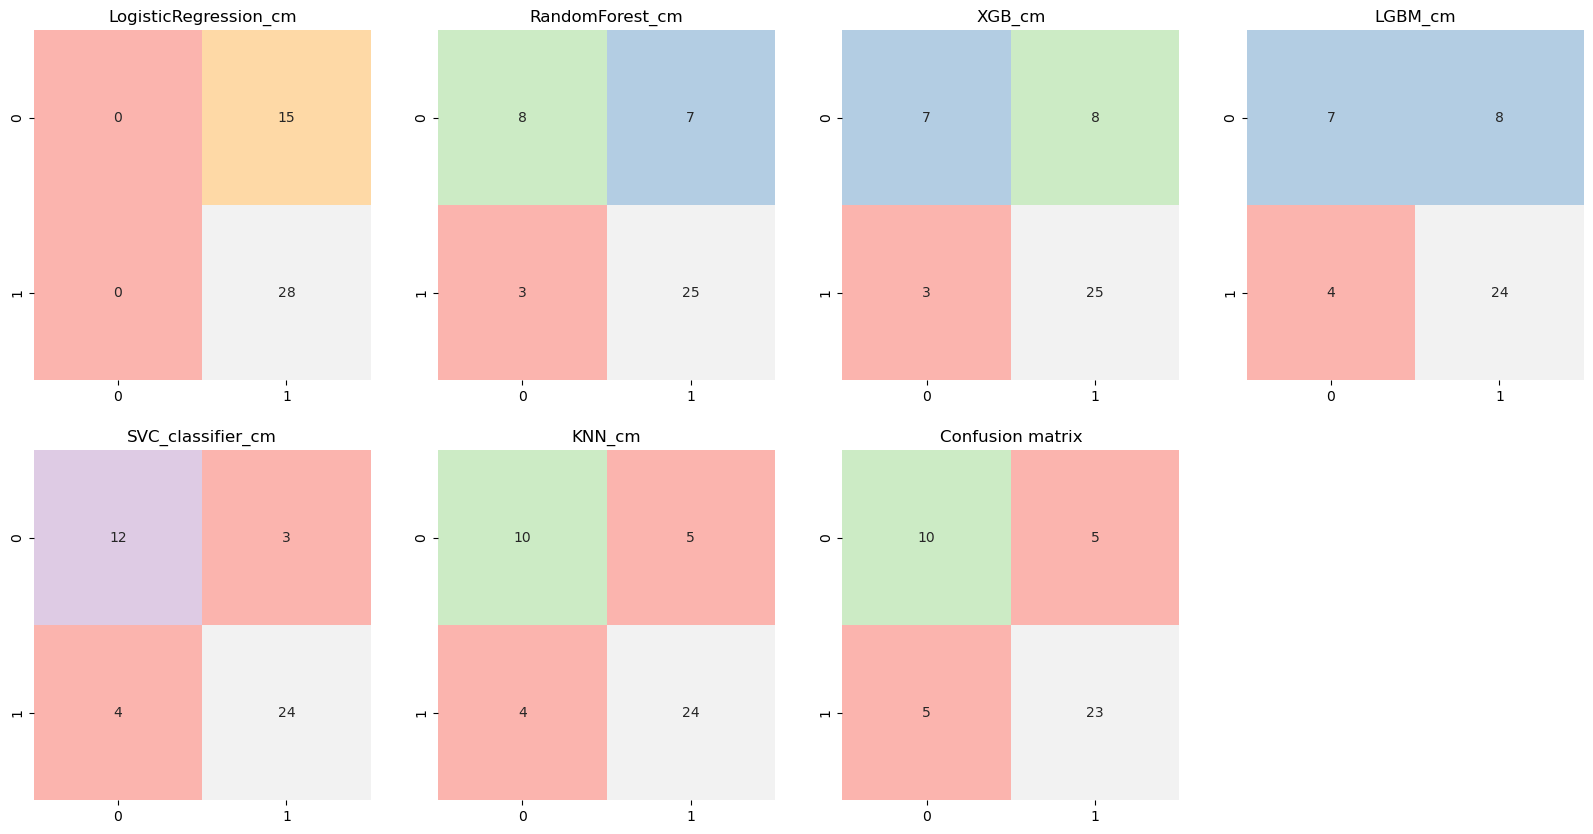

<Figure size 1600x900 with 0 Axes>

In [49]:
# Confusion matrix 
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.title("LogisticRegression_cm")
sns.heatmap(logistic_Reg_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,2)
plt.title("RandomForest_cm")
sns.heatmap(rdf_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,3)
plt.title("XGB_cm")
sns.heatmap(xgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,4)
plt.title("LGBM_cm")
sns.heatmap(lgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,5)
plt.title("SVC_classifier_cm")
sns.heatmap(svc_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,6)
plt.title("KNN_cm")
sns.heatmap(knn_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,7)
plt.title("GNM_cm")
sns.heatmap(gnb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)

plt.title('Confusion matrix')
plt.show()

plt.savefig('Confusion matrix for filter dataset (with no SMOTE)', dpi = 900)

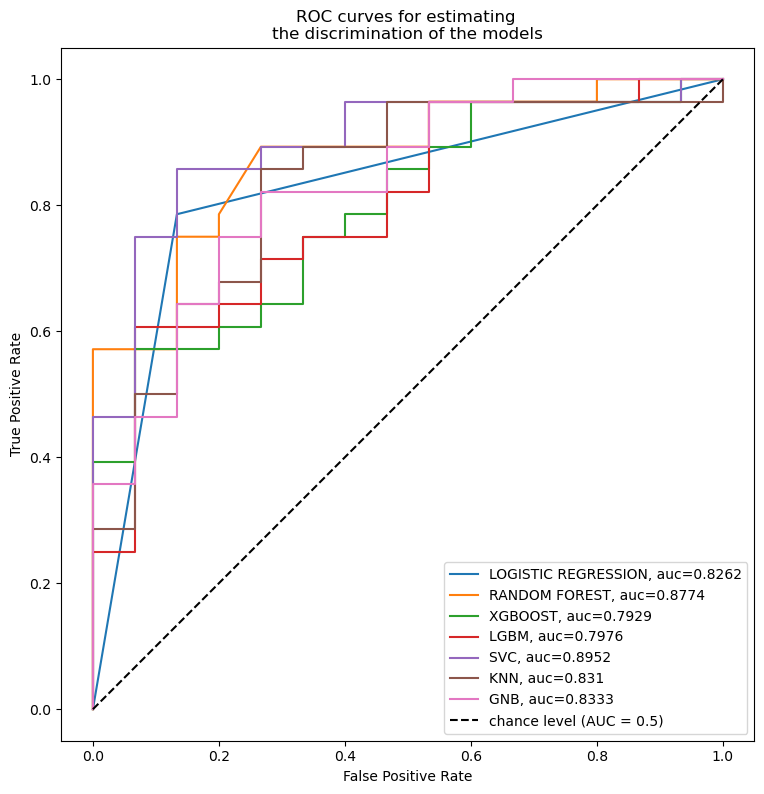

In [50]:
# plot AUC
plt.rcParams["figure.figsize"] = [16,9]

# plot the different model
plt.plot(logistic_Reg_clf["fpr"],logistic_Reg_clf["tpr"],label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc"],4)))
plt.plot(clf_rdf["fpr"],clf_rdf["tpr"],label="RANDOM FOREST, auc="+str(round(clf_rdf["auc"],4)))
plt.plot(clf_xgb["fpr"],clf_xgb["tpr"],label="XGBOOST, auc="+str(round(clf_xgb["auc"],4)))
plt.plot(clf_lgb["fpr"],clf_lgb["tpr"],label="LGBM, auc="+str(round(clf_lgb["auc"],4)))
plt.plot(clf_svc["fpr"],clf_svc["tpr"],label="SVC, auc="+str(round(clf_svc["auc"],4)))
plt.plot(clf_knn["fpr"],clf_knn["tpr"],label="KNN, auc="+str(round(clf_knn["auc"],4)))
plt.plot(clf_gnb["fpr"],clf_gnb["tpr"],label="GNB, auc="+str(round(clf_gnb["auc"],4)))

# Plot the median curve
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for estimating \nthe discrimination of the models")
plt.legend()
plt.style.use('fast')

plt.legend(loc=4)
plt.savefig('ROC AUC for filtered dataset (with no SMOTE).png', dpi = 900)
plt.show()


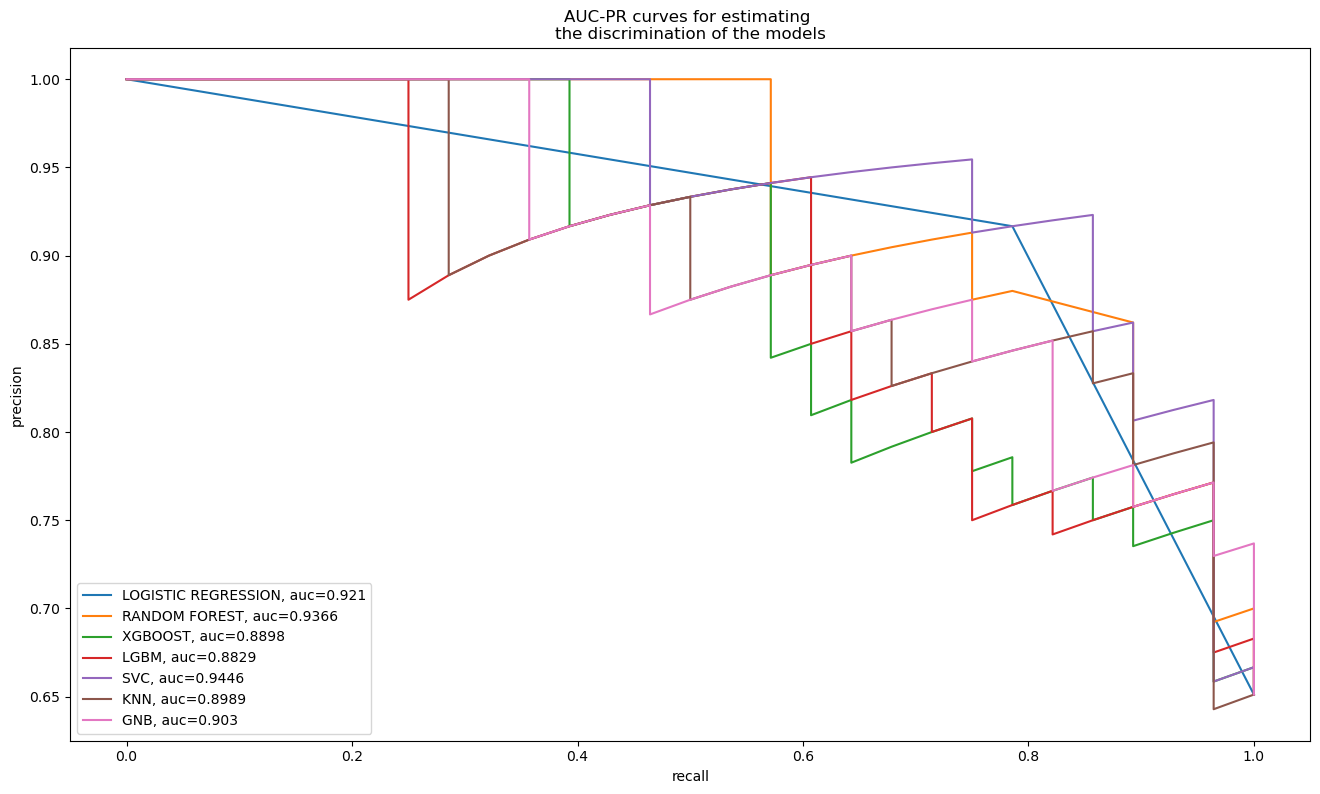

In [51]:
# Plot AUC_PR
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(logistic_Reg_clf["recall"],logistic_Reg_clf["precision"], label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc_pr"],4)))
plt.plot(clf_rdf["recall"],clf_rdf["precision"], label="RANDOM FOREST, auc="+str(round(clf_rdf["auc_pr"],4)))
plt.plot(clf_xgb["recall"],clf_xgb["precision"],label="XGBOOST, auc="+str(round(clf_xgb["auc_pr"],4)))
plt.plot(clf_lgb["recall"],clf_lgb["precision"],label="LGBM, auc="+str(round(clf_lgb["auc_pr"],4)))
plt.plot(clf_svc["recall"],clf_svc["precision"],label="SVC, auc="+str(round(clf_svc["auc_pr"],4)))
plt.plot(clf_knn["recall"],clf_knn["precision"],label="KNN, auc="+str(round(clf_knn["auc_pr"],4)))
plt.plot(clf_gnb["recall"],clf_gnb["precision"],label="GNB, auc="+str(round(clf_gnb["auc_pr"],4)))

plt.style.use('fast')
plt.title("AUC-PR curves for estimating \nthe discrimination of the models")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=3)
plt.savefig('AUC PR for filtered dataset (with no SMOTE).png', dpi = 900)
plt.show()

In [52]:
results_df.to_csv('Results for filtered dataset (with no SMOTE).csv', index=True)

# MODELS FOR SMOTE DATASET (WITH NO FILTERING)

## 1. Logistic regression (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 16.10 seconds


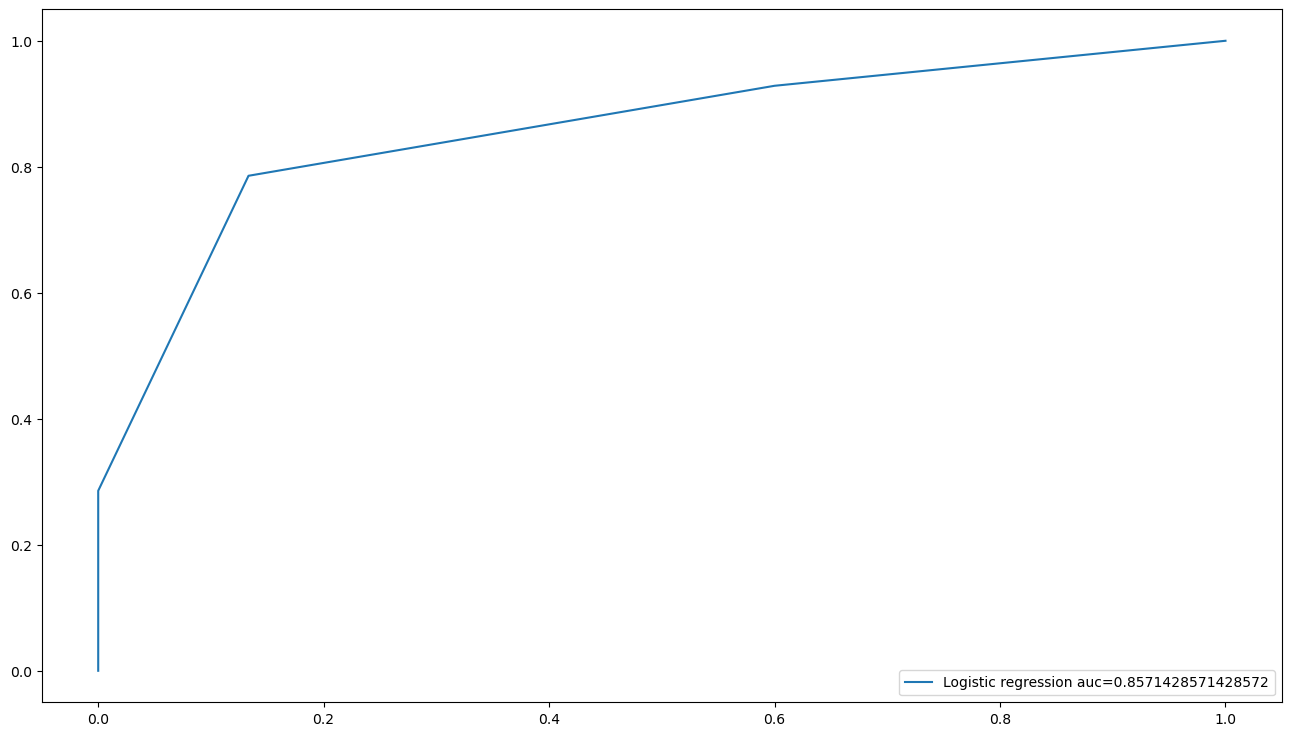

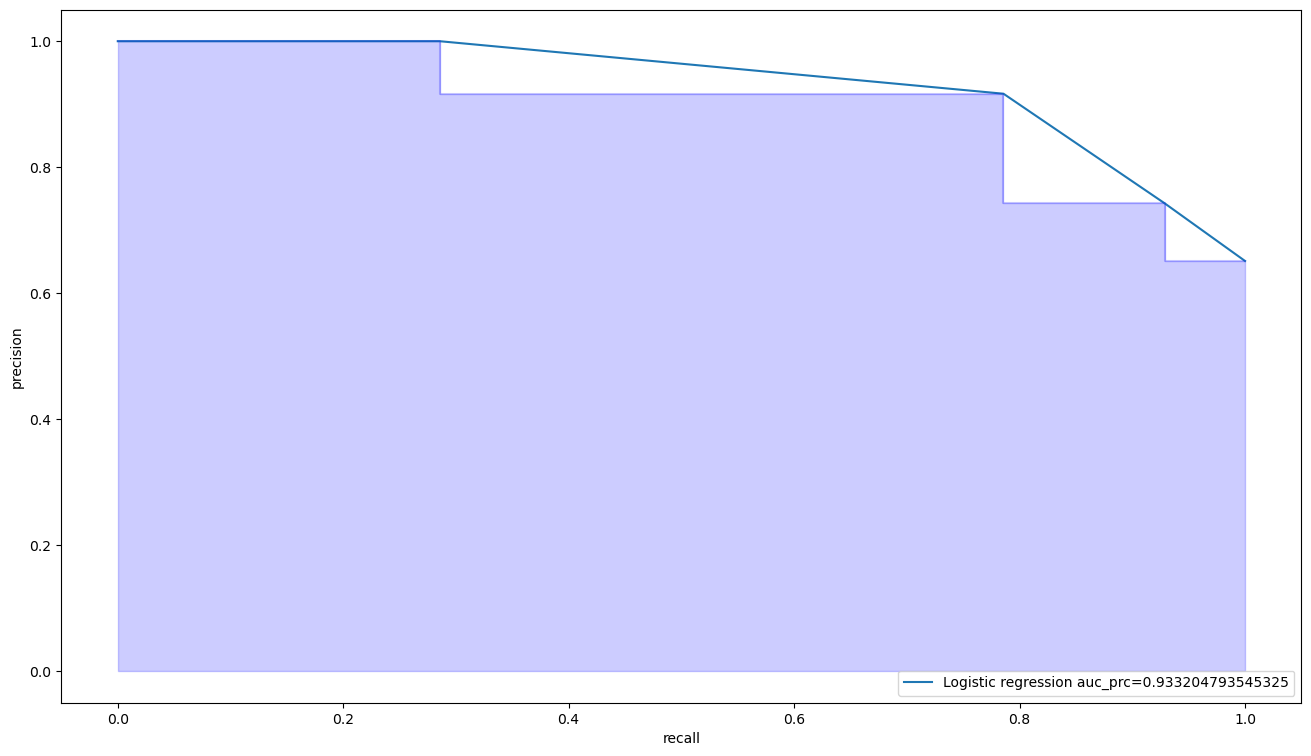

Train Result:
Accuracy Score: 73.64%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.770833    0.709677  0.736364    0.740255      0.740255
recall       0.672727    0.800000  0.736364    0.736364      0.736364
f1-score     0.718447    0.752137  0.736364    0.735292      0.735292
support    110.000000  110.000000  0.736364  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[74 36]
 [22 88]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.684211   0.916667  0.813953   0.800439      0.835577
recall      0.866667   0.785714  0.813953   0.826190      0.813953
f1-score    0.764706   0.846154  0.813953   0.805430      0.817742
support    15.000000  28.000

In [53]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,logistic_Reg.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, logistic_Reg.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_nofilter)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_nofilter,logistic_Reg.predict(X_test_nofilter))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 101.81 seconds


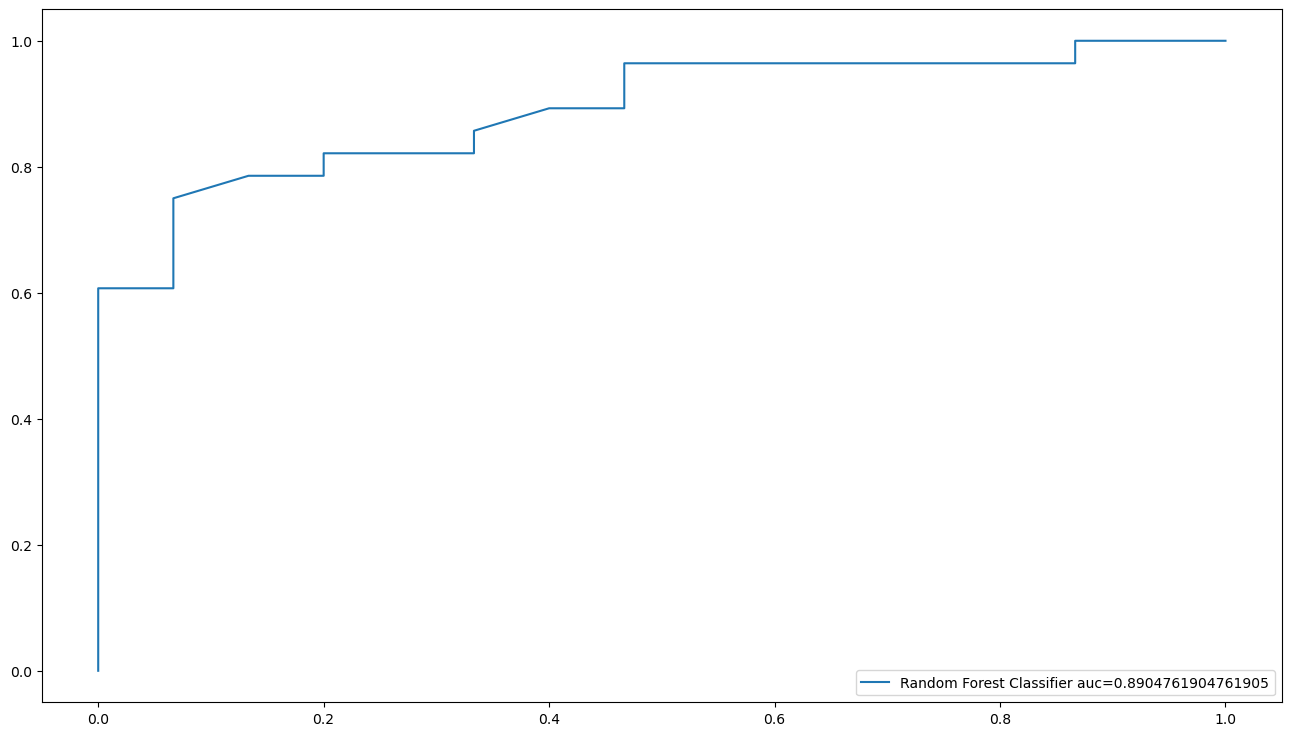

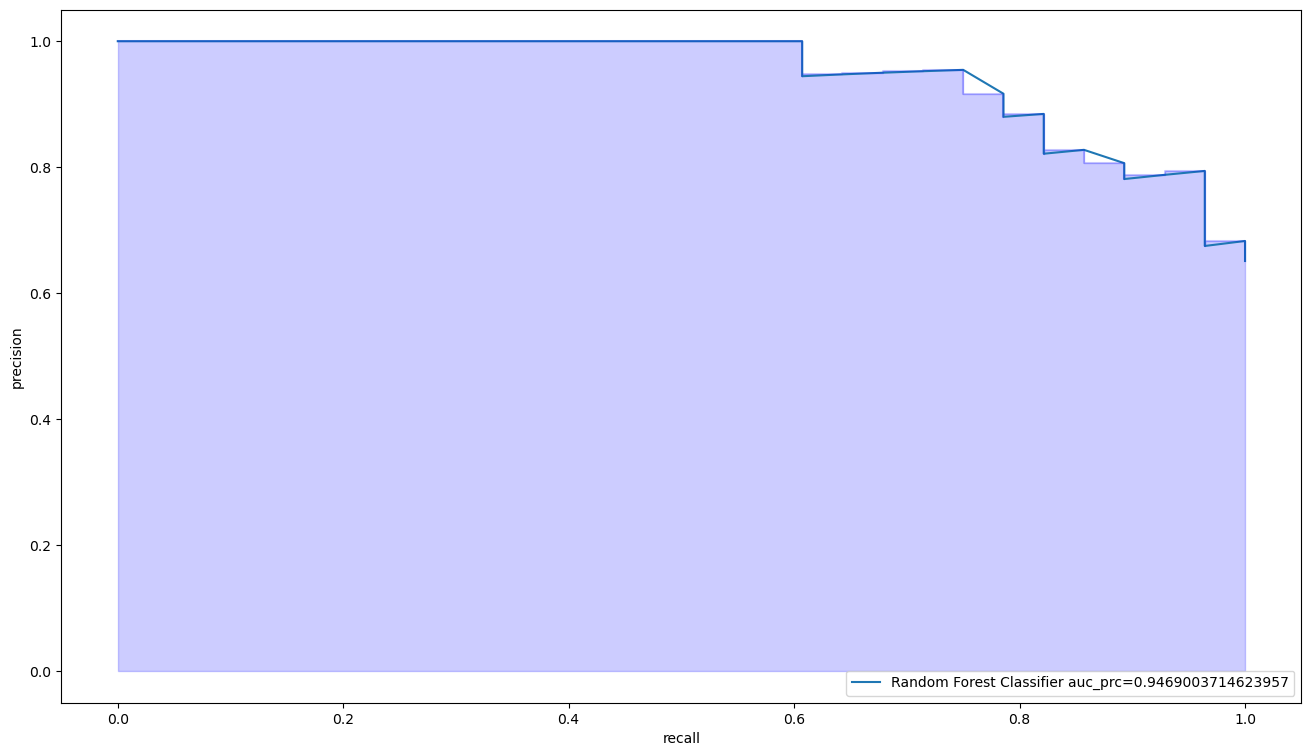

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.750000   0.806452  0.790698   0.778226      0.786759
recall      0.600000   0.892857  0.790698   0.746429      0.790698
f1-score    0.666667   0.847458  0.790698   0.757062      0.784391
support    15.000000  28.000000  0.790698  43.000000     43.000000
___________

In [54]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,RFC.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, RFC.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_nofilter)

clf_rdf=print_auc(RFC,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_nofilter,RFC.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 70.88 seconds


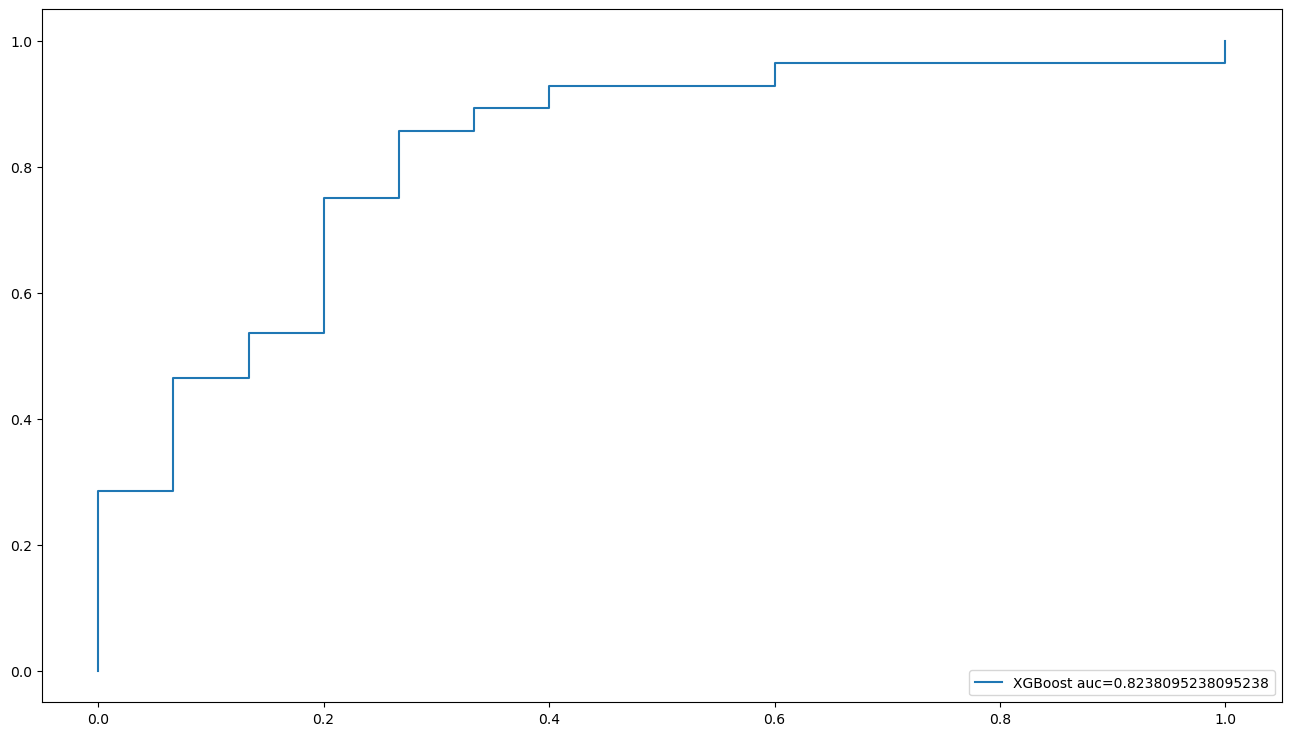

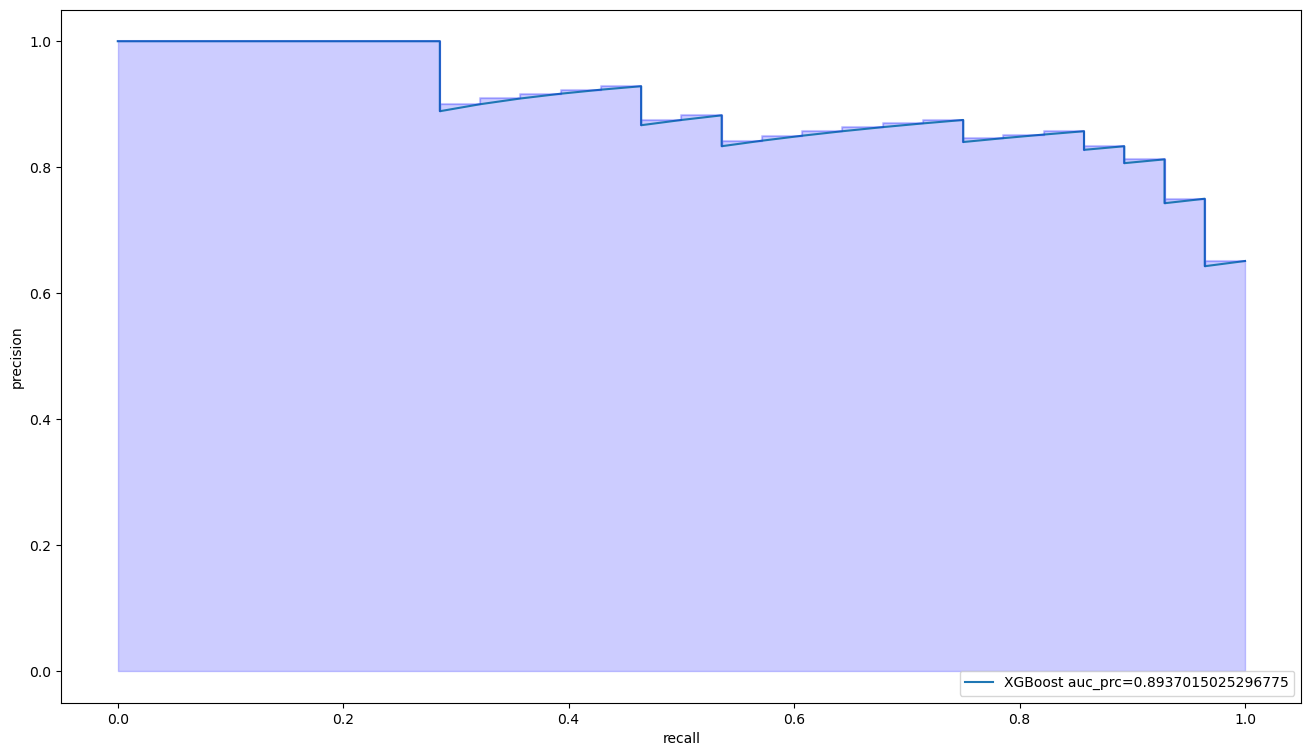

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.769231   0.833333  0.813953   0.801282      0.810972
recall      0.666667   0.892857  0.813953   0.779762      0.813953
f1-score    0.714286   0.862069  0.813953   0.788177      0.810517
support    15.000000  28.000000  0.813953  43.000000     43.000000
___________

In [55]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,XGB.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, XGB.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_nofilter)

clf_xgb=print_auc(XGB,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_nofilter,XGB.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 175.55 seconds


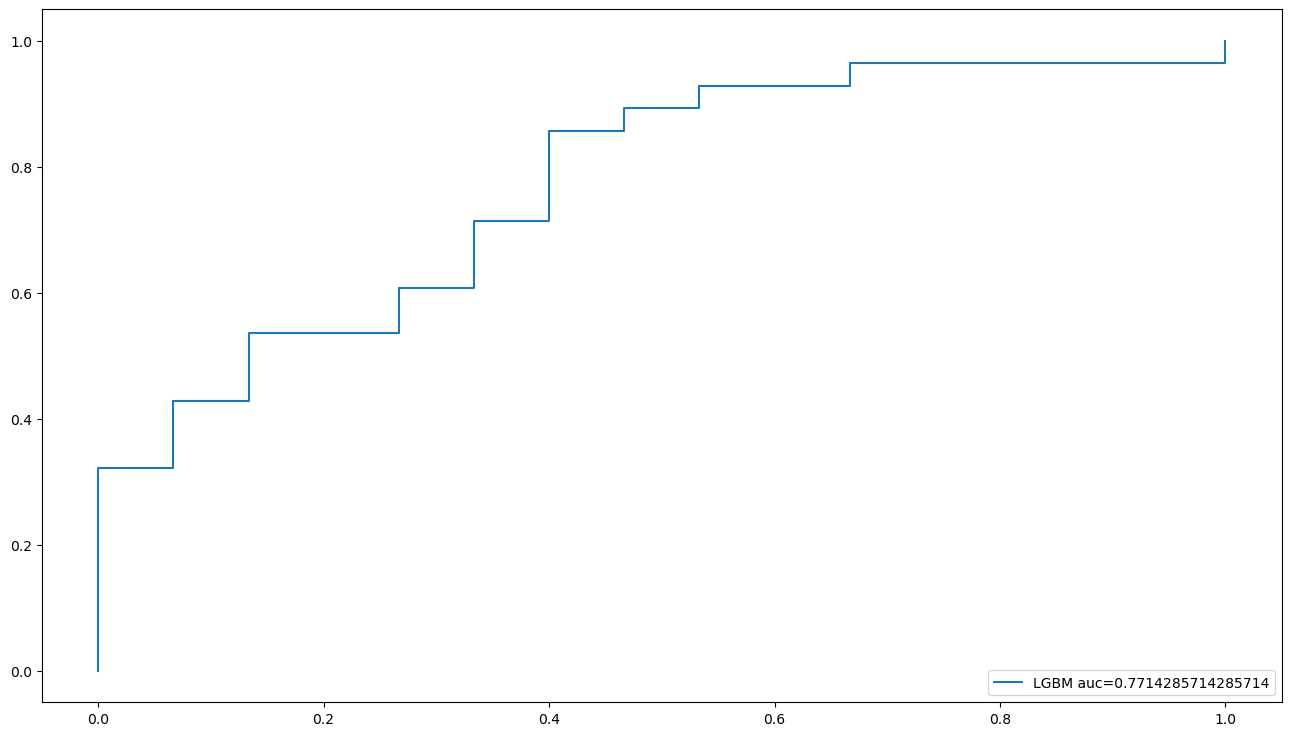

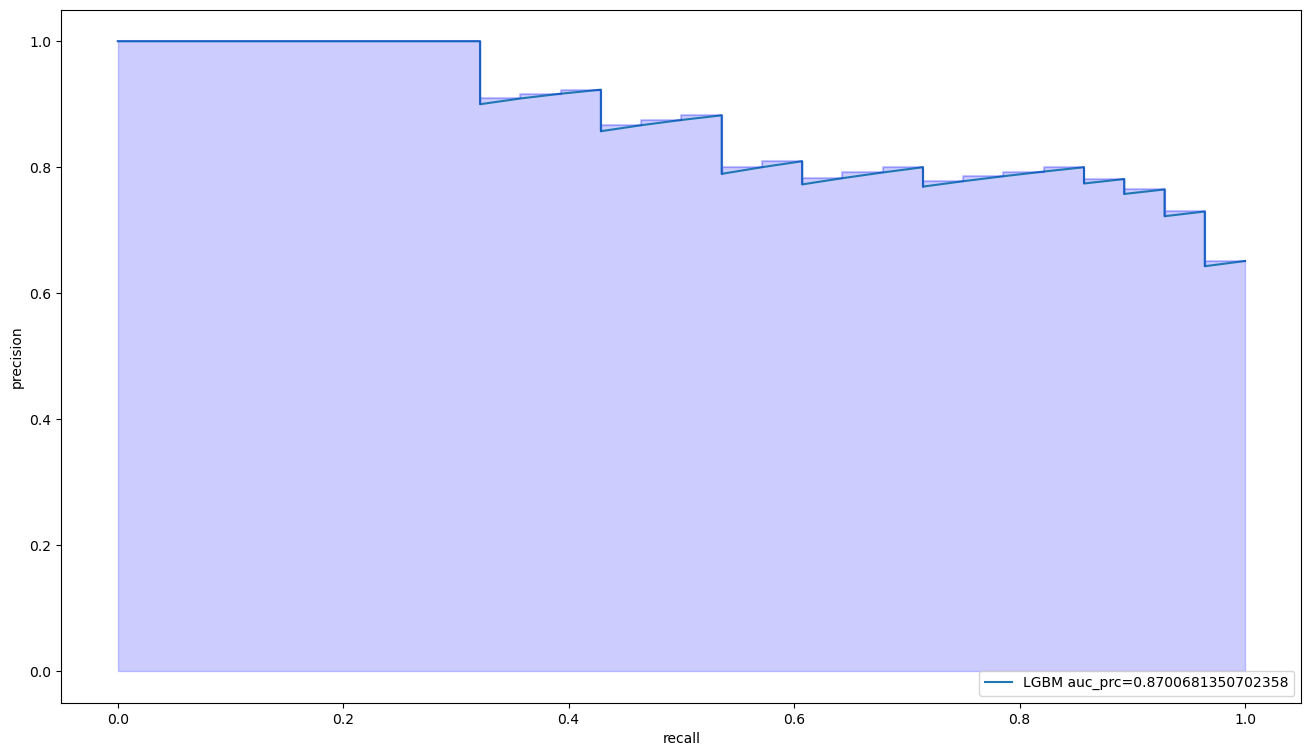

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.642857   0.793103  0.744186   0.717980      0.740692
recall      0.600000   0.821429  0.744186   0.710714      0.744186
f1-score    0.620690   0.807018  0.744186   0.713854      0.742019
support    15.000000  28.000000  0.744186  43.000000     43.000000
___________

In [56]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,LGB.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, LGB.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_nofilter)

clf_lgb=print_auc(LGB,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_nofilter,LGB.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.88 seconds


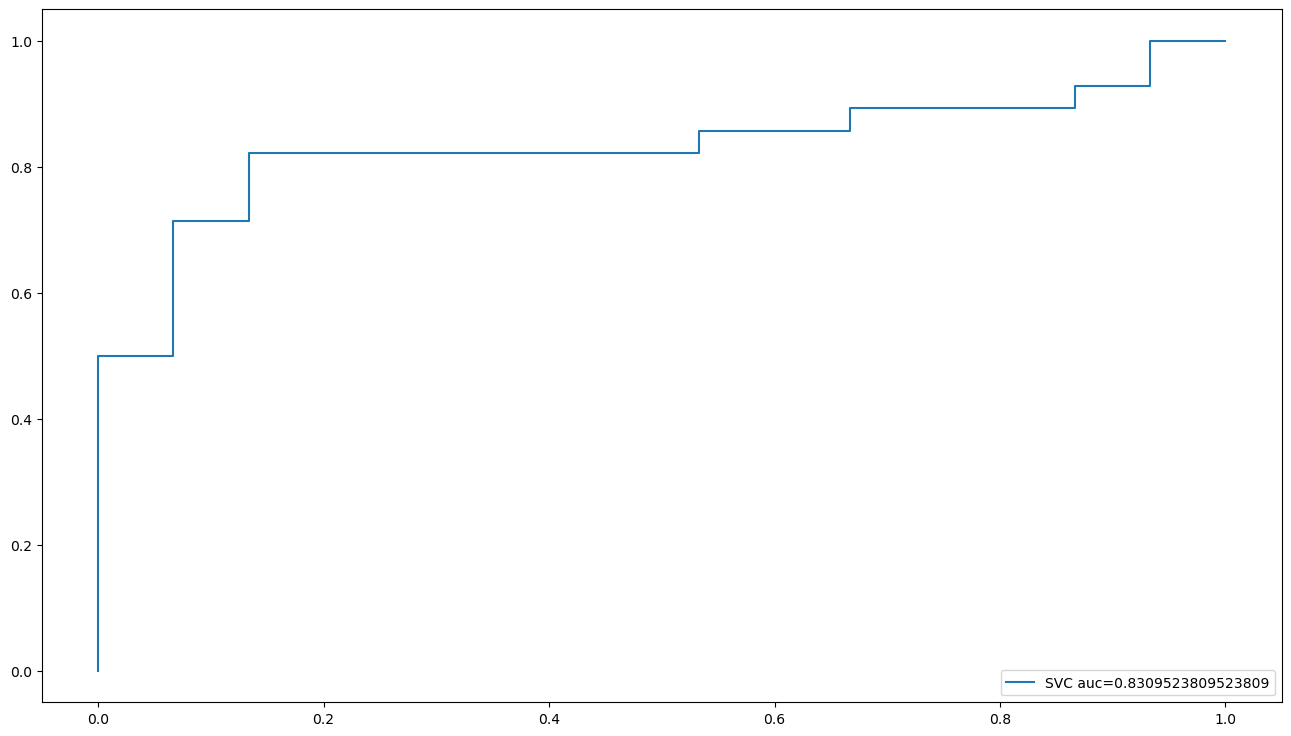

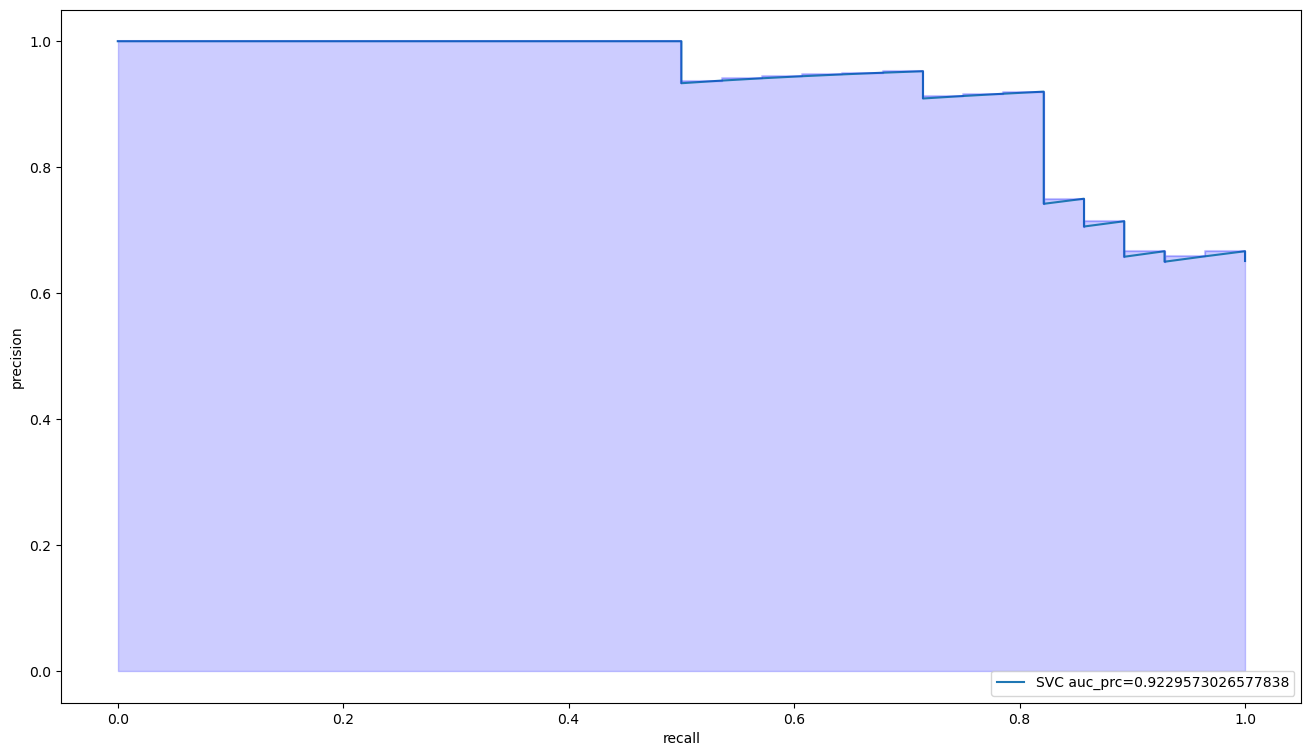

Train Result:
Accuracy Score: 92.73%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.935185    0.919643  0.927273    0.927414      0.927414
recall       0.918182    0.936364  0.927273    0.927273      0.927273
f1-score     0.926606    0.927928  0.927273    0.927267      0.927267
support    110.000000  110.000000  0.927273  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[101   9]
 [  7 103]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.684211   0.916667  0.813953   0.800439      0.835577
recall      0.866667   0.785714  0.813953   0.826190      0.813953
f1-score    0.764706   0.846154  0.813953   0.805430      0.817742
support    15.000000  28

In [57]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,svc.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, svc.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_nofilter)

clf_svc=print_auc(svc,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_nofilter,svc.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 1e-10}
learning done in 0.16 seconds


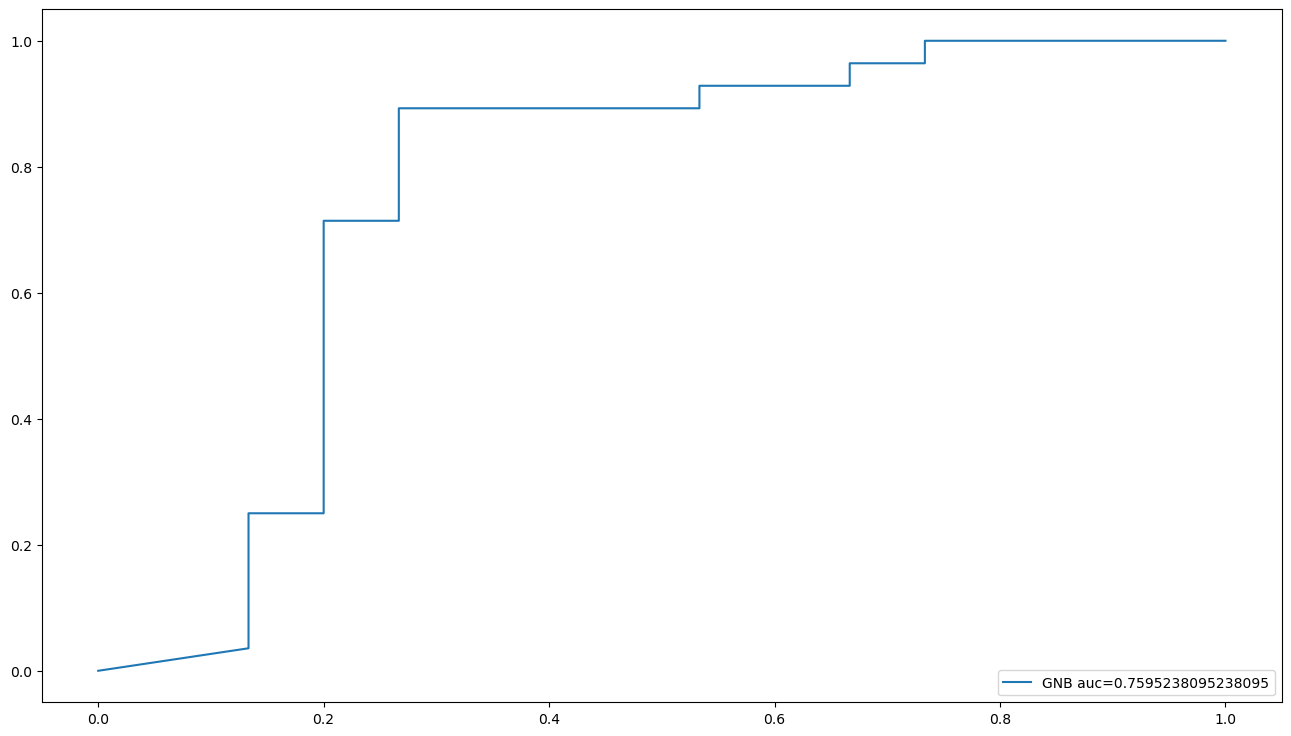

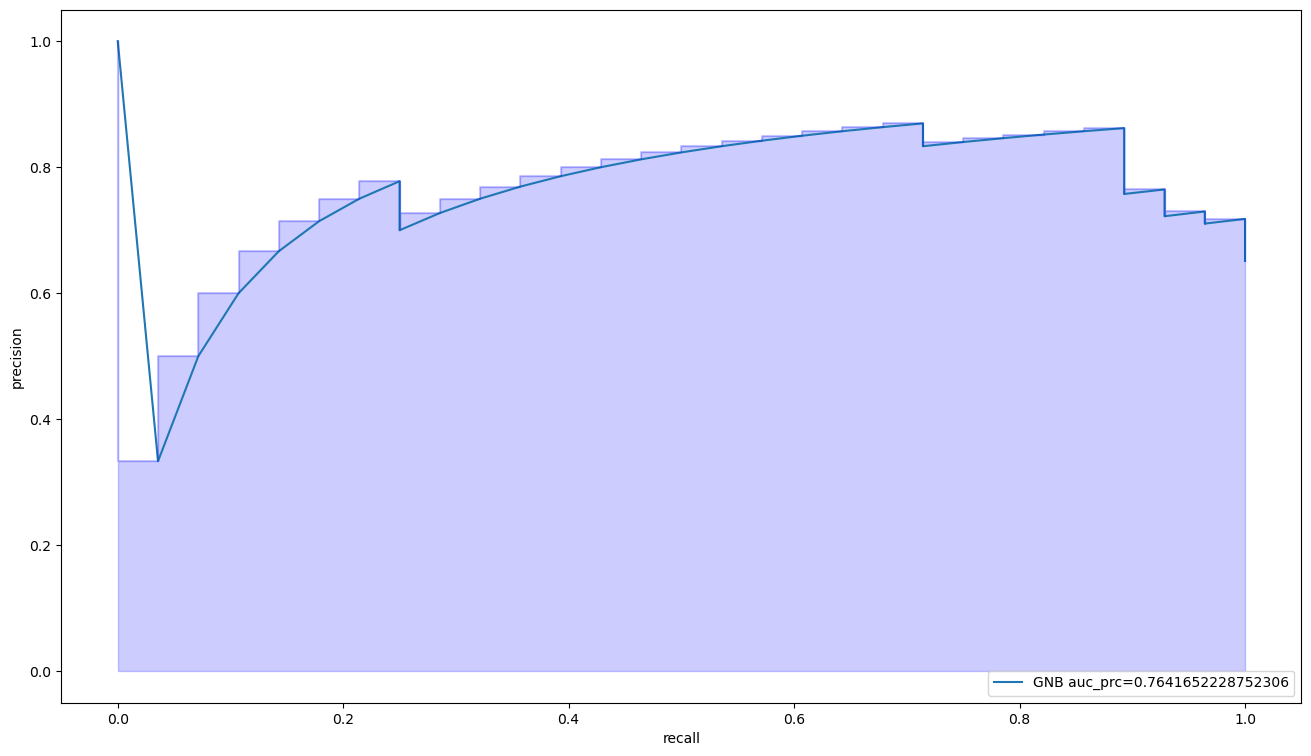

Train Result:
Accuracy Score: 55.91%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.532020    0.882353  0.559091    0.707186      0.707186
recall       0.981818    0.136364  0.559091    0.559091      0.559091
f1-score     0.690096    0.236220  0.559091    0.463158      0.463158
support    110.000000  110.000000  0.559091  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[108   2]
 [ 95  15]]

Test Result:
Accuracy Score: 41.86%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.361111   0.714286  0.418605   0.537698      0.591085
recall      0.866667   0.178571  0.418605   0.522619      0.418605
f1-score    0.509804   0.285714  0.418605   0.397759      0.363885
support    15.000000  28

In [58]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,GNB.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, GNB.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_nofilter)

clf_gnb=print_auc(GNB,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_nofilter,GNB.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
learning done in 15.98 seconds


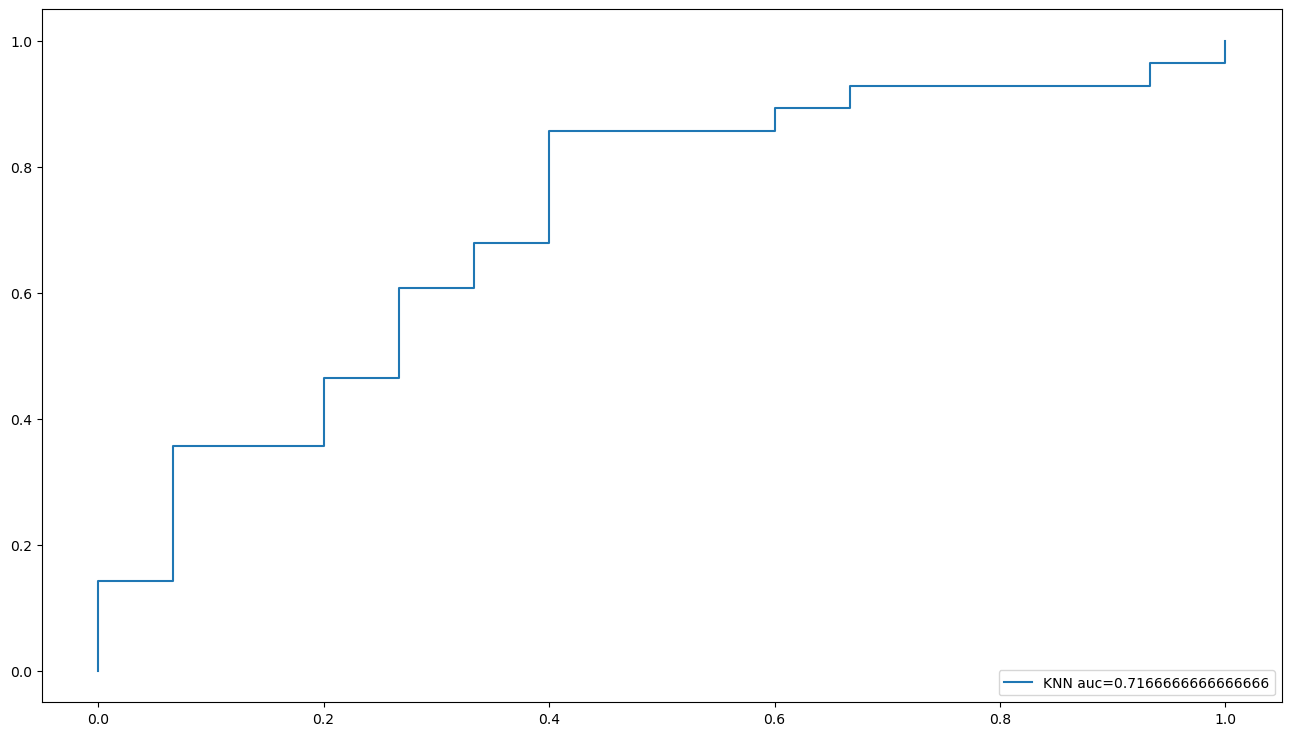

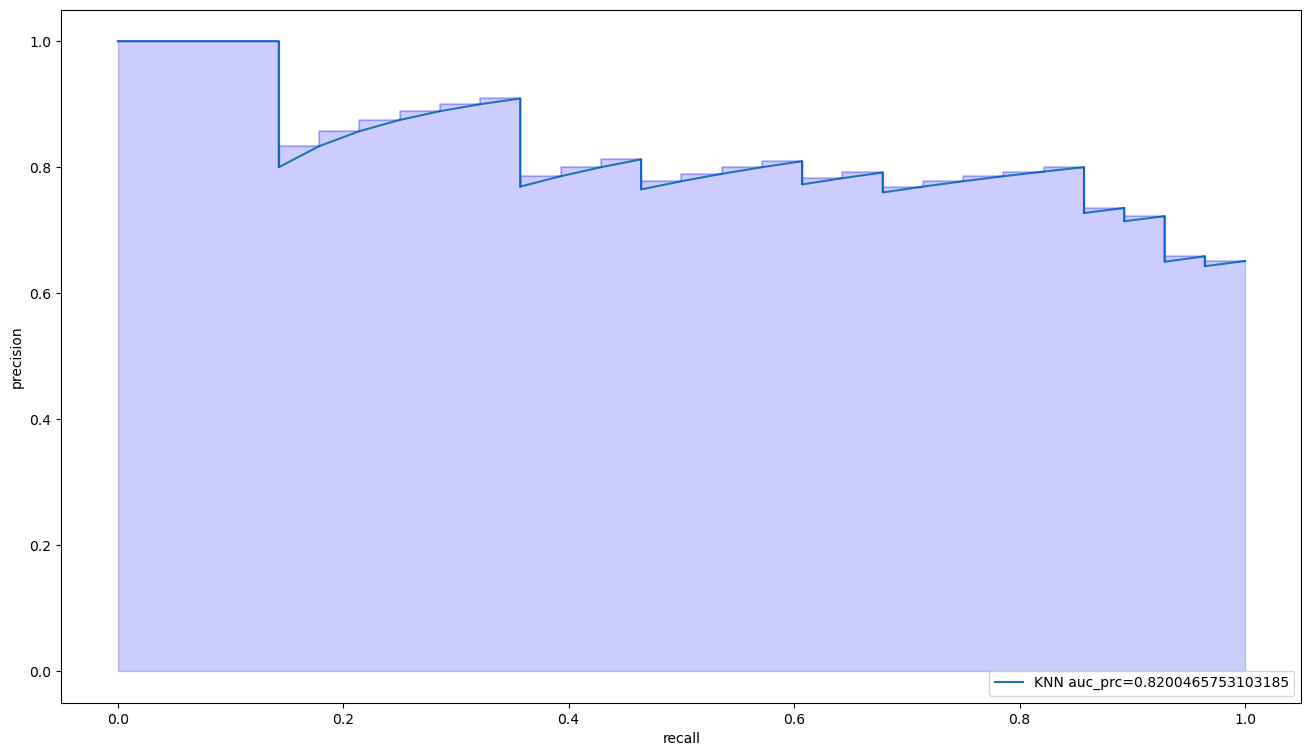

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 55.81%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.428571   0.800000   0.55814   0.614286      0.670432
recall      0.800000   0.428571   0.55814   0.614286      0.558140
f1-score    0.558140   0.558140   0.55814   0.558140      0.558140
support    15.000000  28.000000   0.55814  43.000000     43.000000
___________

In [59]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_nf_smote,y_train_nf_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_nf_smote, y_train_nf_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_nofilter,KNN.predict_proba(X_test_nofilter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_nofilter, KNN.predict_proba(X_test_nofilter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_nofilter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_nofilter)

clf_knn=print_auc(KNN,X_train_nf_smote,y_train_nf_smote,X_test_nofilter,y_test_nofilter,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_nofilter,KNN.predict(X_test_nofilter))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## Save the results

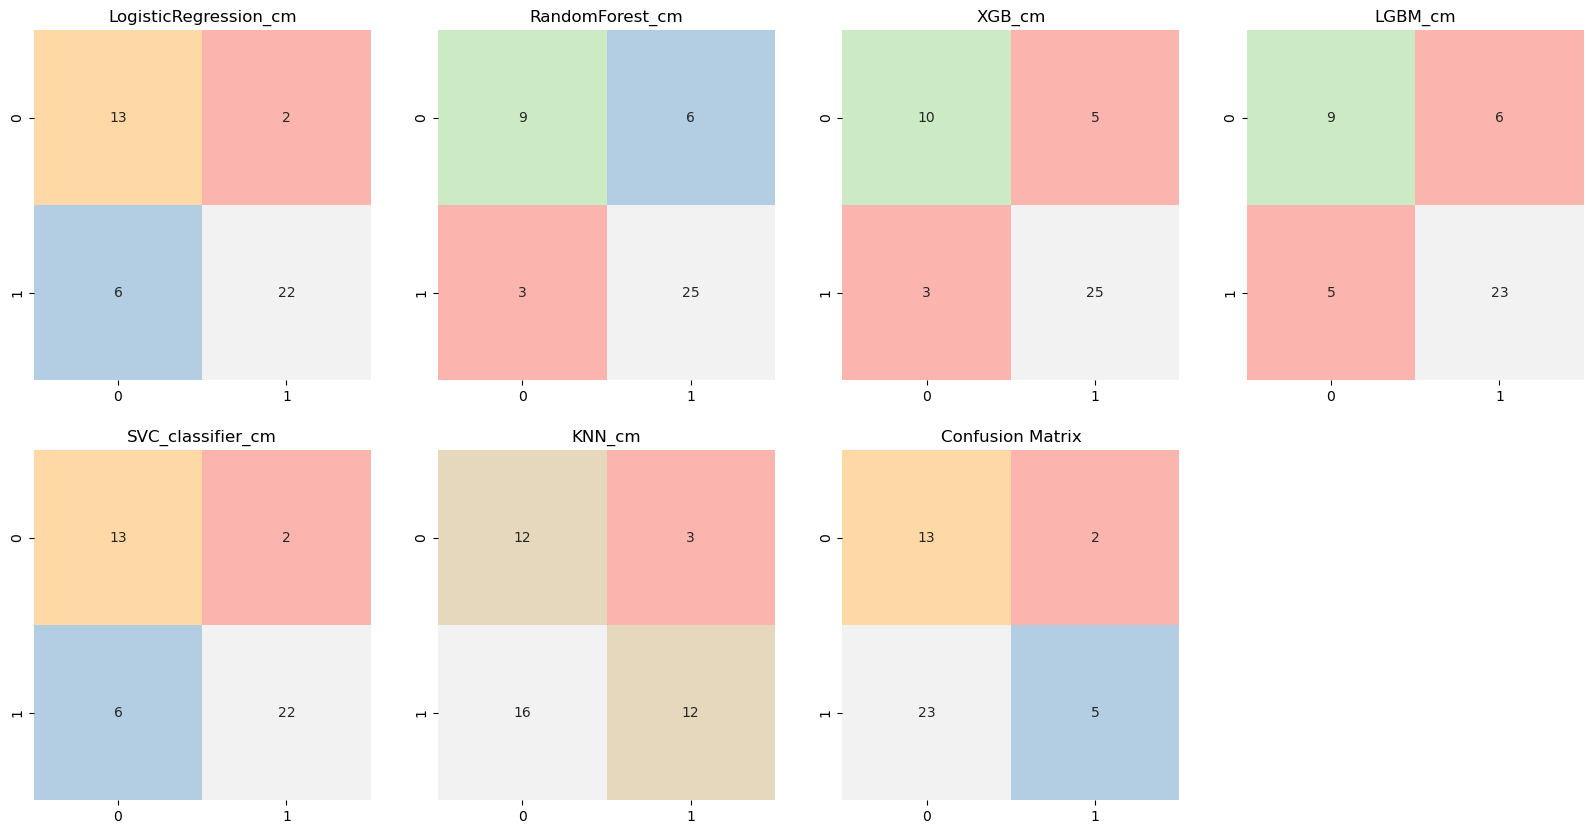

<Figure size 1600x900 with 0 Axes>

In [60]:
# Confusion matrix 
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.title("LogisticRegression_cm")
sns.heatmap(logistic_Reg_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,2)
plt.title("RandomForest_cm")
sns.heatmap(rdf_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,3)
plt.title("XGB_cm")
sns.heatmap(xgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,4)
plt.title("LGBM_cm")
sns.heatmap(lgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,5)
plt.title("SVC_classifier_cm")
sns.heatmap(svc_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,6)
plt.title("KNN_cm")
sns.heatmap(knn_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,7)
plt.title("GNM_cm")
sns.heatmap(gnb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)

plt.title("Confusion Matrix")
plt.show()

plt.savefig('Confusion matrix for SMOTE dataset (with no filter)', dpi = 900)

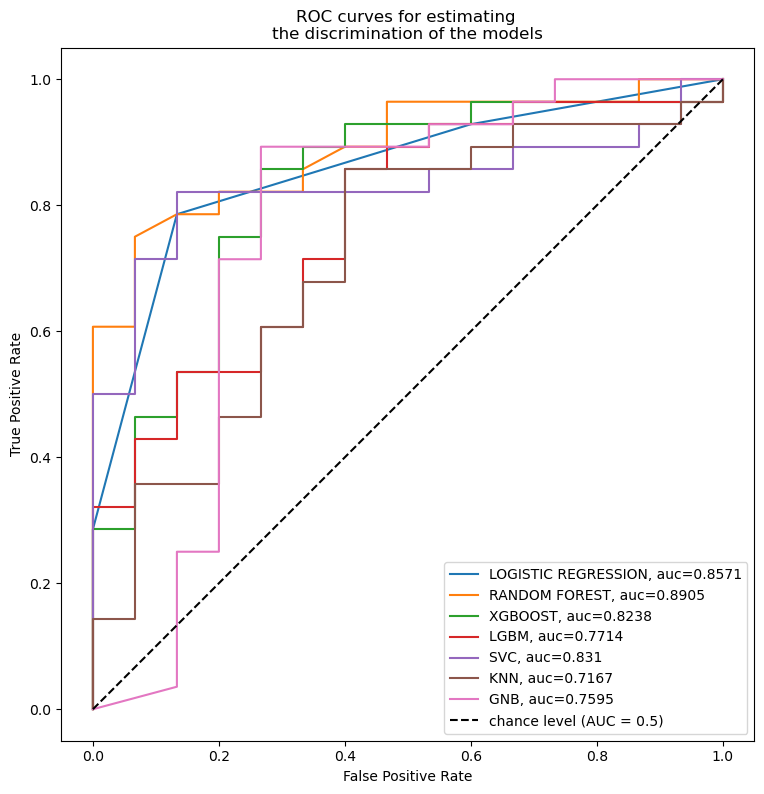

In [61]:
# plot AUC
plt.rcParams["figure.figsize"] = [16,9]

# plot the different model
plt.plot(logistic_Reg_clf["fpr"],logistic_Reg_clf["tpr"],label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc"],4)))
plt.plot(clf_rdf["fpr"],clf_rdf["tpr"],label="RANDOM FOREST, auc="+str(round(clf_rdf["auc"],4)))
plt.plot(clf_xgb["fpr"],clf_xgb["tpr"],label="XGBOOST, auc="+str(round(clf_xgb["auc"],4)))
plt.plot(clf_lgb["fpr"],clf_lgb["tpr"],label="LGBM, auc="+str(round(clf_lgb["auc"],4)))
plt.plot(clf_svc["fpr"],clf_svc["tpr"],label="SVC, auc="+str(round(clf_svc["auc"],4)))
plt.plot(clf_knn["fpr"],clf_knn["tpr"],label="KNN, auc="+str(round(clf_knn["auc"],4)))
plt.plot(clf_gnb["fpr"],clf_gnb["tpr"],label="GNB, auc="+str(round(clf_gnb["auc"],4)))

# Plot the median curve
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for estimating \nthe discrimination of the models")
plt.legend()
plt.style.use('fast')

plt.legend(loc=4)
plt.savefig('ROC AUC for SMOTE dataset (with no Filter).png', dpi = 900)
plt.show()


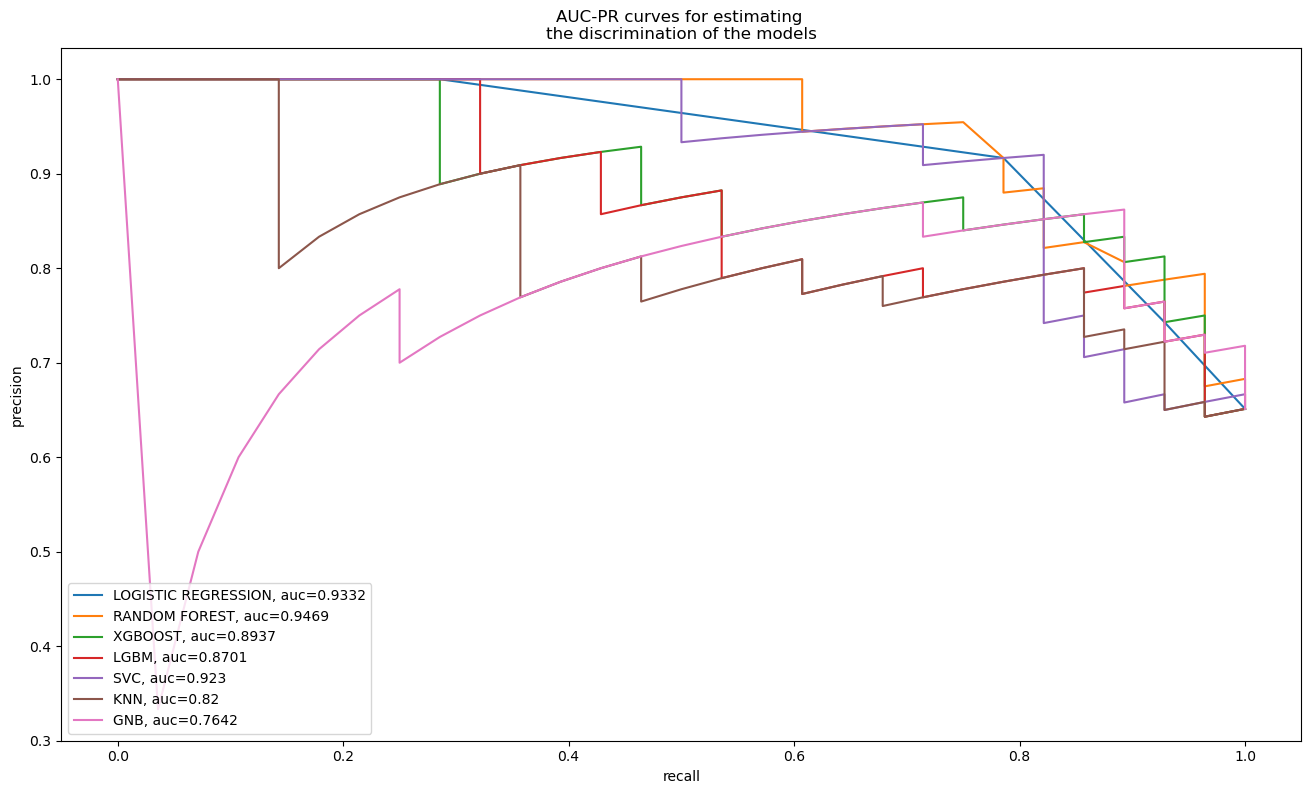

In [62]:
# Plot AUC_PR
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(logistic_Reg_clf["recall"],logistic_Reg_clf["precision"], label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc_pr"],4)))

plt.plot(clf_rdf["recall"],clf_rdf["precision"], label="RANDOM FOREST, auc="+str(round(clf_rdf["auc_pr"],4)))

plt.plot(clf_xgb["recall"],clf_xgb["precision"],label="XGBOOST, auc="+str(round(clf_xgb["auc_pr"],4)))

plt.plot(clf_lgb["recall"],clf_lgb["precision"],label="LGBM, auc="+str(round(clf_lgb["auc_pr"],4)))

plt.plot(clf_svc["recall"],clf_svc["precision"],label="SVC, auc="+str(round(clf_svc["auc_pr"],4)))

plt.plot(clf_knn["recall"],clf_knn["precision"],label="KNN, auc="+str(round(clf_knn["auc_pr"],4)))

plt.plot(clf_gnb["recall"],clf_gnb["precision"],label="GNB, auc="+str(round(clf_gnb["auc_pr"],4)))

plt.style.use('fast')
plt.title("AUC-PR curves for estimating \nthe discrimination of the models")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=3)
plt.savefig('AUC PR for SMOTE dataset (with no filter).png', dpi = 900)
plt.show()

In [63]:
results_df.to_csv('results for SMOTE dataset (with no filter).csv', index=True)

# MODELS FOR FULL DATASET (with filter and SMOTE)

## 1. Logistic regression (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 6.71 seconds


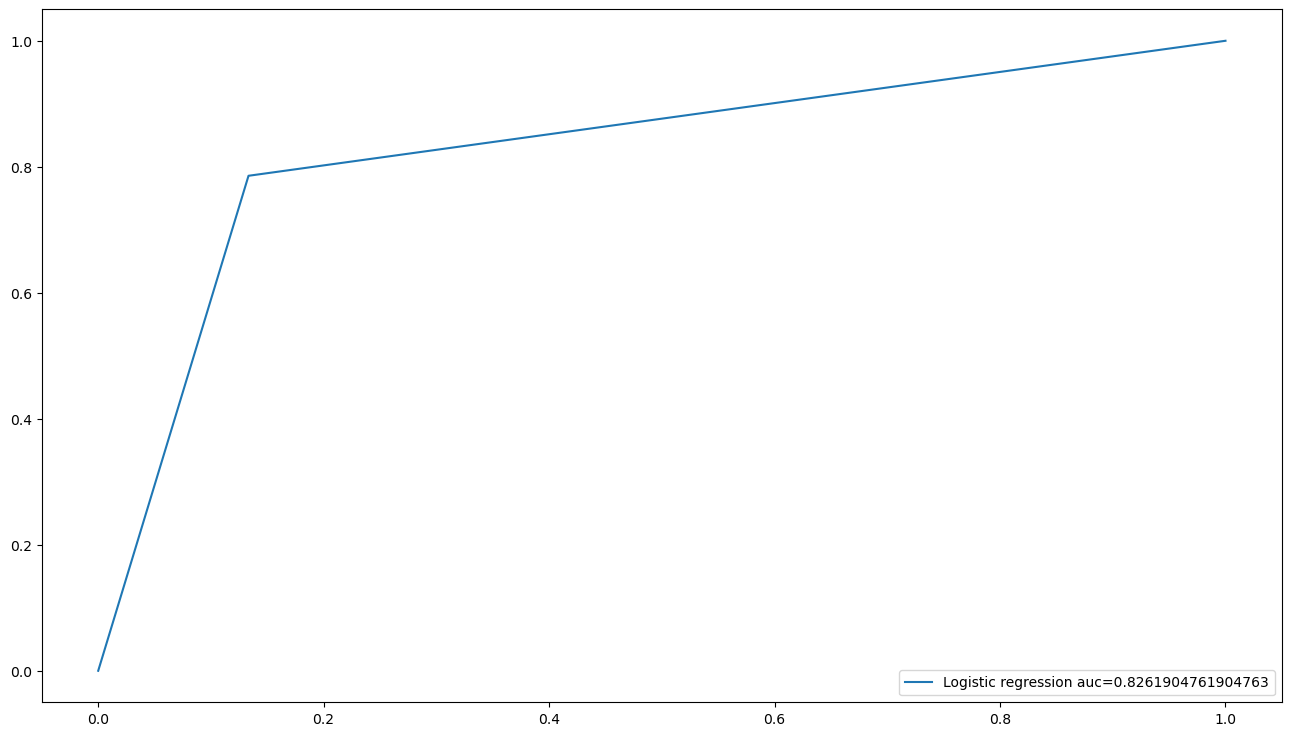

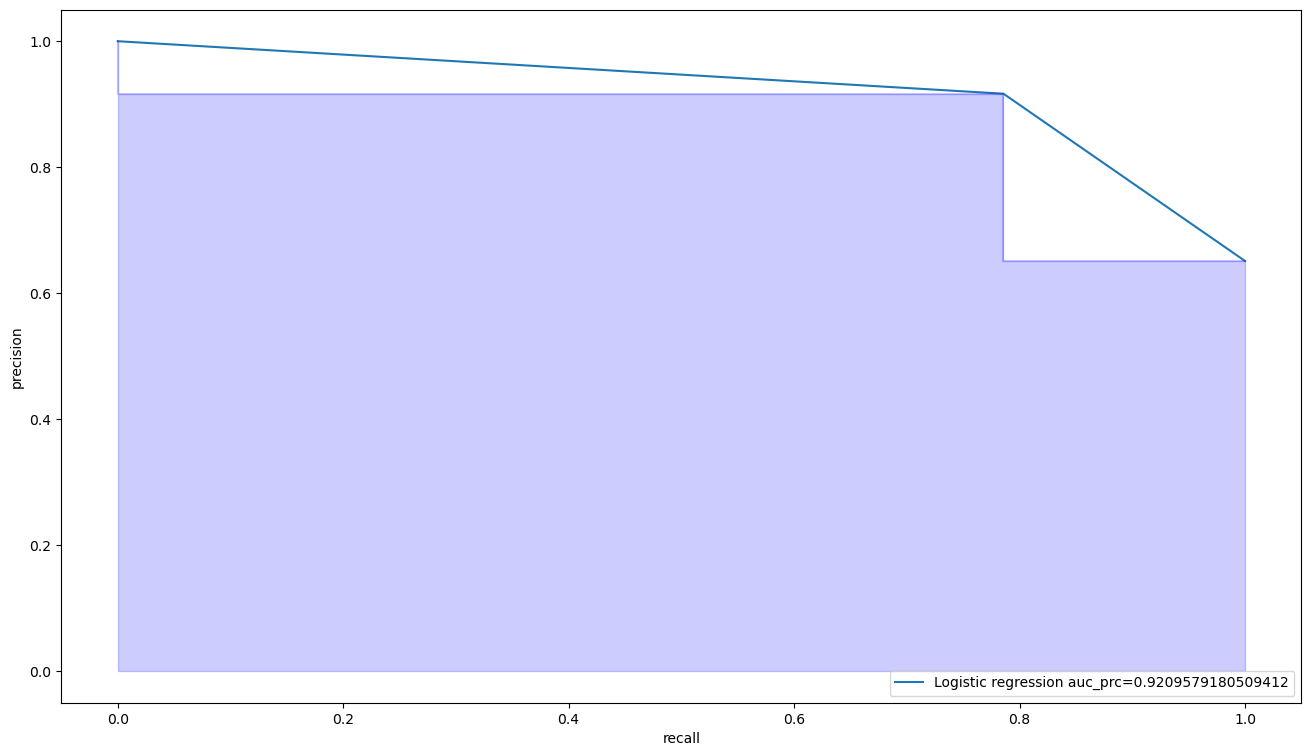

Train Result:
Accuracy Score: 73.18%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.768421    0.704000  0.731818    0.736211      0.736211
recall       0.663636    0.800000  0.731818    0.731818      0.731818
f1-score     0.712195    0.748936  0.731818    0.730566      0.730566
support    110.000000  110.000000  0.731818  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[73 37]
 [22 88]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.684211   0.916667  0.813953   0.800439      0.835577
recall      0.866667   0.785714  0.813953   0.826190      0.813953
f1-score    0.764706   0.846154  0.813953   0.805430      0.817742
support    15.000000  28.000

In [64]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,logistic_Reg.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, logistic_Reg.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_filter)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_filter,logistic_Reg.predict(X_test_filter))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 100.90 seconds


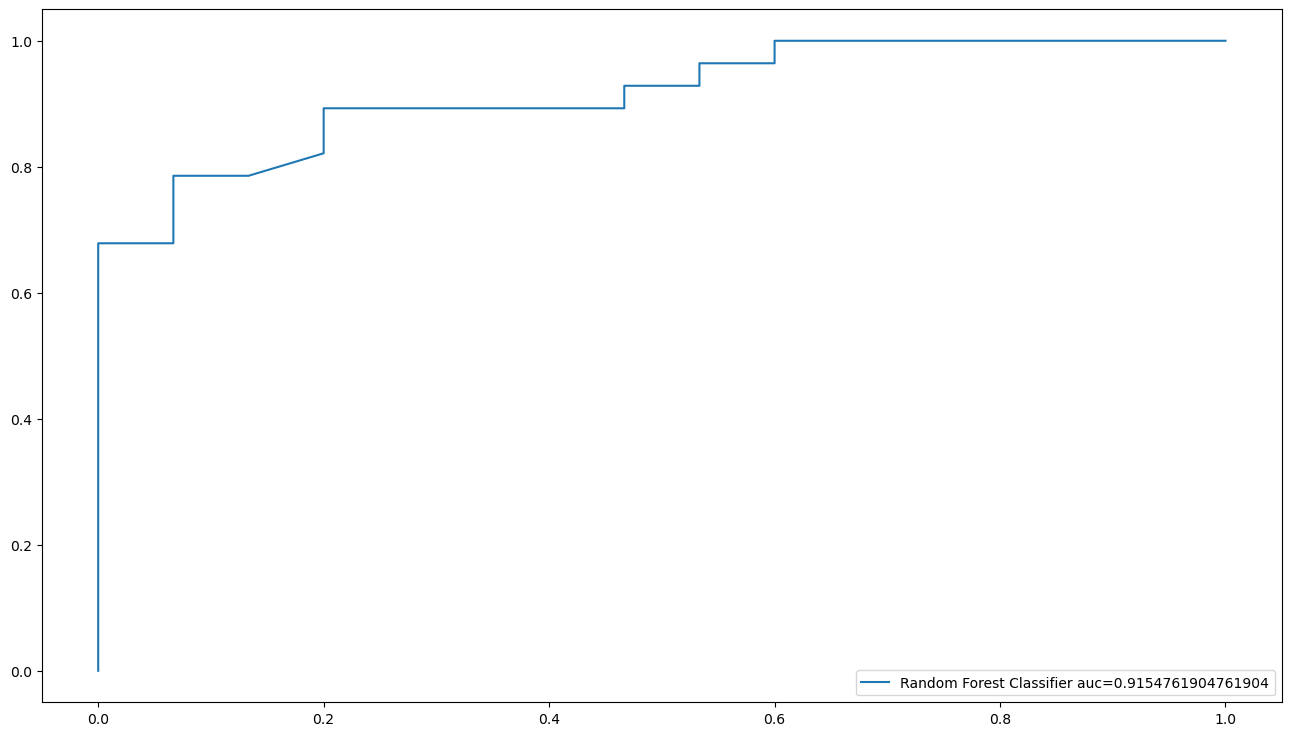

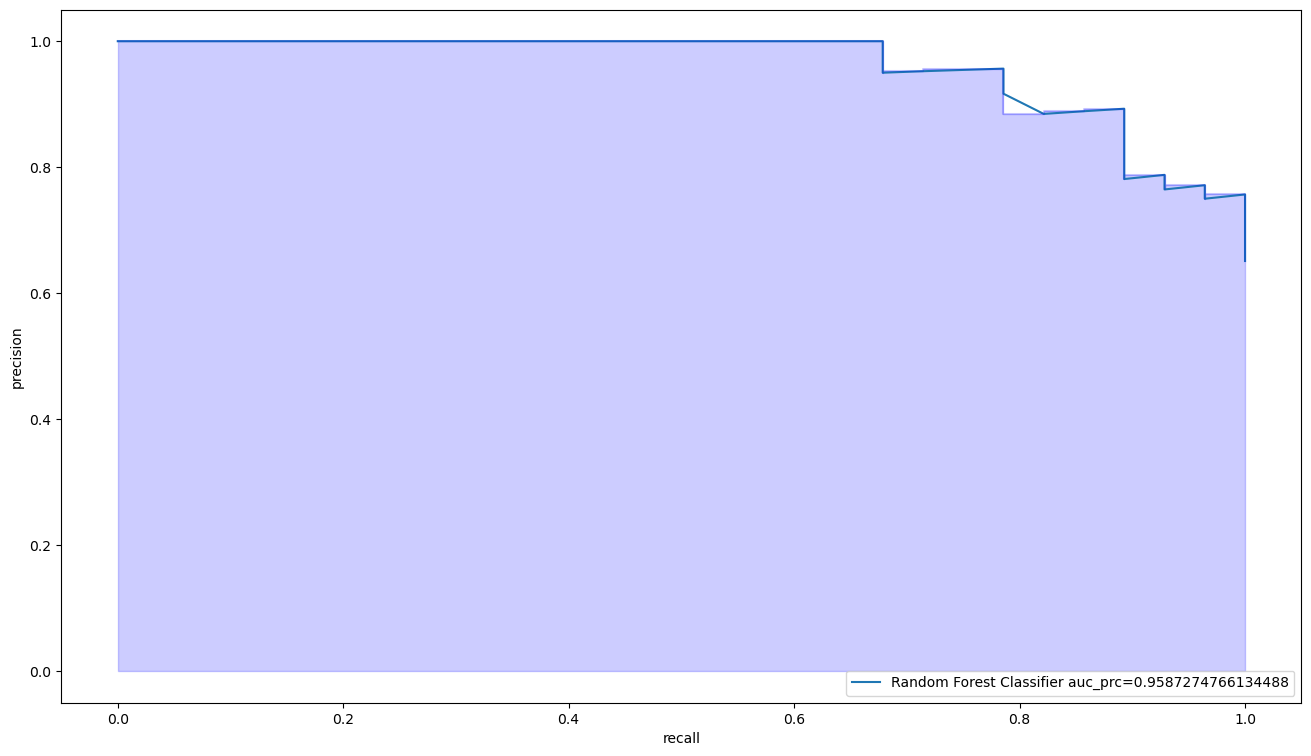

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 86.05%
________________________________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.8   0.892857  0.860465   0.846429      0.860465
recall      0.8   0.892857  0.860465   0.846429      0.860465
f1-score    0.8   0.892857  0.860465   0.846429      0.860465
support    15.0  28.000000  0.860465  43.000000     43.000000
____________________________________

In [65]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,RFC.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, RFC.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_filter)

clf_rdf=print_auc(RFC,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_filter,RFC.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 46.17 seconds


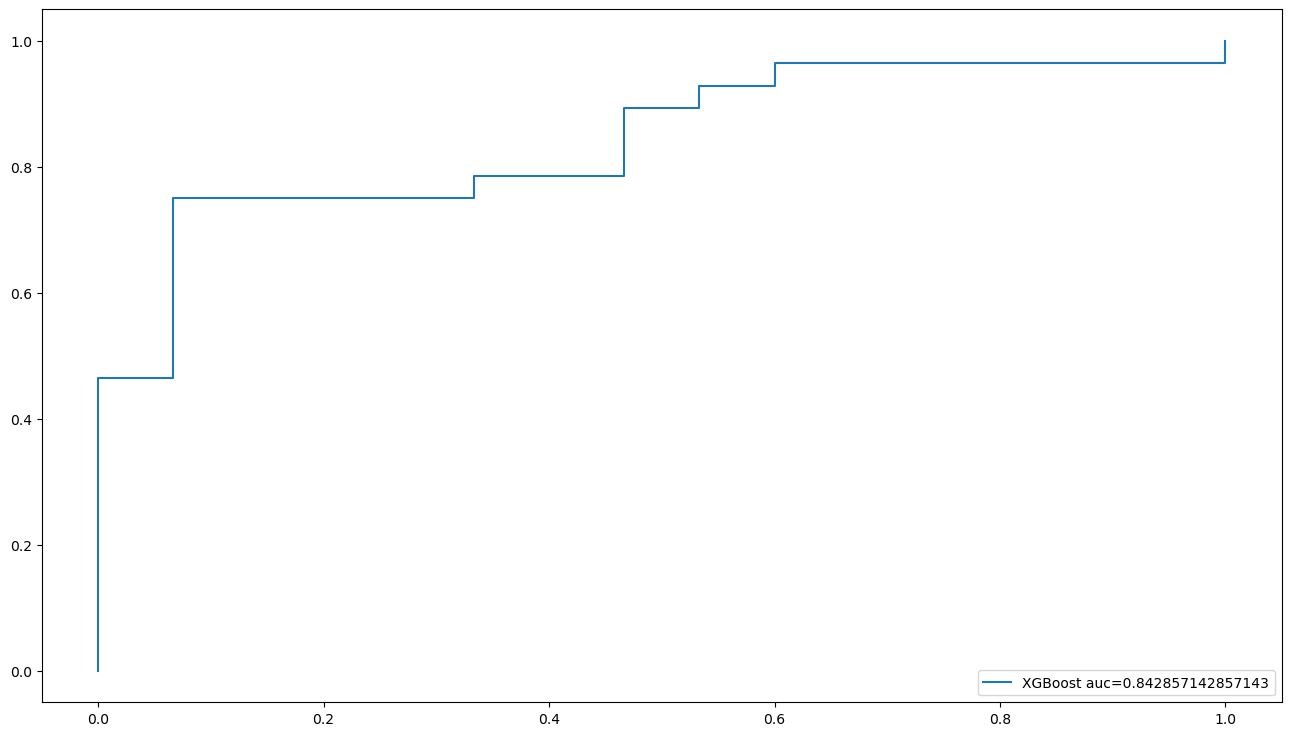

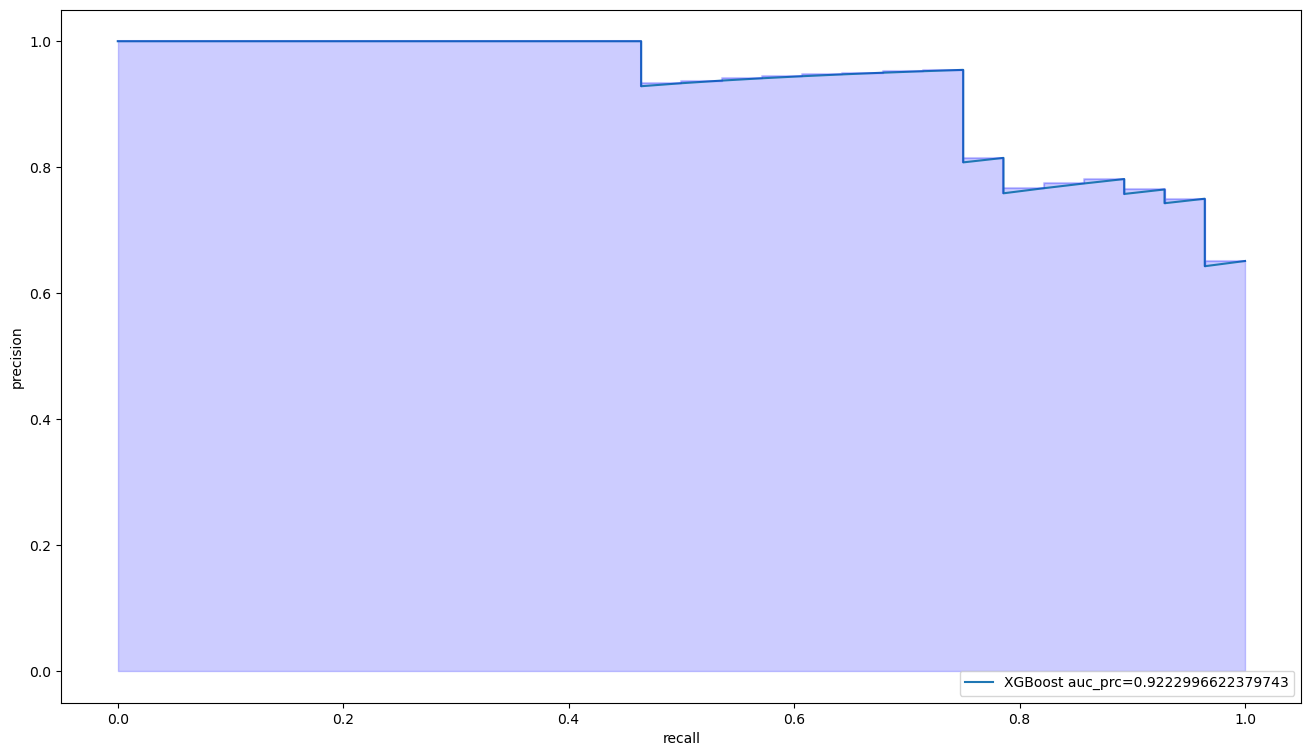

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.611111   0.840000  0.744186   0.725556      0.760155
recall      0.733333   0.750000  0.744186   0.741667      0.744186
f1-score    0.666667   0.792453  0.744186   0.729560      0.748574
support    15.000000  28.000000  0.744186  43.000000     43.000000
___________

In [66]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,XGB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, XGB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_filter)

clf_xgb=print_auc(XGB,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_filter,XGB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 40, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 137.43 seconds


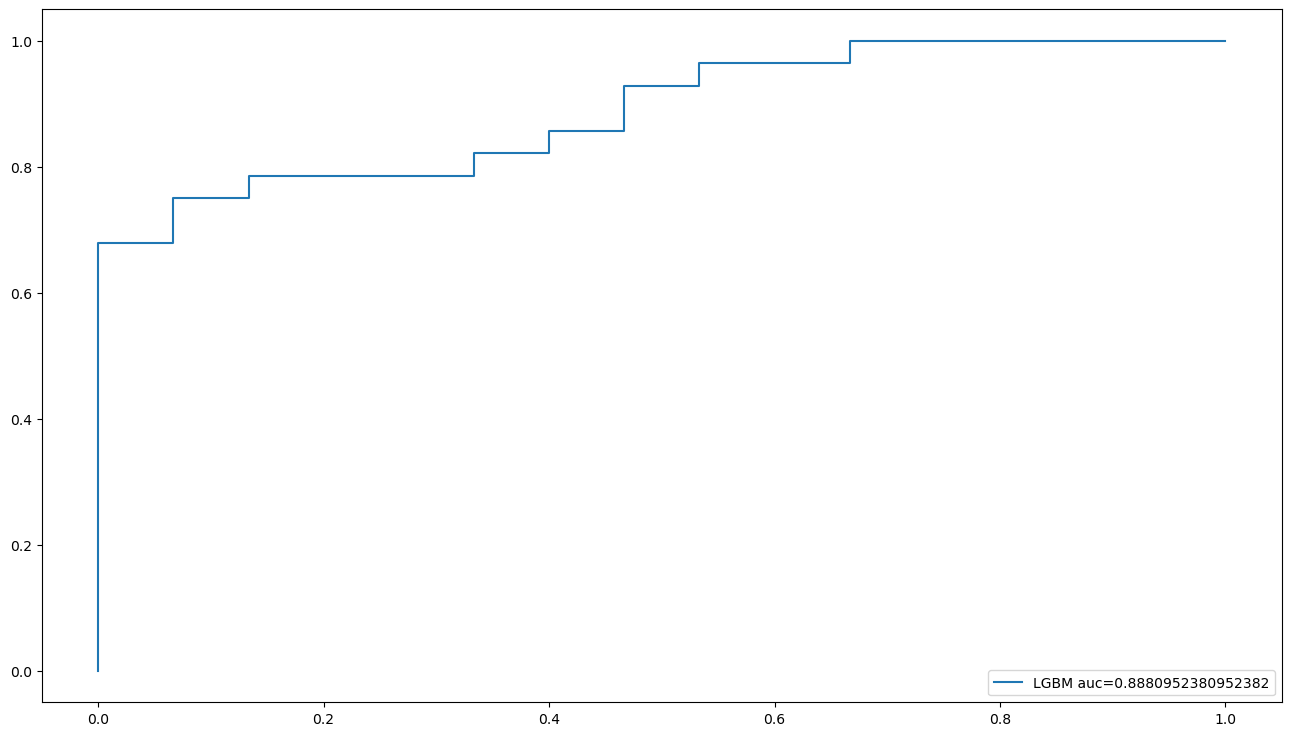

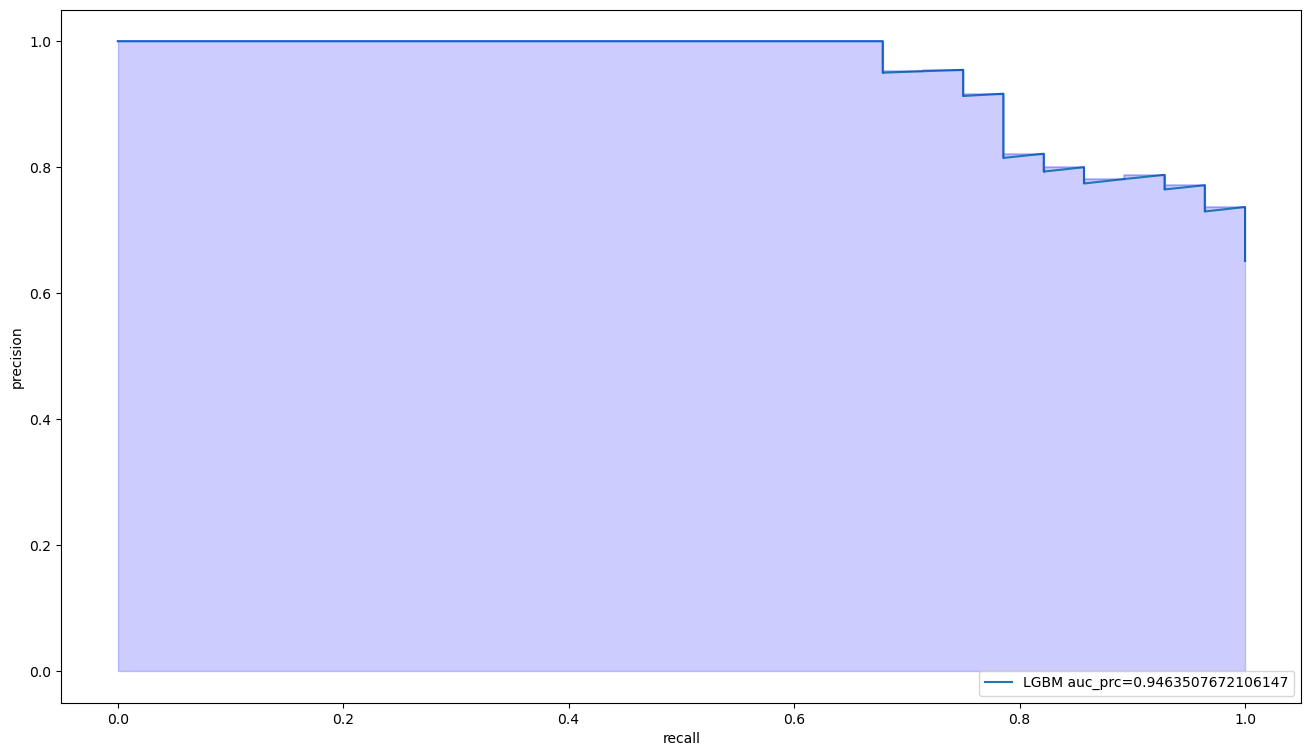

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.642857   0.793103  0.744186   0.717980      0.740692
recall      0.600000   0.821429  0.744186   0.710714      0.744186
f1-score    0.620690   0.807018  0.744186   0.713854      0.742019
support    15.000000  28.000000  0.744186  43.000000     43.000000
___________

In [67]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,LGB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, LGB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_filter)

clf_lgb=print_auc(LGB,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_filter,LGB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.68 seconds


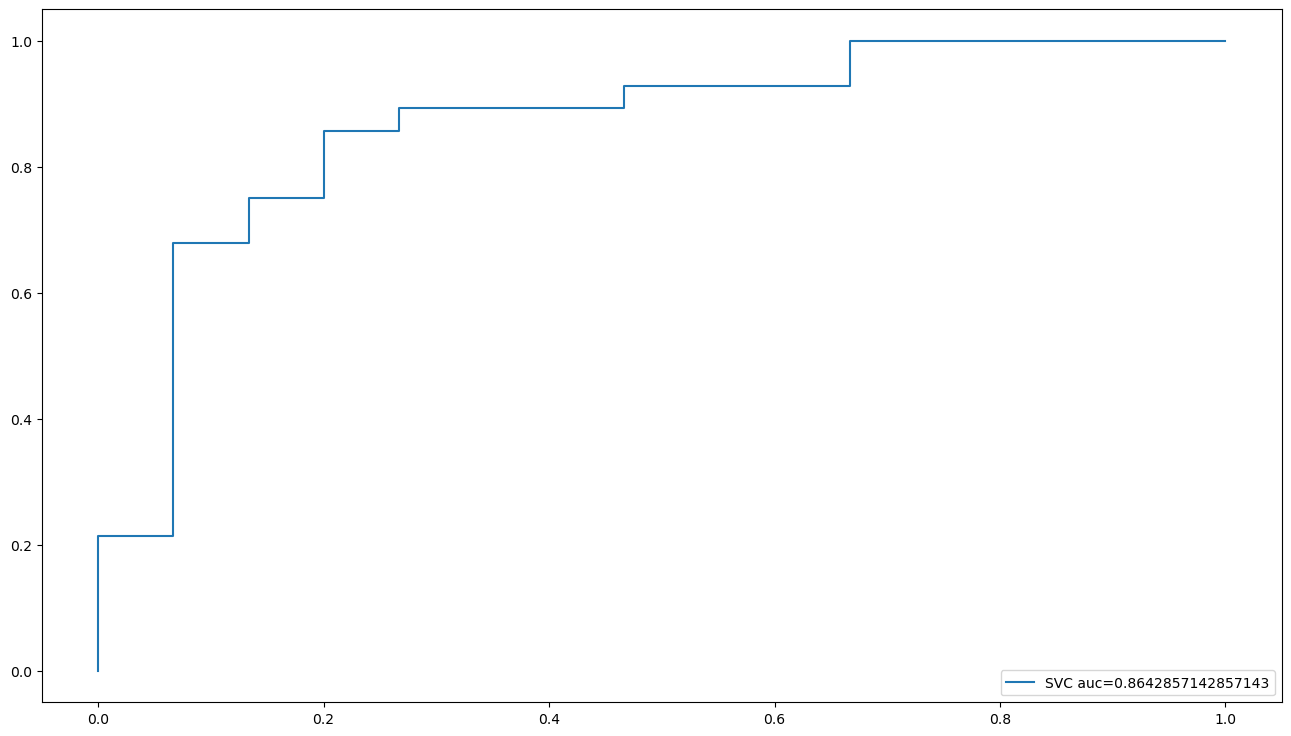

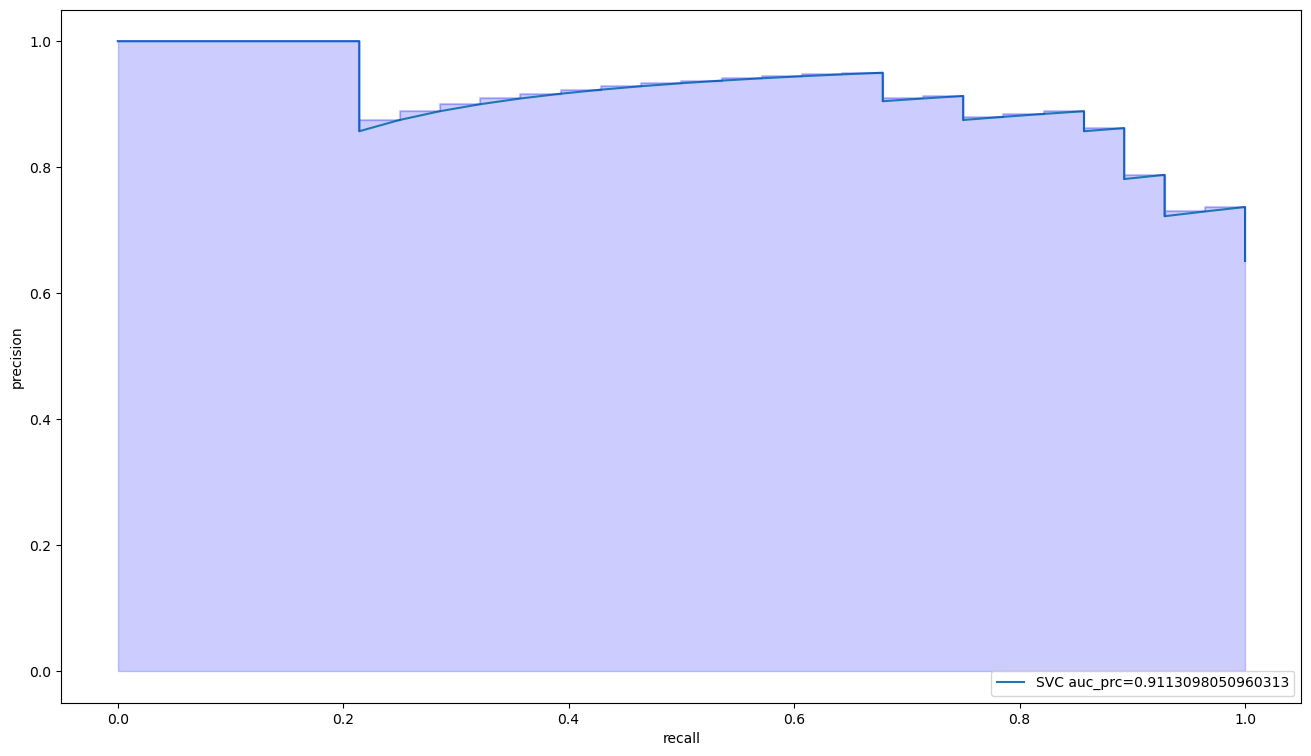

Train Result:
Accuracy Score: 81.36%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.816514    0.810811  0.813636    0.813662      0.813662
recall       0.809091    0.818182  0.813636    0.813636      0.813636
f1-score     0.812785    0.814480  0.813636    0.813633      0.813633
support    110.000000  110.000000  0.813636  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[89 21]
 [20 90]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.705882   0.884615  0.813953   0.795249      0.822267
recall      0.800000   0.821429  0.813953   0.810714      0.813953
f1-score    0.750000   0.851852  0.813953   0.800926      0.816322
support    15.000000  28.000

In [68]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,svc.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, svc.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_filter)

clf_svc=print_auc(svc,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_filter,svc.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.01}
learning done in 0.12 seconds


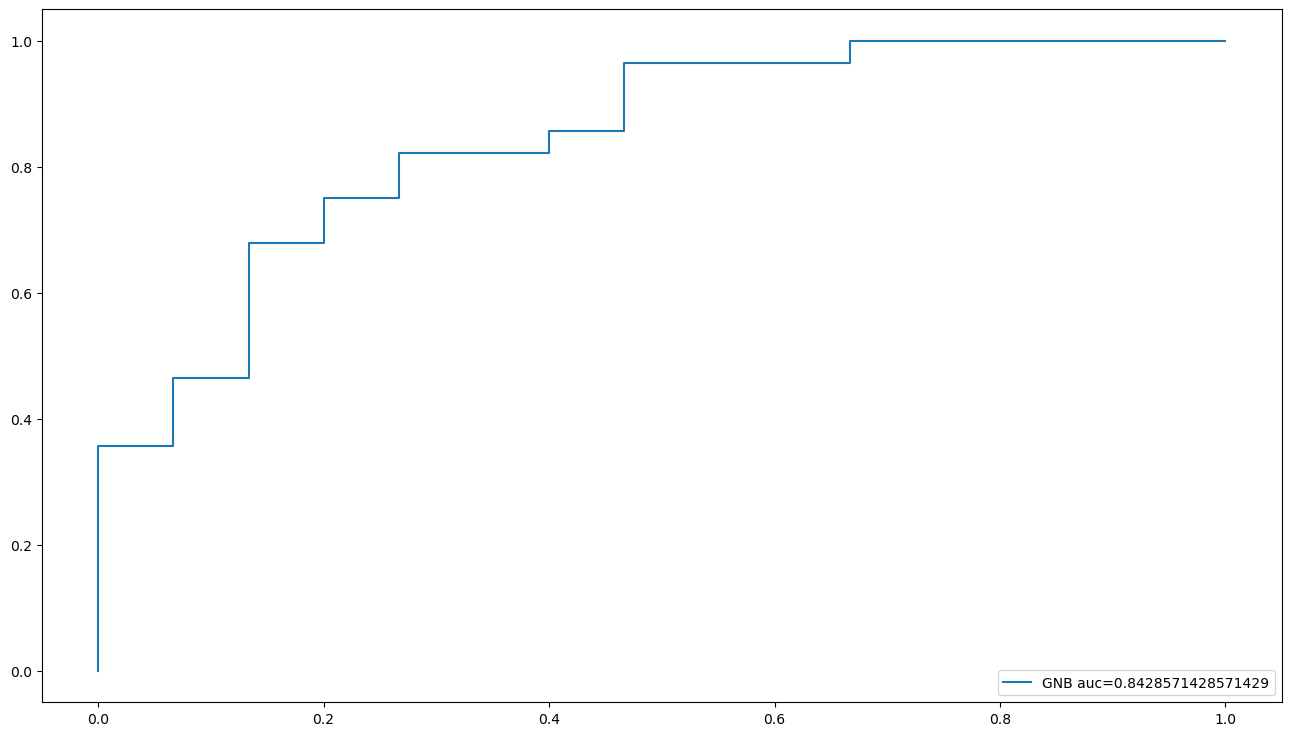

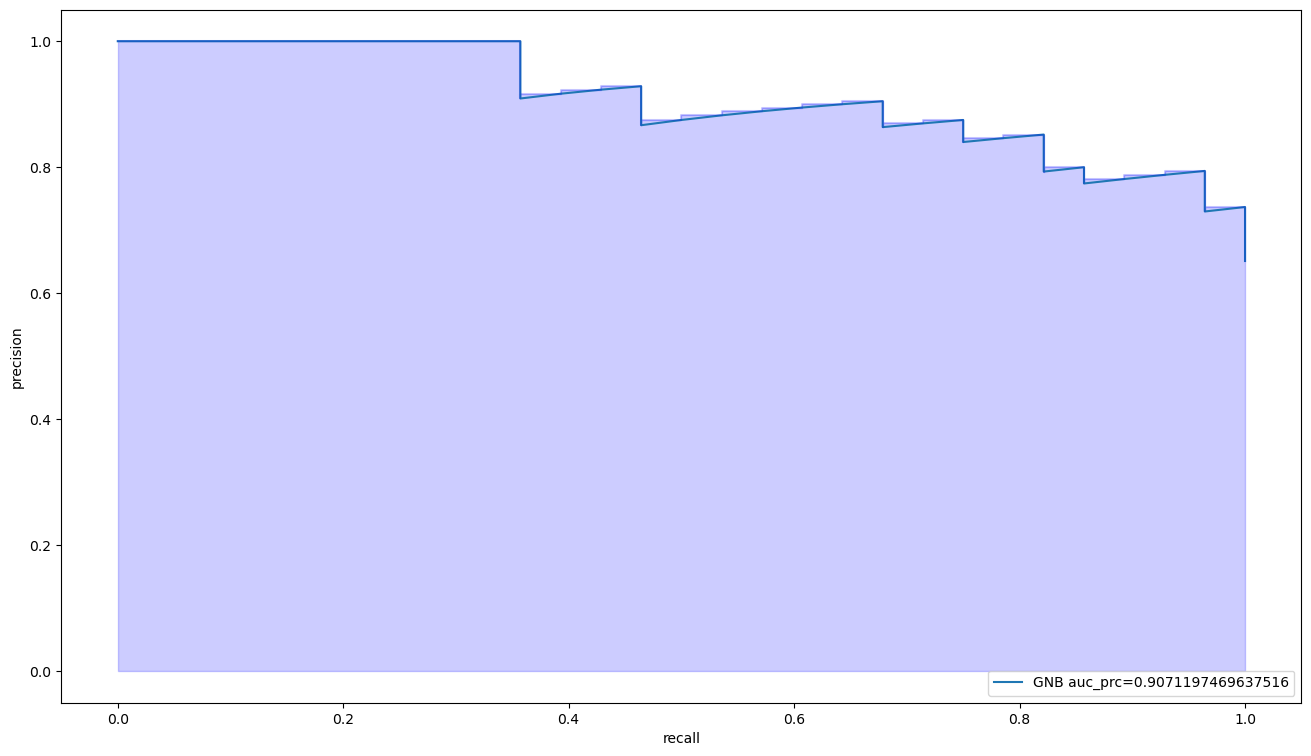

Train Result:
Accuracy Score: 74.55%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.821429    0.698529  0.745455    0.759979      0.759979
recall       0.627273    0.863636  0.745455    0.745455      0.745455
f1-score     0.711340    0.772358  0.745455    0.741849      0.741849
support    110.000000  110.000000  0.745455  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[69 41]
 [15 95]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.611111   0.840000  0.744186   0.725556      0.760155
recall      0.733333   0.750000  0.744186   0.741667      0.744186
f1-score    0.666667   0.792453  0.744186   0.729560      0.748574
support    15.000000  28.000

In [69]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,GNB.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, GNB.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_filter)

clf_gnb=print_auc(GNB,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_filter,GNB.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 27, 'p': 2, 'weights': 'distance'}
learning done in 15.74 seconds


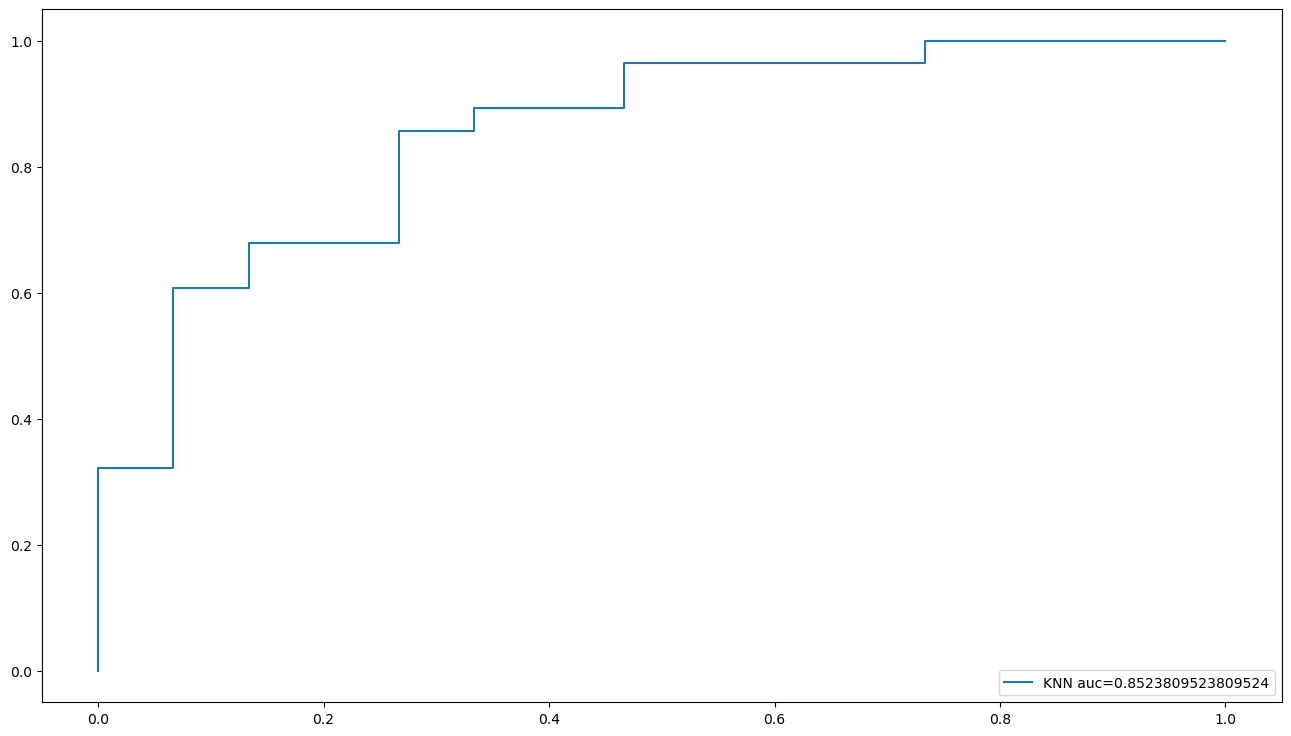

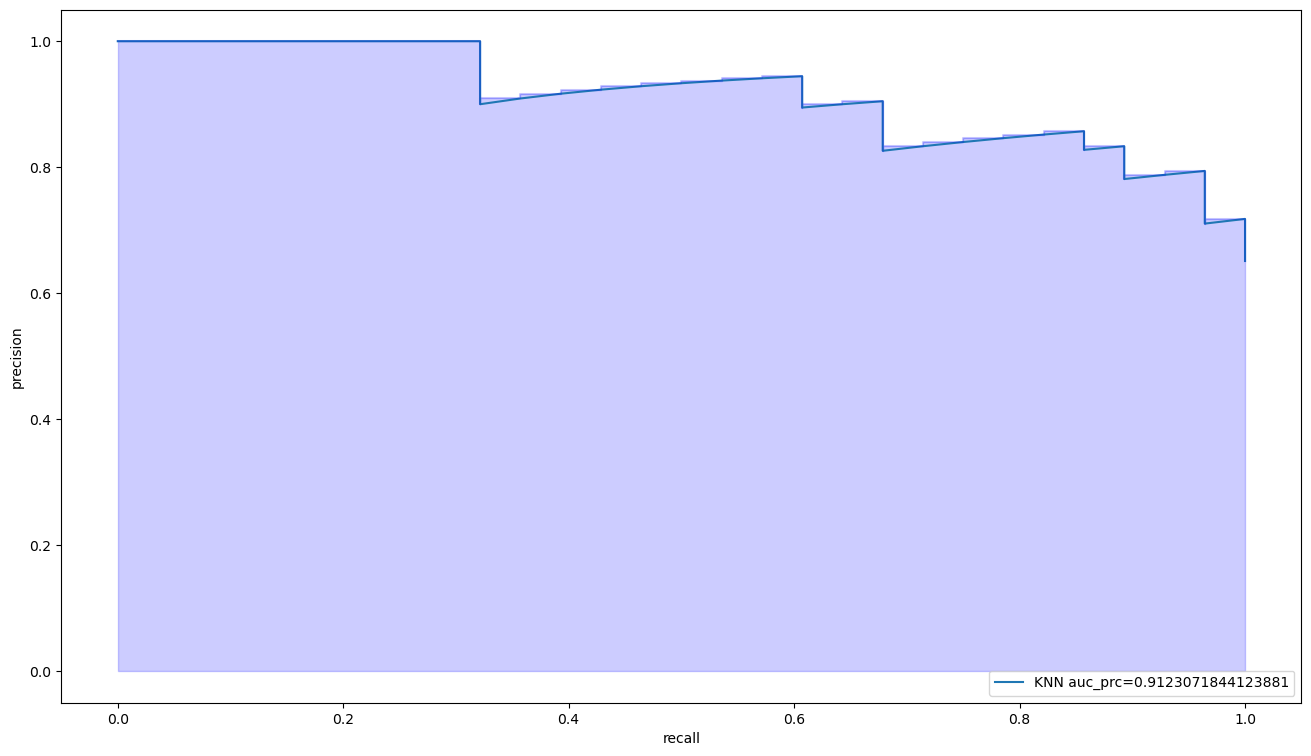

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 81.40%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.733333   0.857143  0.813953   0.795238      0.813953
recall      0.733333   0.857143  0.813953   0.795238      0.813953
f1-score    0.733333   0.857143  0.813953   0.795238      0.813953
support    15.000000  28.000000  0.813953  43.000000     43.000000
___________

In [70]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_filter_smote,y_train_filter_smote)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_filter_smote, y_train_filter_smote) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_filter,KNN.predict_proba(X_test_filter)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_filter, KNN.predict_proba(X_test_filter)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_filter)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_filter)

clf_knn=print_auc(KNN,X_train_filter_smote,y_train_filter_smote,X_test_filter,y_test_filter,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_filter,KNN.predict(X_test_filter))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## Save the results

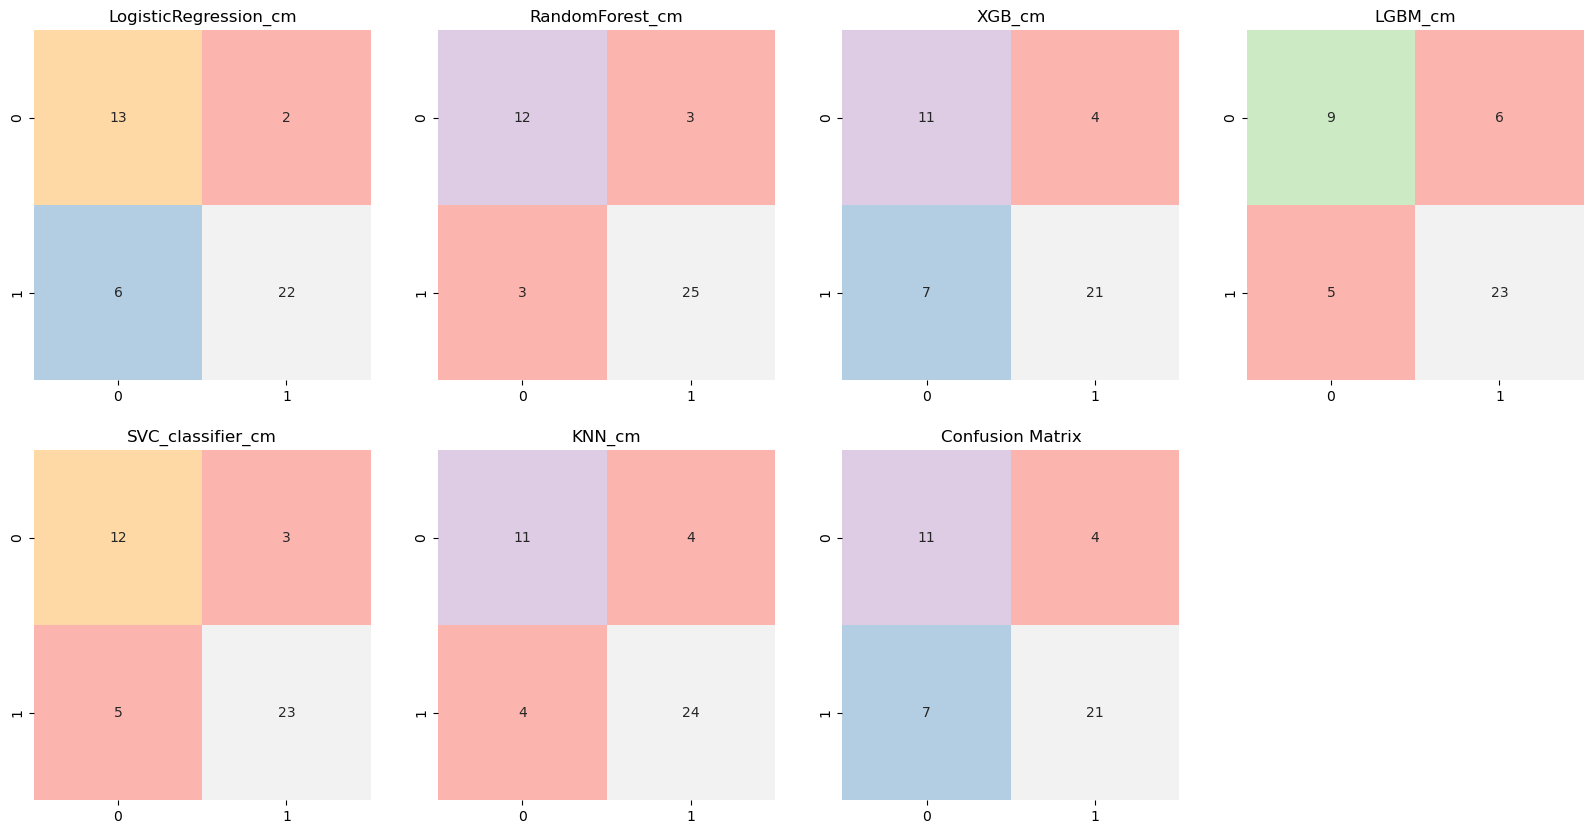

<Figure size 1600x900 with 0 Axes>

In [71]:
# Confusion matrix 
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.title("LogisticRegression_cm")
sns.heatmap(logistic_Reg_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,2)
plt.title("RandomForest_cm")
sns.heatmap(rdf_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,3)
plt.title("XGB_cm")
sns.heatmap(xgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,4)
plt.title("LGBM_cm")
sns.heatmap(lgb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,5)
plt.title("SVC_classifier_cm")
sns.heatmap(svc_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,6)
plt.title("KNN_cm")
sns.heatmap(knn_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)
plt.subplot(2,4,7)
plt.title("GNM_cm")
sns.heatmap(gnb_cm,annot=True,cmap="Pastel1",fmt="d",cbar=False)

plt.title("Confusion Matrix")
plt.show()

plt.savefig('Confusion matrix for full dataset (with filter and SMOTE)', dpi = 900)

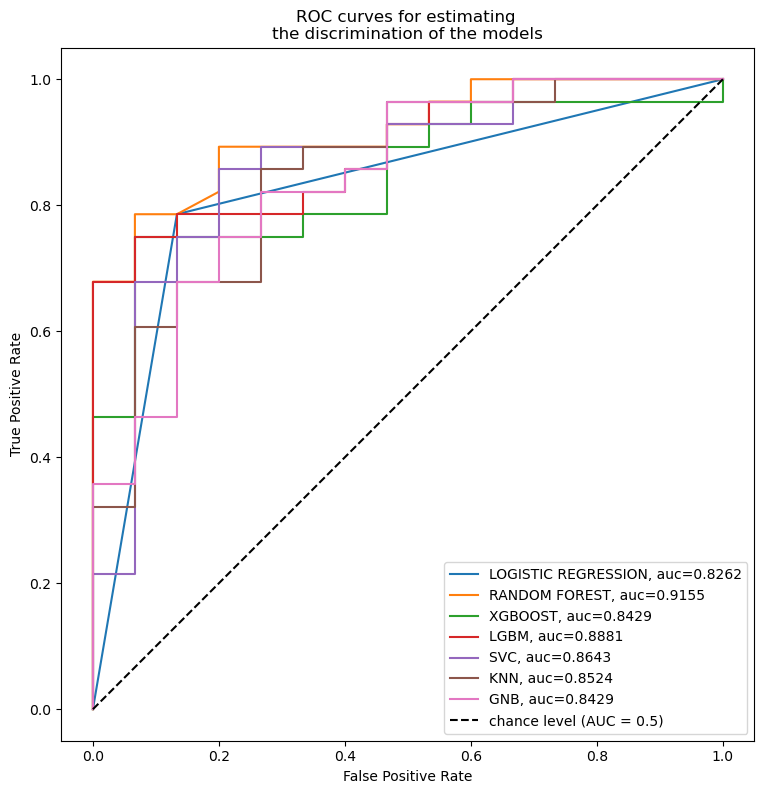

In [72]:
# plot AUC
plt.rcParams["figure.figsize"] = [16,9]

# plot the different model
plt.plot(logistic_Reg_clf["fpr"],logistic_Reg_clf["tpr"],label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc"],4)))
plt.plot(clf_rdf["fpr"],clf_rdf["tpr"],label="RANDOM FOREST, auc="+str(round(clf_rdf["auc"],4)))
plt.plot(clf_xgb["fpr"],clf_xgb["tpr"],label="XGBOOST, auc="+str(round(clf_xgb["auc"],4)))
plt.plot(clf_lgb["fpr"],clf_lgb["tpr"],label="LGBM, auc="+str(round(clf_lgb["auc"],4)))
plt.plot(clf_svc["fpr"],clf_svc["tpr"],label="SVC, auc="+str(round(clf_svc["auc"],4)))
plt.plot(clf_knn["fpr"],clf_knn["tpr"],label="KNN, auc="+str(round(clf_knn["auc"],4)))
plt.plot(clf_gnb["fpr"],clf_gnb["tpr"],label="GNB, auc="+str(round(clf_gnb["auc"],4)))

# Plot the median curve
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for estimating \nthe discrimination of the models")
plt.legend()
plt.style.use('fast')

plt.legend(loc=4)
plt.savefig('ROC AUC for full dataset (with Filter and SMOTE).png', dpi = 900)
plt.show()


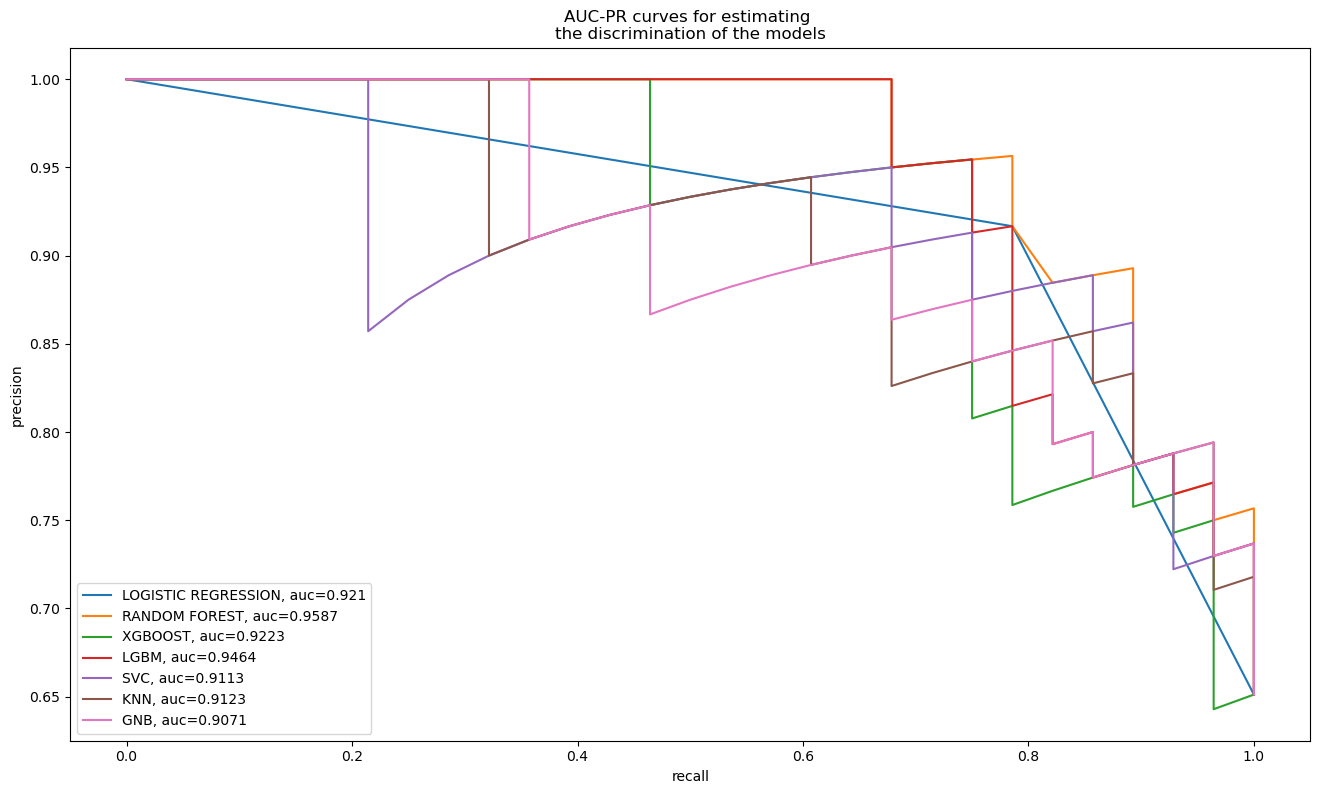

In [73]:
# Plot AUC_PR
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(logistic_Reg_clf["recall"],logistic_Reg_clf["precision"], label="LOGISTIC REGRESSION, auc="+str(round(logistic_Reg_clf["auc_pr"],4)))

plt.plot(clf_rdf["recall"],clf_rdf["precision"], label="RANDOM FOREST, auc="+str(round(clf_rdf["auc_pr"],4)))

plt.plot(clf_xgb["recall"],clf_xgb["precision"],label="XGBOOST, auc="+str(round(clf_xgb["auc_pr"],4)))

plt.plot(clf_lgb["recall"],clf_lgb["precision"],label="LGBM, auc="+str(round(clf_lgb["auc_pr"],4)))

plt.plot(clf_svc["recall"],clf_svc["precision"],label="SVC, auc="+str(round(clf_svc["auc_pr"],4)))

plt.plot(clf_knn["recall"],clf_knn["precision"],label="KNN, auc="+str(round(clf_knn["auc_pr"],4)))

plt.plot(clf_gnb["recall"],clf_gnb["precision"],label="GNB, auc="+str(round(clf_gnb["auc_pr"],4)))

plt.style.use('fast')
plt.title("AUC-PR curves for estimating \nthe discrimination of the models")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=3)
plt.savefig('AUC PR for full dataset (with Filter and SMOTE).png', dpi = 900)
plt.show()

In [74]:
results_df.to_csv('results for full dataset (with Filter and SMOTE).csv', index=True)

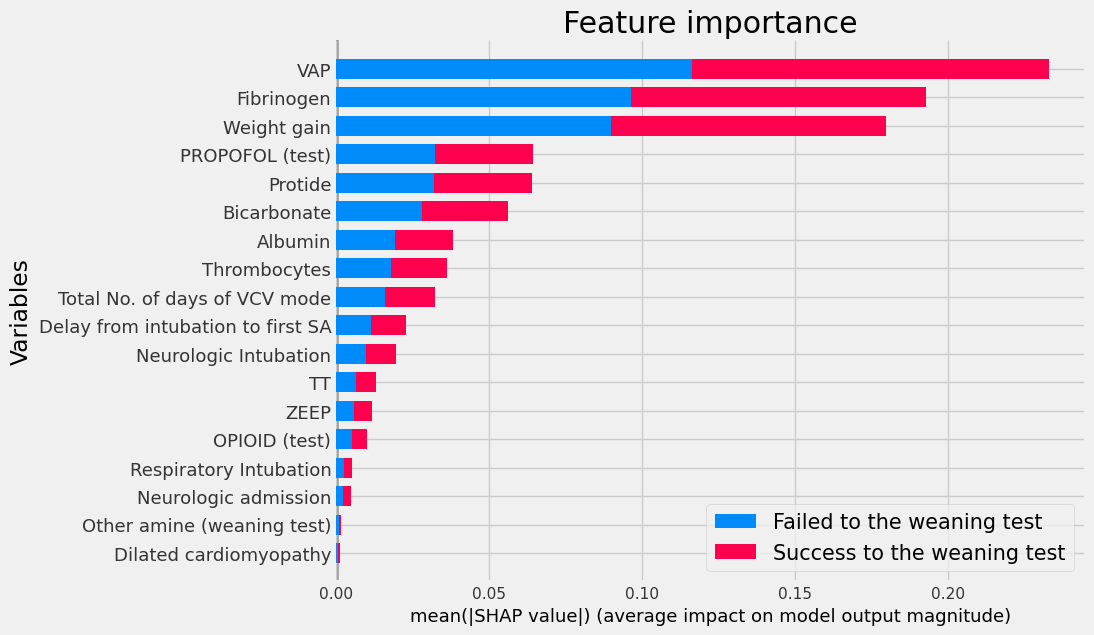

In [92]:
# Feature importance
explainer = shap.TreeExplainer(RFC)
shap_values = explainer.shap_values(X_test_filter)

fig = plt.figure()
shap.summary_plot(shap_values, X_test_filter, show = False) #No display before returning
#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 15})

plt.gcf().set_size_inches(13,6) #Modyfing the scale of the figure
plt.title("Feature importance") 
plt.ylabel("Variables")

L=plt.legend()
L.get_texts()[0].set_text('Failed to the weaning test') # Modifyng the legend label
L.get_texts()[1].set_text('Success to the weaning test')
plt.style.use('fivethirtyeight')
plt.show()
plt.savefig('Feature importance v1.png', dpi = 900)

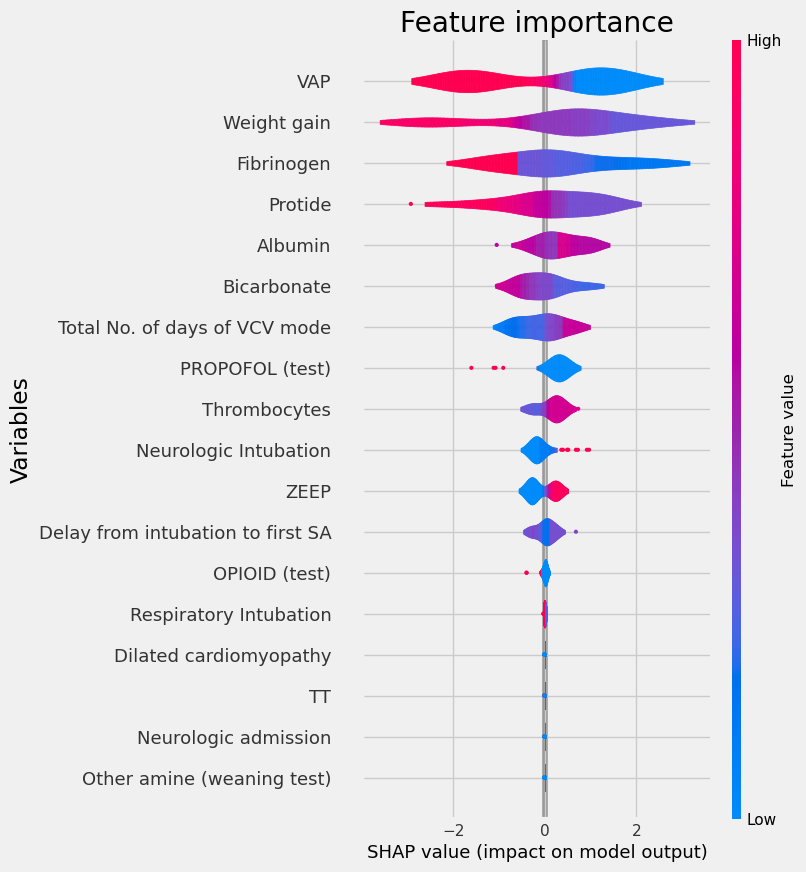

In [94]:
# Feature importance
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X_test_filter)

shap.summary_plot(shap_values, X_test_filter, plot_type='violin', max_display=X_test_filter.shape[1], show = False)
#max_display, show the N feature we want in the plot 

plt.ylabel("Variables")
plt.title("Feature importance")

plt.show()
plt.savefig('Feature importance v2.png', dpi = 900)
 

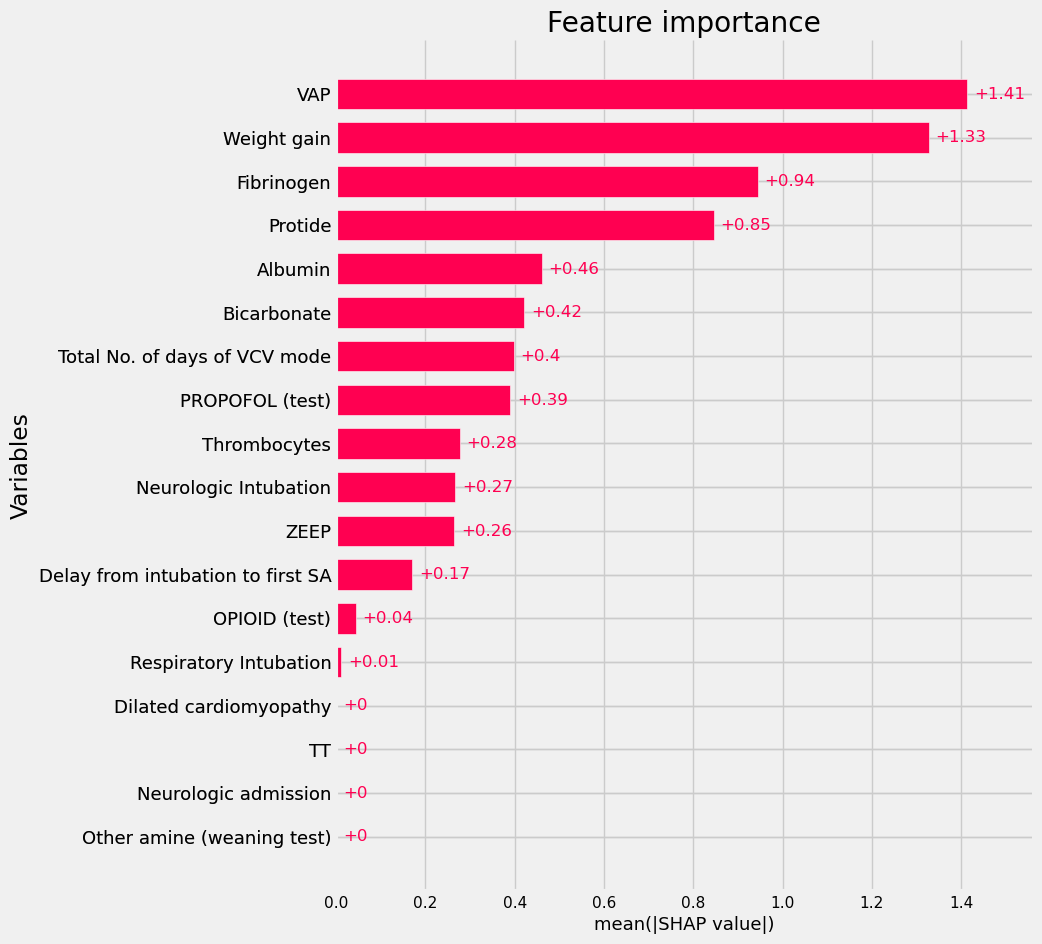

In [114]:
explainer = shap.Explainer(XGB)
shap_values = explainer(X_test_filter)

shap.plots.bar(shap_values, max_display=X_test_filter.shape[1])
plt.ylabel("Variables")
plt.title("Feature importance")

plt.savefig('Feature importance v3.png', dpi = 900)
 


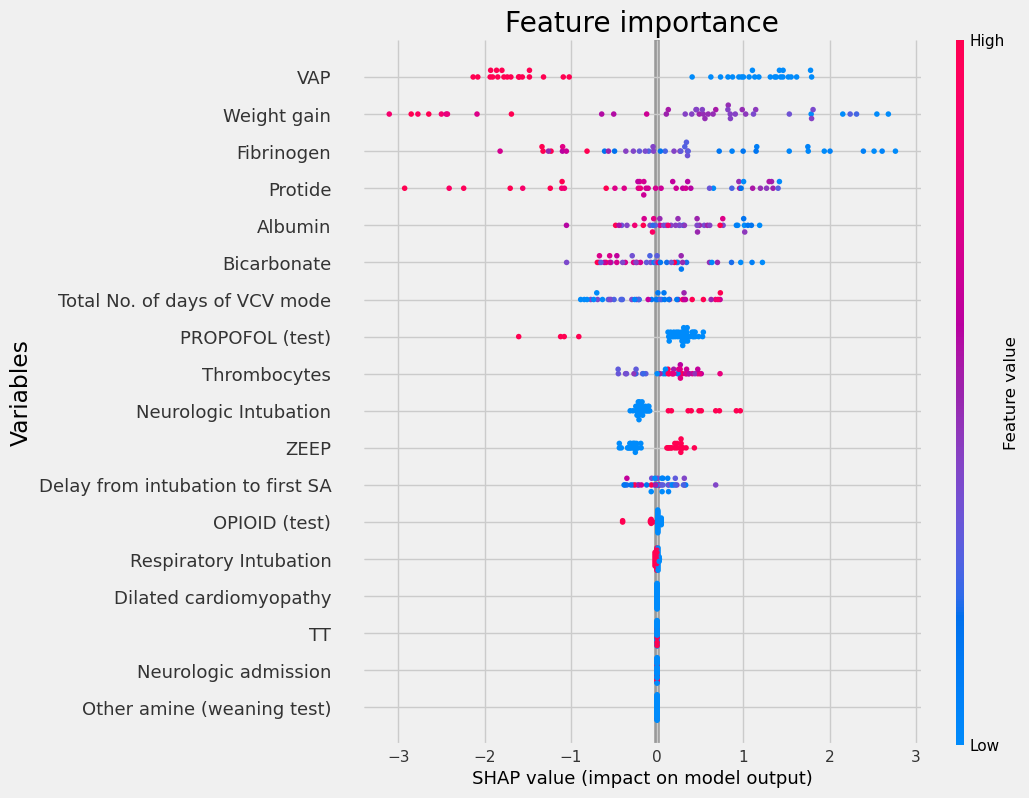

In [111]:
shap.plots.beeswarm(shap_values, max_display=X_test_filter.shape[1])
plt.ylabel("Variables")
plt.title("Feature importance")
plt.savefig('Feature importance v4.png', dpi = 900)


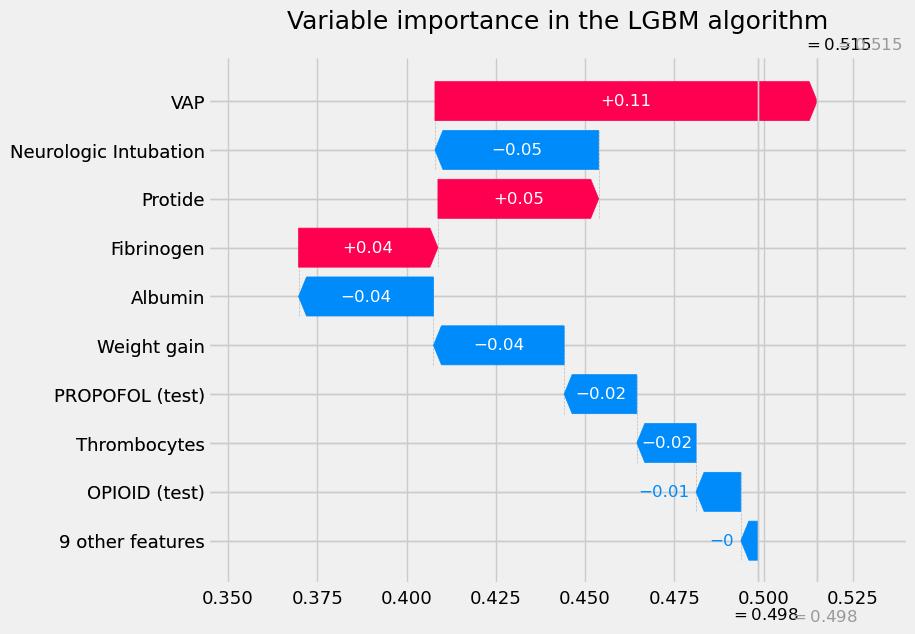

In [85]:
explainer = shap.explainers.Tree(RFC)
shap_values = explainer(X_test_filter)
id = 10
fig = plt.figure()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],shap_values[id].values[:,0],
                                        feature_names=X_test_filter.columns, show = False )
plt.ylabel("Variables")
plt.title("Variable importance in the LGBM algorithm", fontsize=18)
plt.show()